<a href="https://colab.research.google.com/github/Barissdal/TimeSeries/blob/main/hierarchical_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
!pip install scikit-hts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import pandas as pd
import numpy as np
import hts

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter("ignore")

In [8]:
# settings
plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (16, 8)

In [9]:
%config InlineBackend.figure_format = 'retina'

In [15]:
df = pd.read_csv("/content/drive/MyDrive/resource/htimeseries.csv",header=0, index_col=0)

In [16]:
df.head()

Quarter    Region            State   Purpose       Trips
1  1998-01-01  Adelaide  South Australia  Business  135.077690
2  1998-04-01  Adelaide  South Australia  Business  109.987316
3  1998-07-01  Adelaide  South Australia  Business  166.034687
4  1998-10-01  Adelaide  South Australia  Business  127.160464
5  1999-01-01  Adelaide  South Australia  Business  137.448533

In [17]:
# lowercase the column names
df.columns = [col_name.lower() for col_name in df.columns]

# sum the trips over purpose
df = df.groupby(["quarter", "region", "state"])["trips"] \
       .sum() \
       .reset_index(drop=False)

# cleanup region name 
df["region"] = df["region"].apply(lambda x: x.replace(" ", "_").replace("'", ""))

# map the full state names to abbreviations
mapping_dict = {
    "New South Wales": "NSW",
    "Northern Territory": "NT",
    "Queensland": "QLD",
    "South Australia": "SA",
    "Victoria": "VIC",
    "Western Australia": "WA",
    "ACT": "ACT",
}

df["state"] = df["state"].map(mapping_dict)

# create the bottom level id
df["state_region"] = df.apply(lambda x: f"{x['state']}_{x['region']}", axis=1)

df.head()

quarter                     region state       trips  \
0  1998-01-01                   Adelaide    SA  658.553895   
1  1998-01-01             Adelaide_Hills    SA    9.798630   
2  1998-01-01              Alice_Springs    NT   20.207638   
3  1998-01-01     Australias_Coral_Coast    WA  132.516409   
4  1998-01-01  Australias_Golden_Outback    WA  161.726948   

                   state_region  
0                   SA_Adelaide  
1             SA_Adelaide_Hills  
2              NT_Alice_Springs  
3     WA_Australias_Coral_Coast  
4  WA_Australias_Golden_Outback

In [18]:
# inspect all the regions per state
df.groupby("state")["region"].apply(set).to_frame()

region
state                                                   
ACT                                           {Canberra}
NSW    {Riverina, Central_NSW, Capital_Country, New_E...
NT     {Lasseter, Launceston,_Tamar_and_the_North, Ho...
QLD    {Gold_Coast, Central_Queensland, Northern, Mac...
SA     {Fleurieu_Peninsula, Flinders_Ranges_and_Outba...
VIC    {High_Country, Ballarat, Upper_Yarra, Mallee, ...
WA     {Australias_North_West, Australias_Coral_Coast...

In [20]:
# create the bottom level df
df_bottom_level = df.pivot(index="quarter", columns="state_region", values="trips")

df_bottom_level.head()

state_region  ACT_Canberra  NSW_Blue_Mountains  NSW_Capital_Country  \
quarter                                                               
1998-01-01      551.001921          195.543180           261.808142   
1998-04-01      416.025623          200.408671           238.600029   
1998-07-01      436.029011          253.359689           184.423752   
1998-10-01      449.798445          245.573846           229.088938   
1999-01-01      378.572817          290.484124           252.281951   

state_region  NSW_Central_Coast  NSW_Central_NSW  NSW_Hunter  \
quarter                                                        
1998-01-01           455.166849       424.395446  674.978457   
1998-04-01           343.476758       557.011571  791.887234   
1998-07-01           303.670875       555.527970  566.040599   
1998-10-01           331.817060       590.158435  591.568947   
1999-01-01           466.815571       480.129260  785.102775   

state_region  NSW_New_England_North_West  NSW_North_Coast_NSW  \
quarter                                                         
1998-01-01                    329.838506          1342.301230   
1998-04-01                    328.366005          1161.108602   
1998-07-01                    324.859168           839.368066   
1998-10-01                    279.796195          1183.859971   
1999-01-01                    327.491877          1306.877508   

state_region  NSW_Outback_NSW  NSW_Riverina  ...  VIC_Spa_Country  \
quarter                                      ...                    
1998-01-01          96.602651    215.268912  ...        86.196006   
1998-04-01         120.648446    336.094921  ...        74.356890   
1998-07-01         110.073779    228.065371  ...        60.778546   
1998-10-01         185.470023    201.123526  ...        46.013284   
1999-01-01          78.363807    200.822443  ...        65.299169   

state_region  VIC_Upper_Yarra  VIC_Western  VIC_Western_Grampians  \
quarter                                                             
1998-01-01         102.791022   739.350975              86.996591   
1998-04-01          74.855136   359.626051              84.939977   
1998-07-01          59.465405   342.321758              79.974884   
1998-10-01          35.238855   445.968992             116.235617   
1999-01-01          67.823457   607.808299             101.765635   

state_region  VIC_Wimmera  WA_Australias_Coral_Coast  \
quarter                                                
1998-01-01      18.804743                 132.516409   
1998-04-01      52.482311                 172.615378   
1998-07-01      35.657551                 173.904335   
1998-10-01      27.204455                 207.002571   
1999-01-01      50.219851                 198.856638   

state_region  WA_Australias_Golden_Outback  WA_Australias_North_West  \
quarter                                                                
1998-01-01                      161.726948                120.775450   
1998-04-01                      164.973780                158.404387   
1998-07-01                      206.879934                184.619035   
1998-10-01                      198.509591                138.878263   
1999-01-01                      140.213443                103.337122   

state_region  WA_Australias_South_West  WA_Experience_Perth  
quarter                                                      
1998-01-01                  474.858729           751.211958  
1998-04-01                  411.622281           668.710707  
1998-07-01                  360.039657           662.850731  
1998-10-01                  462.620050           832.706514  
1999-01-01                  562.974629           830.305740  

[5 rows x 77 columns]

In [21]:
# create the middle level df
df_middle_level = df.groupby(["quarter", "state"]) \
                    .sum() \
                    .reset_index(drop=False) \
                    .pivot(index="quarter", columns="state", values="trips")

df_middle_level.head()

state              ACT          NSW           NT          QLD           SA  \
quarter                                                                      
1998-01-01  551.001921  8039.794795  1914.709878  4042.779858  1732.743704   
1998-04-01  416.025623  7166.013805  1541.405790  3967.069714  1394.638319   
1998-07-01  436.029011  6747.935790  1321.819326  4598.548477  1213.330723   
1998-10-01  449.798445  7282.082371  1439.406267  4207.772812  1449.354514   
1999-01-01  378.572817  7584.776839  1830.389536  4332.490850  1535.459593   

state               VIC           WA  
quarter                               
1998-01-01  6010.424491  1641.089495  
1998-04-01  4795.246755  1576.326534  
1998-07-01  4316.845170  1588.293692  
1998-10-01  4674.829118  1839.716990  
1999-01-01  5304.334195  1835.687573

In [22]:
# create the total level df
df_total = df.groupby("quarter")["trips"] \
             .sum() \
             .to_frame() \
             .rename(columns={"trips": "total"})

df_total.head(5)

total
quarter                 
1998-01-01  23932.544141
1998-04-01  20856.726540
1998-07-01  20222.802189
1998-10-01  21342.960517
1999-01-01  22801.711403

In [56]:
# join the DataFrames
hierarchy_df = df_bottom_level.join(df_middle_level) \
                              .join(df_total)

hierarchy_df.head()

ACT_Canberra  NSW_Blue_Mountains  NSW_Capital_Country  \
quarter                                                             
1998-01-01    551.001921          195.543180           261.808142   
1998-04-01    416.025623          200.408671           238.600029   
1998-07-01    436.029011          253.359689           184.423752   
1998-10-01    449.798445          245.573846           229.088938   
1999-01-01    378.572817          290.484124           252.281951   

            NSW_Central_Coast  NSW_Central_NSW  NSW_Hunter  \
quarter                                                      
1998-01-01         455.166849       424.395446  674.978457   
1998-04-01         343.476758       557.011571  791.887234   
1998-07-01         303.670875       555.527970  566.040599   
1998-10-01         331.817060       590.158435  591.568947   
1999-01-01         466.815571       480.129260  785.102775   

            NSW_New_England_North_West  NSW_North_Coast_NSW  NSW_Outback_NSW  \
quarter                                                                        
1998-01-01                  329.838506          1342.301230        96.602651   
1998-04-01                  328.366005          1161.108602       120.648446   
1998-07-01                  324.859168           839.368066       110.073779   
1998-10-01                  279.796195          1183.859971       185.470023   
1999-01-01                  327.491877          1306.877508        78.363807   

            NSW_Riverina  ...  WA_Australias_South_West  WA_Experience_Perth  \
quarter                   ...                                                  
1998-01-01    215.268912  ...                474.858729           751.211958   
1998-04-01    336.094921  ...                411.622281           668.710707   
1998-07-01    228.065371  ...                360.039657           662.850731   
1998-10-01    201.123526  ...                462.620050           832.706514   
1999-01-01    200.822443  ...                562.974629           830.305740   

                   ACT          NSW           NT          QLD           SA  \
quarter                                                                      
1998-01-01  551.001921  8039.794795  1914.709878  4042.779858  1732.743704   
1998-04-01  416.025623  7166.013805  1541.405790  3967.069714  1394.638319   
1998-07-01  436.029011  6747.935790  1321.819326  4598.548477  1213.330723   
1998-10-01  449.798445  7282.082371  1439.406267  4207.772812  1449.354514   
1999-01-01  378.572817  7584.776839  1830.389536  4332.490850  1535.459593   

                    VIC           WA         total  
quarter                                             
1998-01-01  6010.424491  1641.089495  23932.544141  
1998-04-01  4795.246755  1576.326534  20856.726540  
1998-07-01  4316.845170  1588.293692  20222.802189  
1998-10-01  4674.829118  1839.716990  21342.960517  
1999-01-01  5304.334195  1835.687573  22801.711403  

[5 rows x 85 columns]

In [57]:
hierarchy_df.index = pd.to_datetime(hierarchy_df.index)

hierarchy_df.head()

ACT_Canberra  NSW_Blue_Mountains  NSW_Capital_Country  \
quarter                                                             
1998-01-01    551.001921          195.543180           261.808142   
1998-04-01    416.025623          200.408671           238.600029   
1998-07-01    436.029011          253.359689           184.423752   
1998-10-01    449.798445          245.573846           229.088938   
1999-01-01    378.572817          290.484124           252.281951   

            NSW_Central_Coast  NSW_Central_NSW  NSW_Hunter  \
quarter                                                      
1998-01-01         455.166849       424.395446  674.978457   
1998-04-01         343.476758       557.011571  791.887234   
1998-07-01         303.670875       555.527970  566.040599   
1998-10-01         331.817060       590.158435  591.568947   
1999-01-01         466.815571       480.129260  785.102775   

            NSW_New_England_North_West  NSW_North_Coast_NSW  NSW_Outback_NSW  \
quarter                                                                        
1998-01-01                  329.838506          1342.301230        96.602651   
1998-04-01                  328.366005          1161.108602       120.648446   
1998-07-01                  324.859168           839.368066       110.073779   
1998-10-01                  279.796195          1183.859971       185.470023   
1999-01-01                  327.491877          1306.877508        78.363807   

            NSW_Riverina  ...  WA_Australias_South_West  WA_Experience_Perth  \
quarter                   ...                                                  
1998-01-01    215.268912  ...                474.858729           751.211958   
1998-04-01    336.094921  ...                411.622281           668.710707   
1998-07-01    228.065371  ...                360.039657           662.850731   
1998-10-01    201.123526  ...                462.620050           832.706514   
1999-01-01    200.822443  ...                562.974629           830.305740   

                   ACT          NSW           NT          QLD           SA  \
quarter                                                                      
1998-01-01  551.001921  8039.794795  1914.709878  4042.779858  1732.743704   
1998-04-01  416.025623  7166.013805  1541.405790  3967.069714  1394.638319   
1998-07-01  436.029011  6747.935790  1321.819326  4598.548477  1213.330723   
1998-10-01  449.798445  7282.082371  1439.406267  4207.772812  1449.354514   
1999-01-01  378.572817  7584.776839  1830.389536  4332.490850  1535.459593   

                    VIC           WA         total  
quarter                                             
1998-01-01  6010.424491  1641.089495  23932.544141  
1998-04-01  4795.246755  1576.326534  20856.726540  
1998-07-01  4316.845170  1588.293692  20222.802189  
1998-10-01  4674.829118  1839.716990  21342.960517  
1999-01-01  5304.334195  1835.687573  22801.711403  

[5 rows x 85 columns]

In [25]:
hierarchy_df = hierarchy_df.resample("QS") \
                           .sum()

hierarchy_df.head()

ACT_Canberra  NSW_Blue_Mountains  NSW_Capital_Country  \
quarter                                                             
1998-01-01    551.001921          195.543180           261.808142   
1998-04-01    416.025623          200.408671           238.600029   
1998-07-01    436.029011          253.359689           184.423752   
1998-10-01    449.798445          245.573846           229.088938   
1999-01-01    378.572817          290.484124           252.281951   

            NSW_Central_Coast  NSW_Central_NSW  NSW_Hunter  \
quarter                                                      
1998-01-01         455.166849       424.395446  674.978457   
1998-04-01         343.476758       557.011571  791.887234   
1998-07-01         303.670875       555.527970  566.040599   
1998-10-01         331.817060       590.158435  591.568947   
1999-01-01         466.815571       480.129260  785.102775   

            NSW_New_England_North_West  NSW_North_Coast_NSW  NSW_Outback_NSW  \
quarter                                                                        
1998-01-01                  329.838506          1342.301230        96.602651   
1998-04-01                  328.366005          1161.108602       120.648446   
1998-07-01                  324.859168           839.368066       110.073779   
1998-10-01                  279.796195          1183.859971       185.470023   
1999-01-01                  327.491877          1306.877508        78.363807   

            NSW_Riverina  ...  WA_Australias_South_West  WA_Experience_Perth  \
quarter                   ...                                                  
1998-01-01    215.268912  ...                474.858729           751.211958   
1998-04-01    336.094921  ...                411.622281           668.710707   
1998-07-01    228.065371  ...                360.039657           662.850731   
1998-10-01    201.123526  ...                462.620050           832.706514   
1999-01-01    200.822443  ...                562.974629           830.305740   

                   ACT          NSW           NT          QLD           SA  \
quarter                                                                      
1998-01-01  551.001921  8039.794795  1914.709878  4042.779858  1732.743704   
1998-04-01  416.025623  7166.013805  1541.405790  3967.069714  1394.638319   
1998-07-01  436.029011  6747.935790  1321.819326  4598.548477  1213.330723   
1998-10-01  449.798445  7282.082371  1439.406267  4207.772812  1449.354514   
1999-01-01  378.572817  7584.776839  1830.389536  4332.490850  1535.459593   

                    VIC           WA         total  
quarter                                             
1998-01-01  6010.424491  1641.089495  23932.544141  
1998-04-01  4795.246755  1576.326534  20856.726540  
1998-07-01  4316.845170  1588.293692  20222.802189  
1998-10-01  4674.829118  1839.716990  21342.960517  
1999-01-01  5304.334195  1835.687573  22801.711403  

[5 rows x 85 columns]

In [26]:
print(f"Number of time series at the bottom level: {df_bottom_level.shape[1]}")
print(f"Number of time series at the middle level: {df_middle_level.shape[1]}")

Number of time series at the bottom level: 77
Number of time series at the middle level: 7


#Creating the hierarchy

In [27]:
states = df["state"].unique()
regions = df["state_region"].unique()

In [30]:
total = {'total': list(states)}
total

{'total': ['SA', 'NT', 'WA', 'VIC', 'NSW', 'QLD', 'ACT']}

In [31]:
state = {k: [v for v in regions if v.startswith(k)] for k in states}
state

{'SA': ['SA_Adelaide',
  'SA_Adelaide_Hills',
  'SA_Barossa',
  'SA_Clare_Valley',
  'SA_Eyre_Peninsula',
  'SA_Fleurieu_Peninsula',
  'SA_Flinders_Ranges_and_Outback',
  'SA_Kangaroo_Island',
  'SA_Limestone_Coast',
  'SA_Murraylands',
  'SA_Riverland',
  'SA_Yorke_Peninsula'],
 'NT': ['NT_Alice_Springs',
  'NT_Barkly',
  'NT_Darwin',
  'NT_East_Coast',
  'NT_Hobart_and_the_South',
  'NT_Kakadu_Arnhem',
  'NT_Katherine_Daly',
  'NT_Lasseter',
  'NT_Launceston,_Tamar_and_the_North',
  'NT_MacDonnell',
  'NT_North_West',
  'NT_Tasmania',
  'NT_Wilderness_West'],
 'WA': ['WA_Australias_Coral_Coast',
  'WA_Australias_Golden_Outback',
  'WA_Australias_North_West',
  'WA_Australias_South_West',
  'WA_Experience_Perth'],
 'VIC': ['VIC_Ballarat',
  'VIC_Bendigo_Loddon',
  'VIC_Central_Highlands',
  'VIC_Central_Murray',
  'VIC_Geelong',
  'VIC_Gippsland',
  'VIC_Goulburn',
  'VIC_High_Country',
  'VIC_Lakes',
  'VIC_Macedon',
  'VIC_Mallee',
  'VIC_Melbourne',
  'VIC_Melbourne_East',
  'VIC_M

In [32]:
hierarchy = {**total, **state}

hierarchy

{'total': ['SA', 'NT', 'WA', 'VIC', 'NSW', 'QLD', 'ACT'],
 'SA': ['SA_Adelaide',
  'SA_Adelaide_Hills',
  'SA_Barossa',
  'SA_Clare_Valley',
  'SA_Eyre_Peninsula',
  'SA_Fleurieu_Peninsula',
  'SA_Flinders_Ranges_and_Outback',
  'SA_Kangaroo_Island',
  'SA_Limestone_Coast',
  'SA_Murraylands',
  'SA_Riverland',
  'SA_Yorke_Peninsula'],
 'NT': ['NT_Alice_Springs',
  'NT_Barkly',
  'NT_Darwin',
  'NT_East_Coast',
  'NT_Hobart_and_the_South',
  'NT_Kakadu_Arnhem',
  'NT_Katherine_Daly',
  'NT_Lasseter',
  'NT_Launceston,_Tamar_and_the_North',
  'NT_MacDonnell',
  'NT_North_West',
  'NT_Tasmania',
  'NT_Wilderness_West'],
 'WA': ['WA_Australias_Coral_Coast',
  'WA_Australias_Golden_Outback',
  'WA_Australias_North_West',
  'WA_Australias_South_West',
  'WA_Experience_Perth'],
 'VIC': ['VIC_Ballarat',
  'VIC_Bendigo_Loddon',
  'VIC_Central_Highlands',
  'VIC_Central_Murray',
  'VIC_Geelong',
  'VIC_Gippsland',
  'VIC_Goulburn',
  'VIC_High_Country',
  'VIC_Lakes',
  'VIC_Macedon',
  'VIC_Ma

In [58]:
from hts.hierarchy import HierarchyTree

ht = HierarchyTree.from_nodes(nodes=hierarchy, df=hierarchy_df)
ht

- total
   |- SA
   |  |- SA_Adelaide
   |  |- SA_Adelaide_Hills
   |  |- SA_Barossa
   |  |- SA_Clare_Valley
   |  |- SA_Eyre_Peninsula
   |  |- SA_Fleurieu_Peninsula
   |  |- SA_Flinders_Ranges_and_Outback
   |  |- SA_Kangaroo_Island
   |  |- SA_Limestone_Coast
   |  |- SA_Murraylands
   |  |- SA_Riverland
   |  - SA_Yorke_Peninsula
   |- NT
   |  |- NT_Alice_Springs
   |  |- NT_Barkly
   |  |- NT_Darwin
   |  |- NT_East_Coast
   |  |- NT_Hobart_and_the_South
   |  |- NT_Kakadu_Arnhem
   |  |- NT_Katherine_Daly
   |  |- NT_Lasseter
   |  |- NT_Launceston,_Tamar_and_the_North
   |  |- NT_MacDonnell
   |  |- NT_North_West
   |  |- NT_Tasmania
   |  - NT_Wilderness_West
   |- WA
   |  |- WA_Australias_Coral_Coast
   |  |- WA_Australias_Golden_Outback
   |  |- WA_Australias_North_West
   |  |- WA_Australias_South_West
   |  - WA_Experience_Perth
   |- VIC
   |  |- VIC_Ballarat
   |  |- VIC_Bendigo_Loddon
   |  |- VIC_Central_Highlands
   |  |- VIC_Central_Murray
   |  |- VIC_Geelong
   |

#Visualizing the data

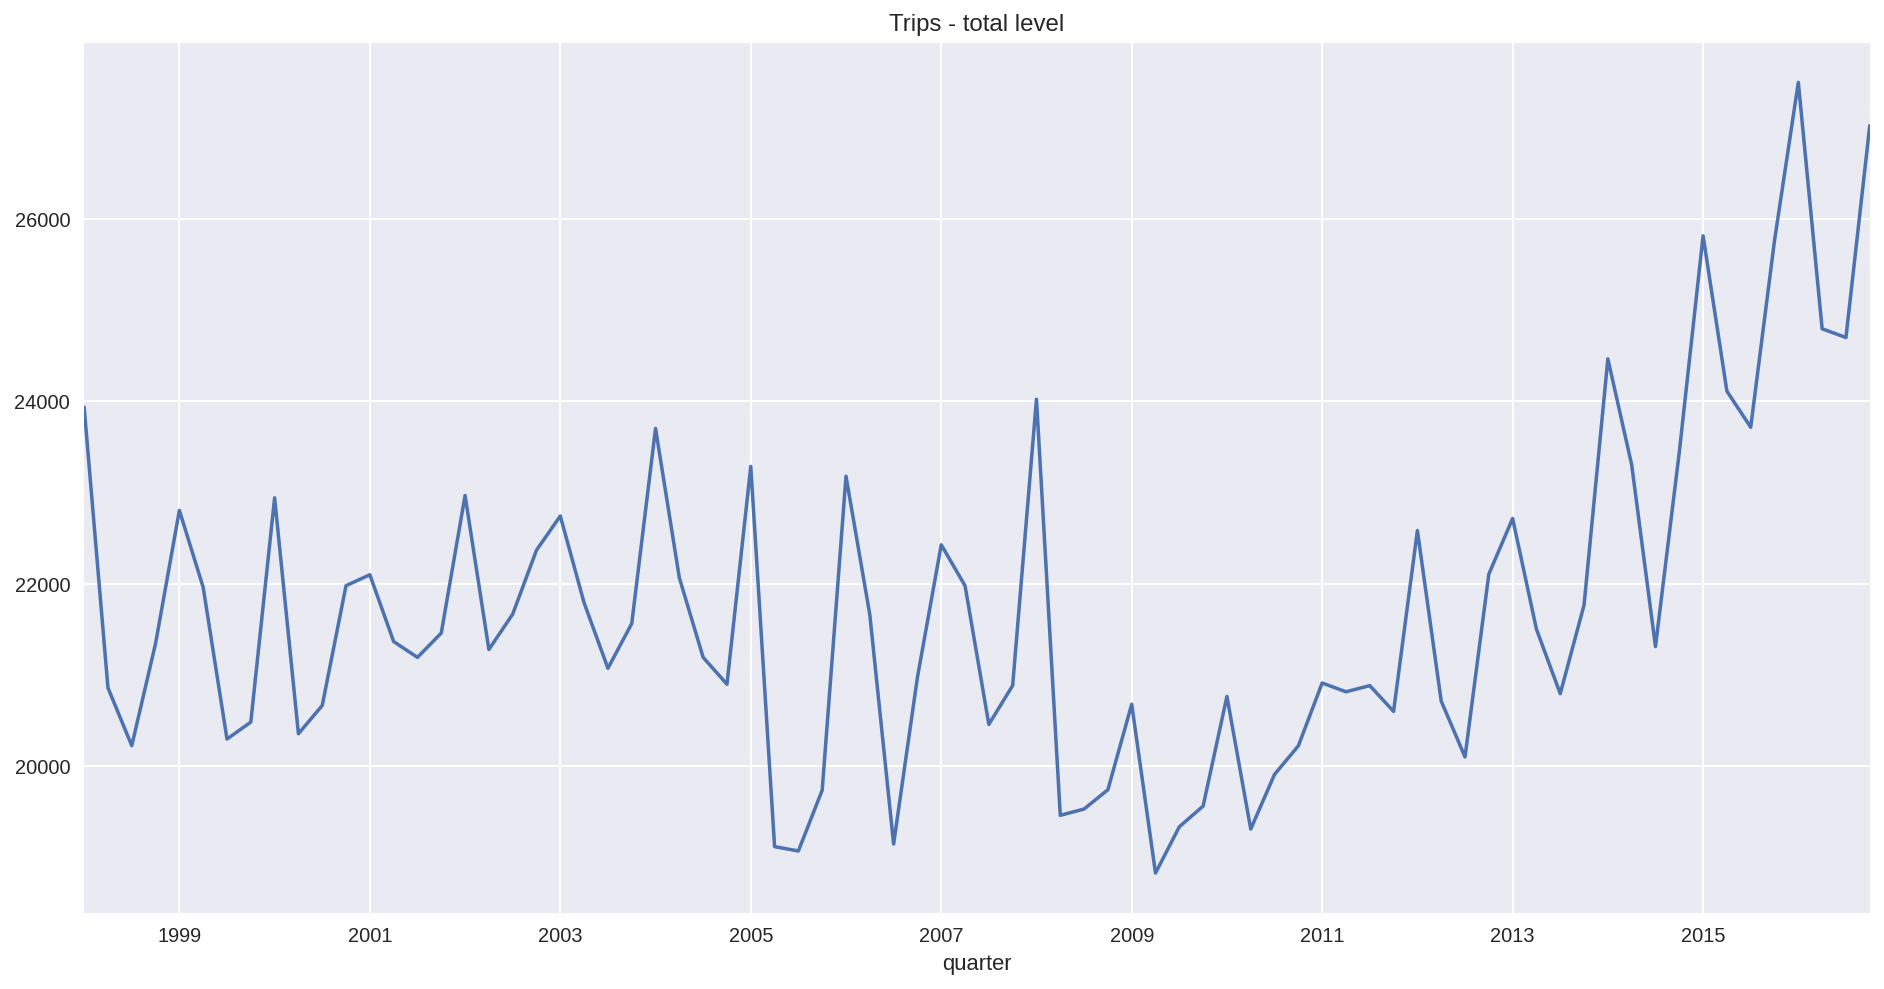

In [34]:
hierarchy_df["total"].plot(title="Trips - total level");

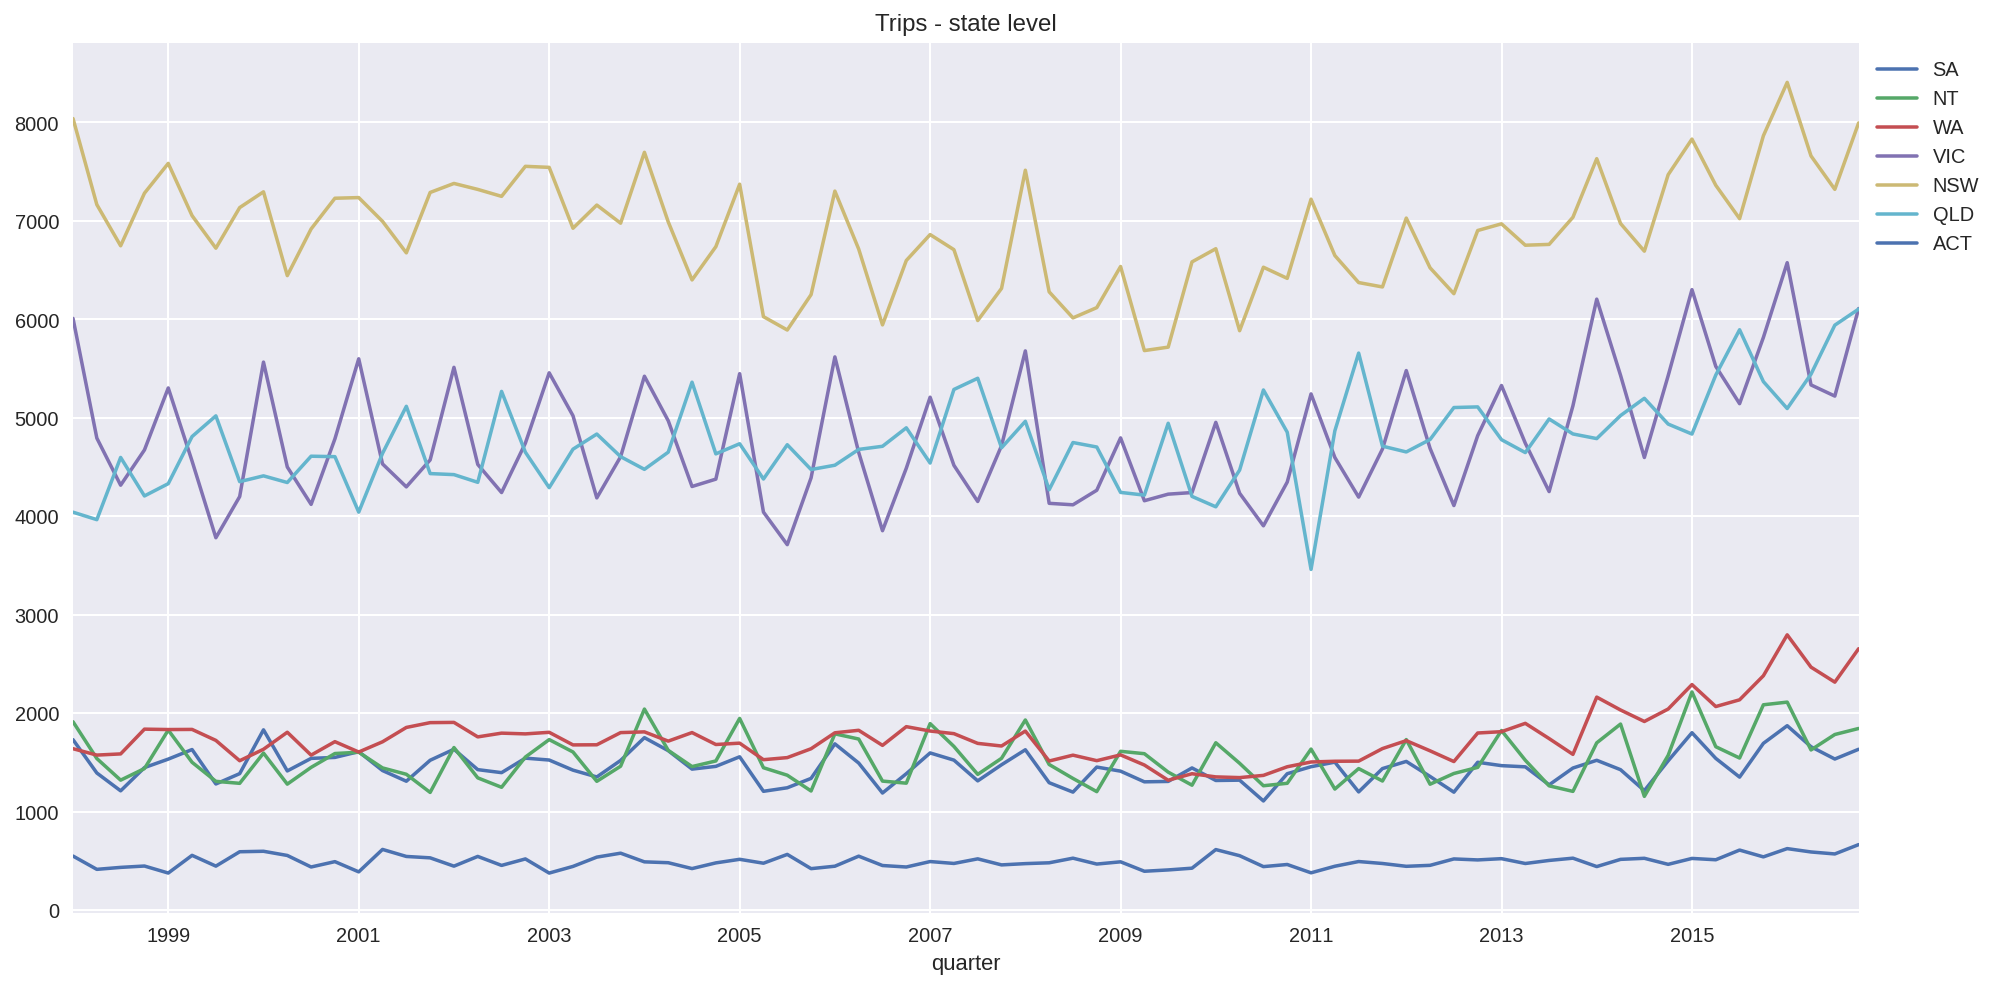

In [35]:
ax = hierarchy_df[hierarchy['total']].plot(title="Trips - state level")
ax.legend(bbox_to_anchor=(1.0, 1.0));

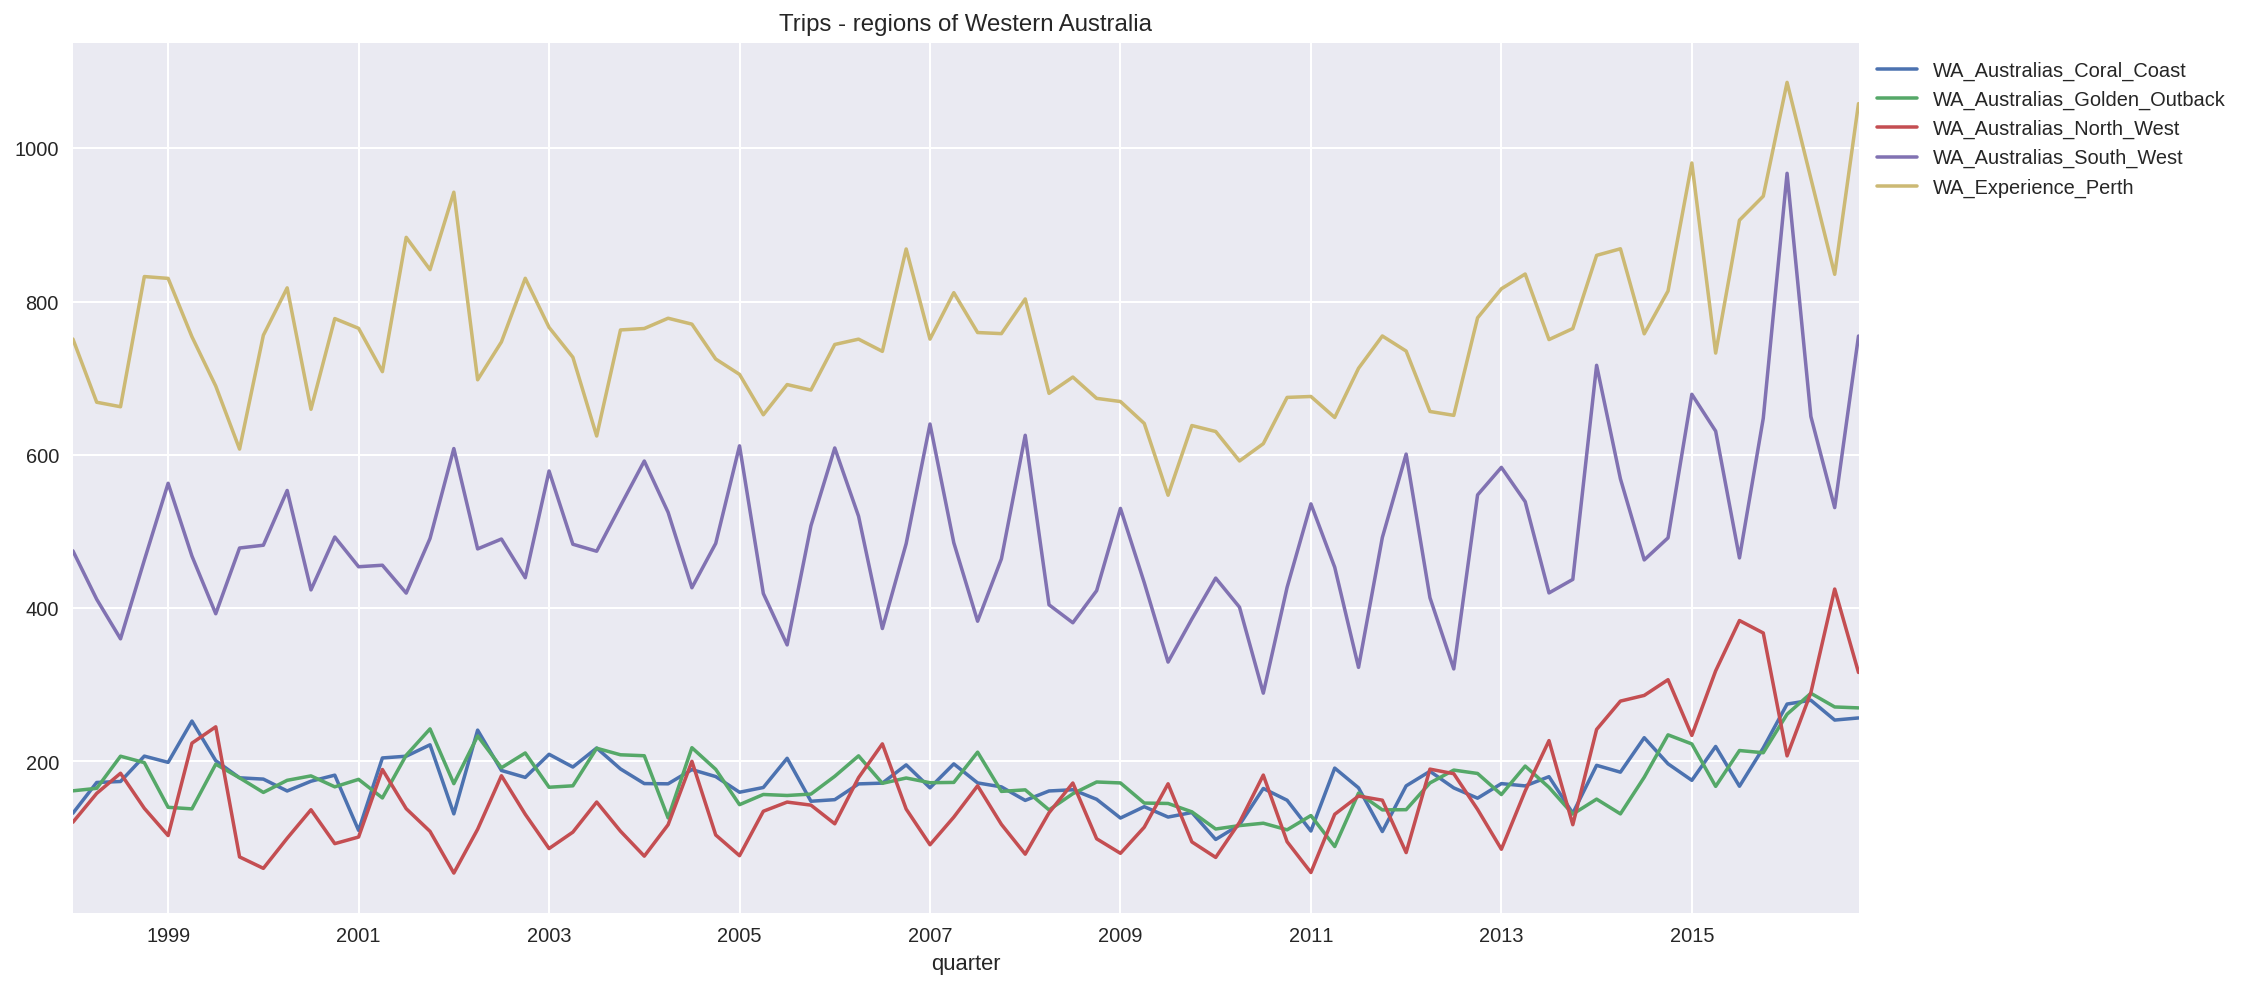

In [36]:
ax = hierarchy_df[hierarchy['WA']].plot(title="Trips - regions of Western Australia")
ax.legend(bbox_to_anchor=(1.0, 1.0));

#Hierarchical time series forecasting

In [37]:
def plot_results(pred_df, source_df, cols_to_plot):
    """
    Helper function used for displaying the predictions vs. actuals for the indicated columns
    """
    
    if type(cols_to_plot) == str:
        cols_to_plot = list(cols_to_plot)
        
    for col in cols_to_plot:
        fig, ax = plt.subplots()
        pred_df[col].plot(ax=ax, label="Predicted")
        source_df[col].plot(ax=ax, label="Observed")
        
        ax.legend()
        ax.set_title(col)
        ax.set_xlabel("Date")
        ax.set_ylabel("Trips");

## The bottom-up approach

In [41]:
from hts import HTSRegressor

In [62]:
pip install scikit-hts[auto_arima]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 58.5 MB/s eta 0:00:00


In [63]:
model_bu_arima = hts.HTSRegressor(model='auto_arima', revision_method='BU', n_jobs=0)
model_bu_arima = model_bu_arima.fit(hierarchy_df, hierarchy)
pred_bu_arima = model_bu_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 203.34it/s]


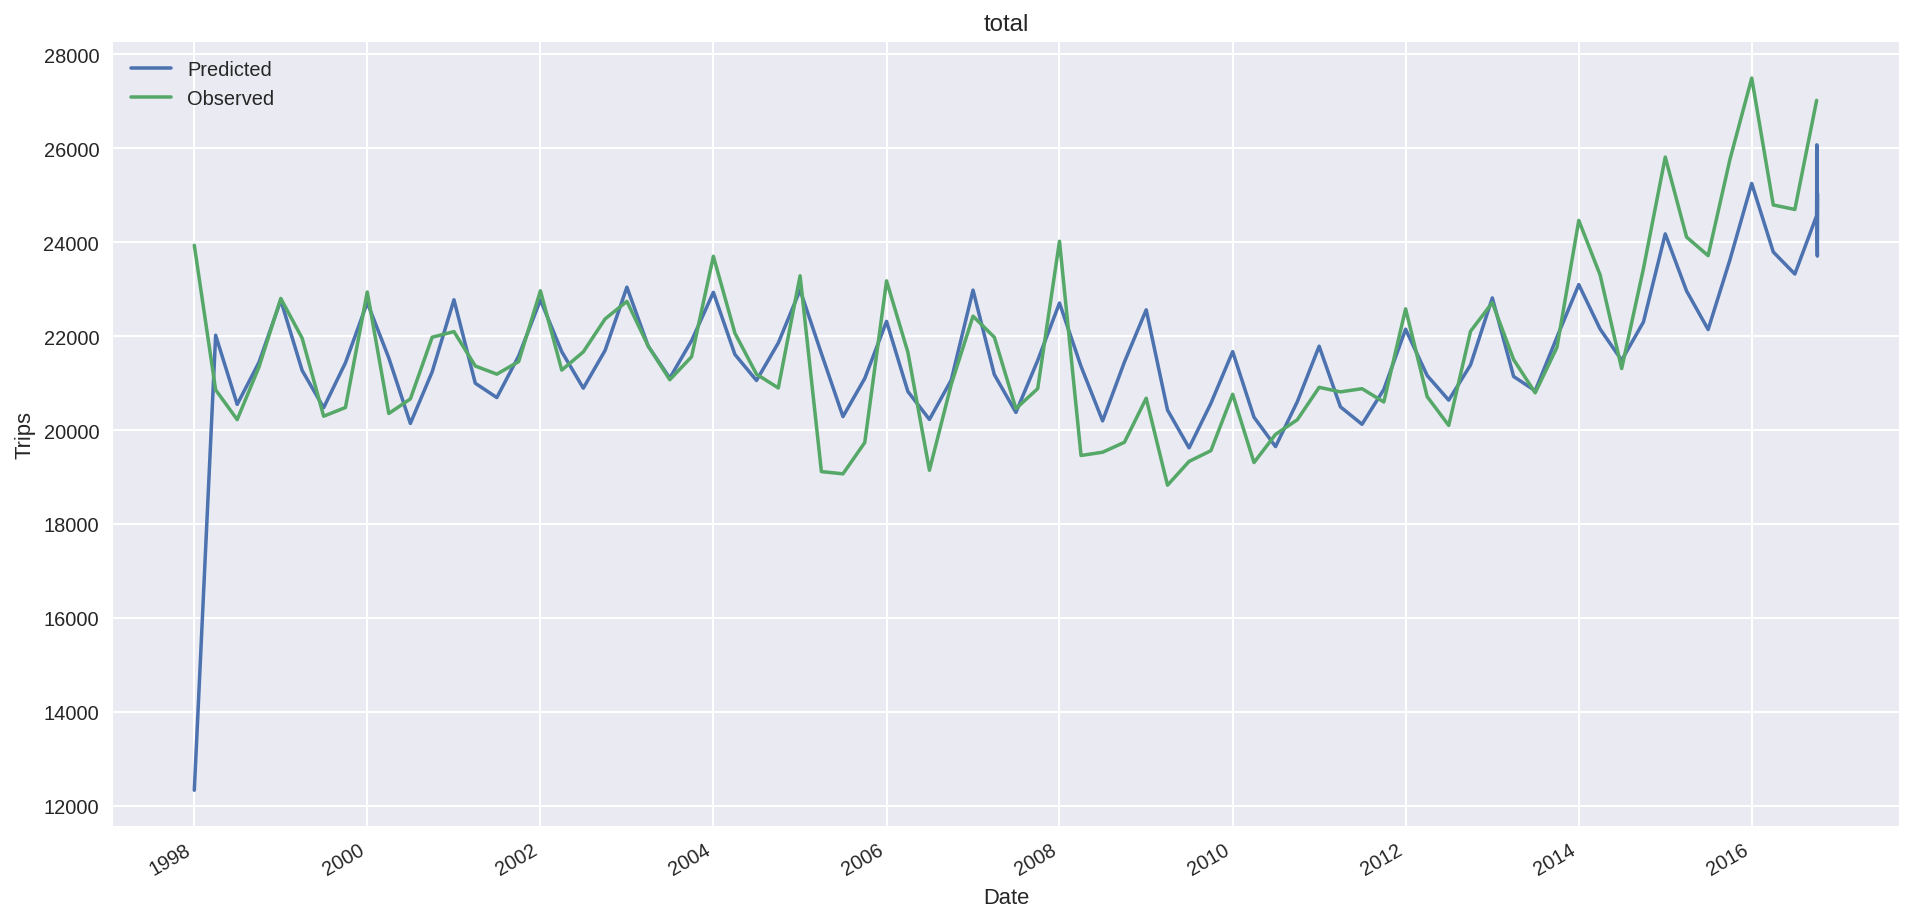

In [64]:
plot_results(pred_bu_arima, hierarchy_df, cols_to_plot=['total'])

In [65]:
pip install scikit-hts[prophet]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 82.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for fbprophet
  Running setup.py clean for fbprophet
  Created wheel for pystan: filename=pystan-2.19.1.1-cp39-cp39-linux_x86_64.whl size=61826295 sha256=5a642d26e4eec7bcff9c4c83999c36f234888d6d4a32ba45d4a990203f16576a
  Stored in directory: /root/.cache/pip/wheels/b8/36/bf/7ec7e363f796373cea3eb9ea94e83f5bbbb586d2edbf7e3417
Successfully built pystan
Failed to build fbprophet
  Attempting un

In [66]:
model_bu_prophet = hts.HTSRegressor(model='prophet', revision_method='BU', n_jobs=0)
model_bu_prophet = model_bu_prophet.fit(hierarchy_df, hierarchy)
pred_bu_prophet = model_bu_prophet.predict(steps_ahead=4)

Fitting models:   0%|          | 0/85 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/85 [00:01<02:40,  1.91s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/85 [00:03<02:17,  1.66s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   4%|▎         | 3/85 [00:05<02:26,  1.78s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

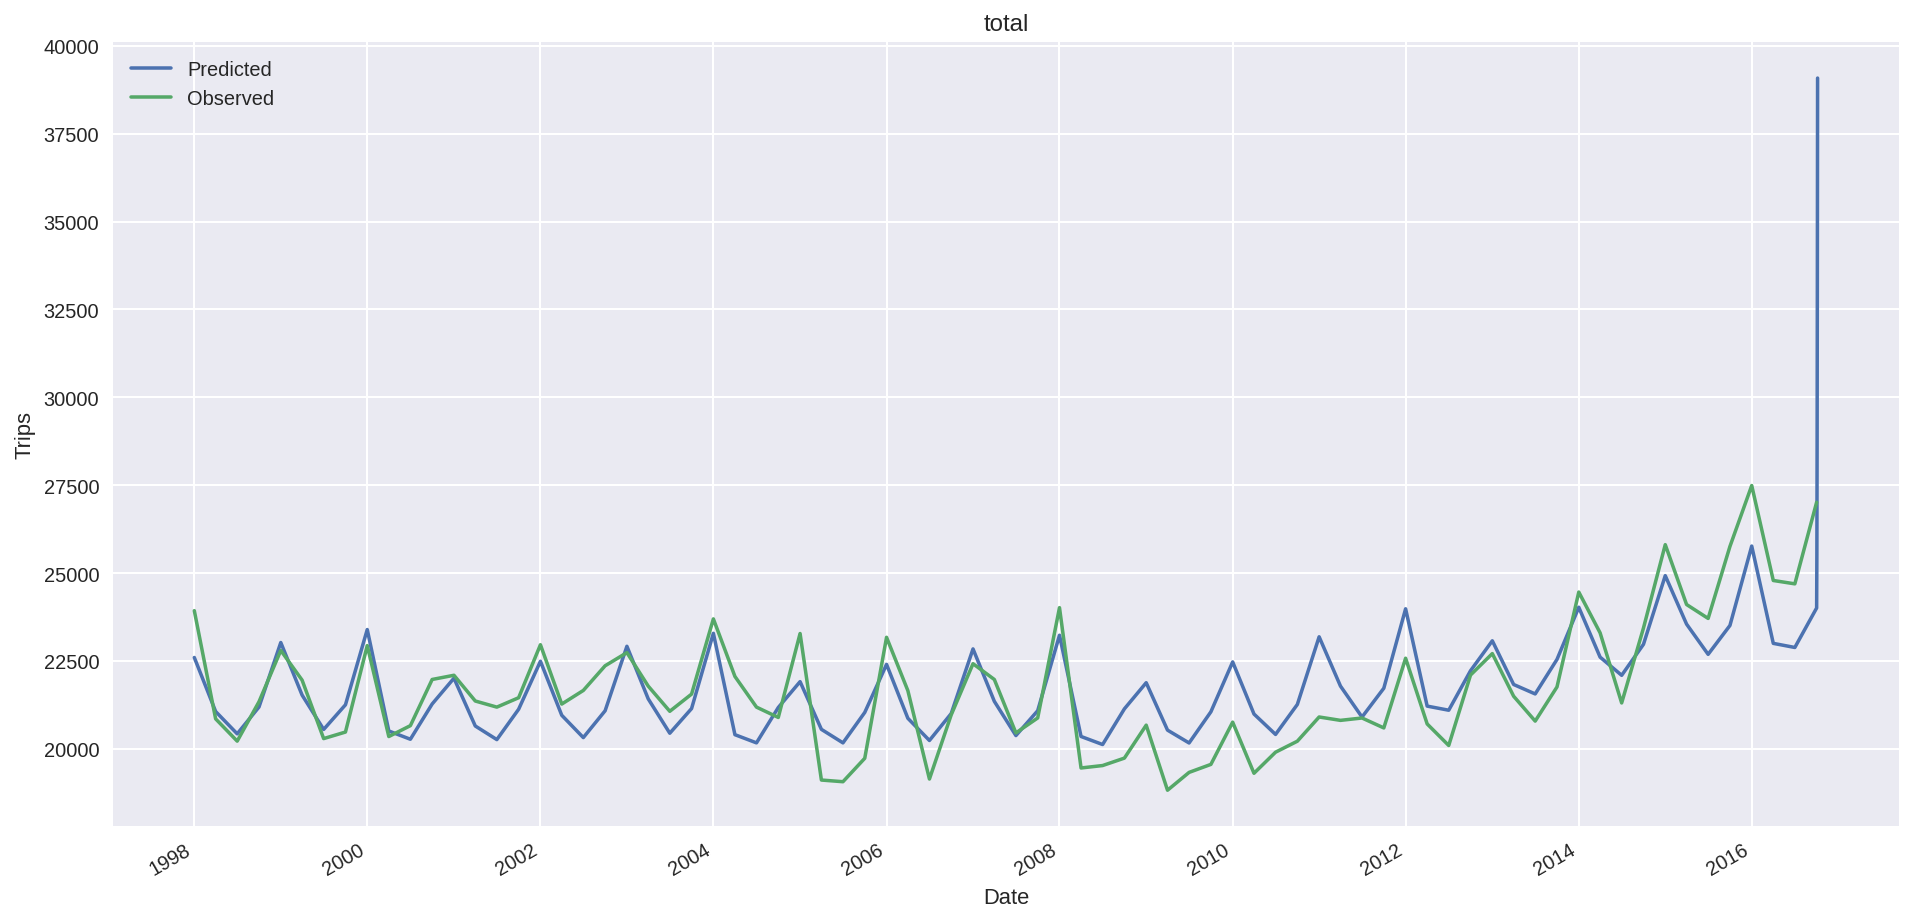

In [67]:
plot_results(pred_bu_prophet, hierarchy_df, cols_to_plot=['total'])

## The top-down approach

In [68]:
model_td_arima = hts.HTSRegressor(model='auto_arima', revision_method='AHP', n_jobs=0)
model_td_arima = model_td_arima.fit(hierarchy_df, hierarchy)
pred_td_arima = model_td_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 208.90it/s]


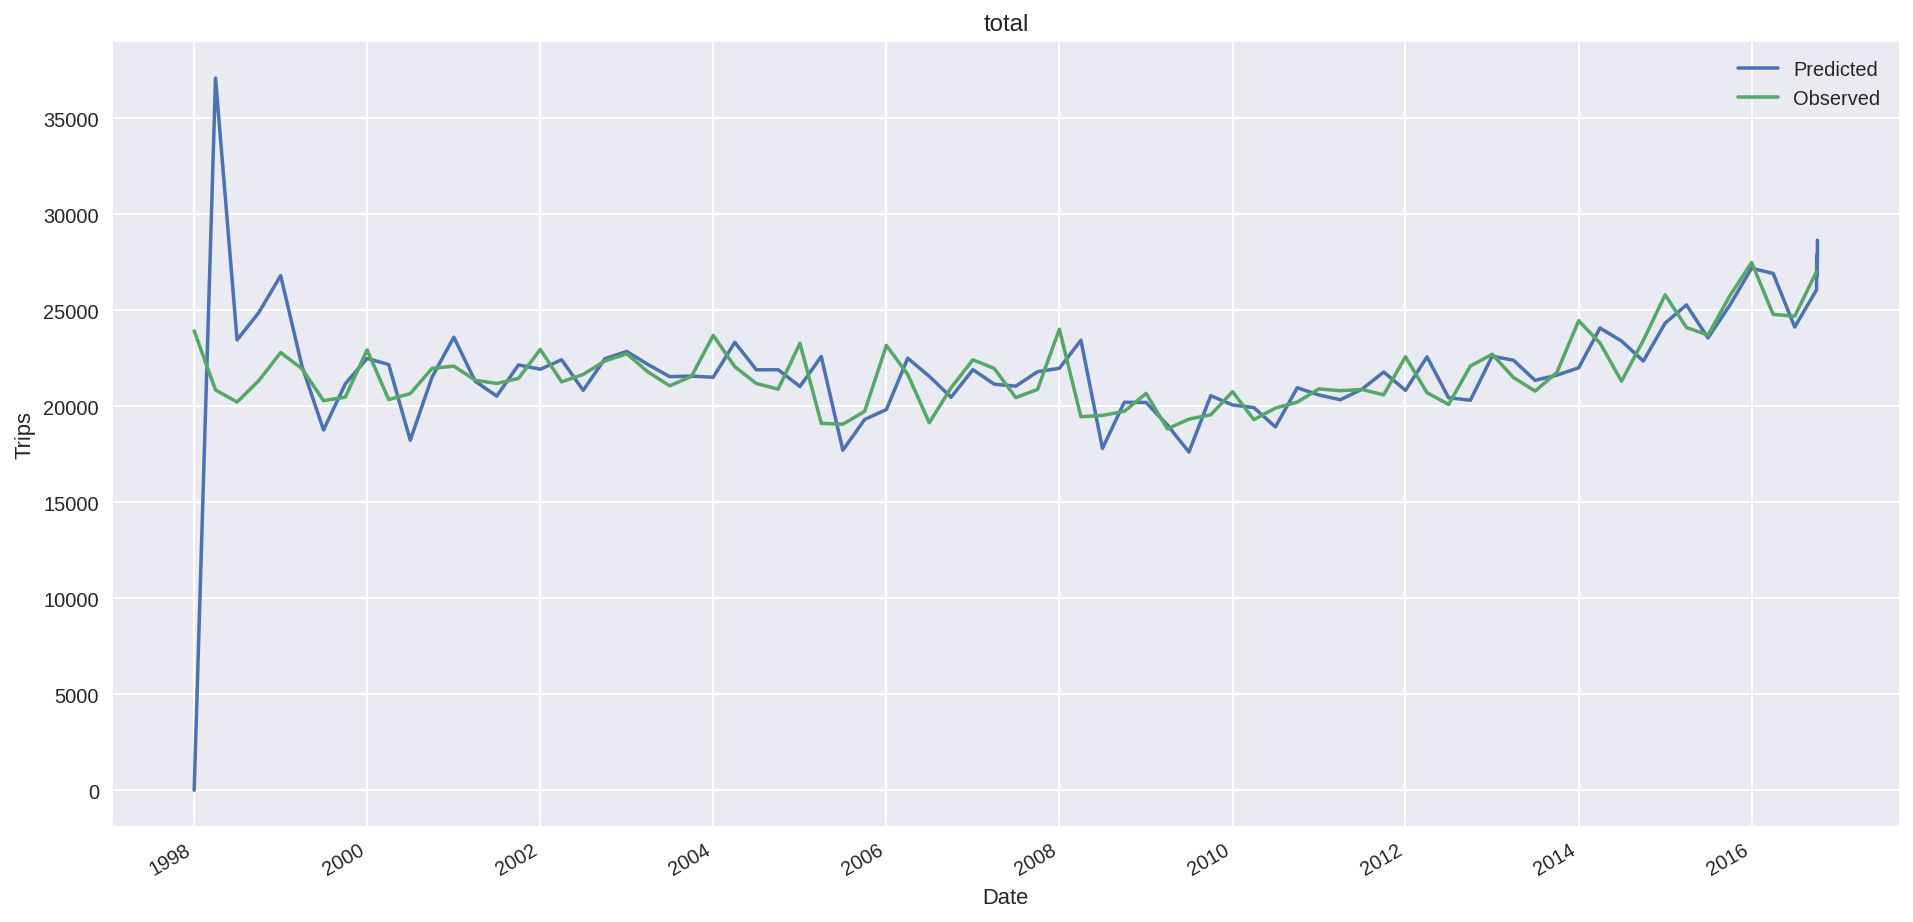

In [69]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['total'])

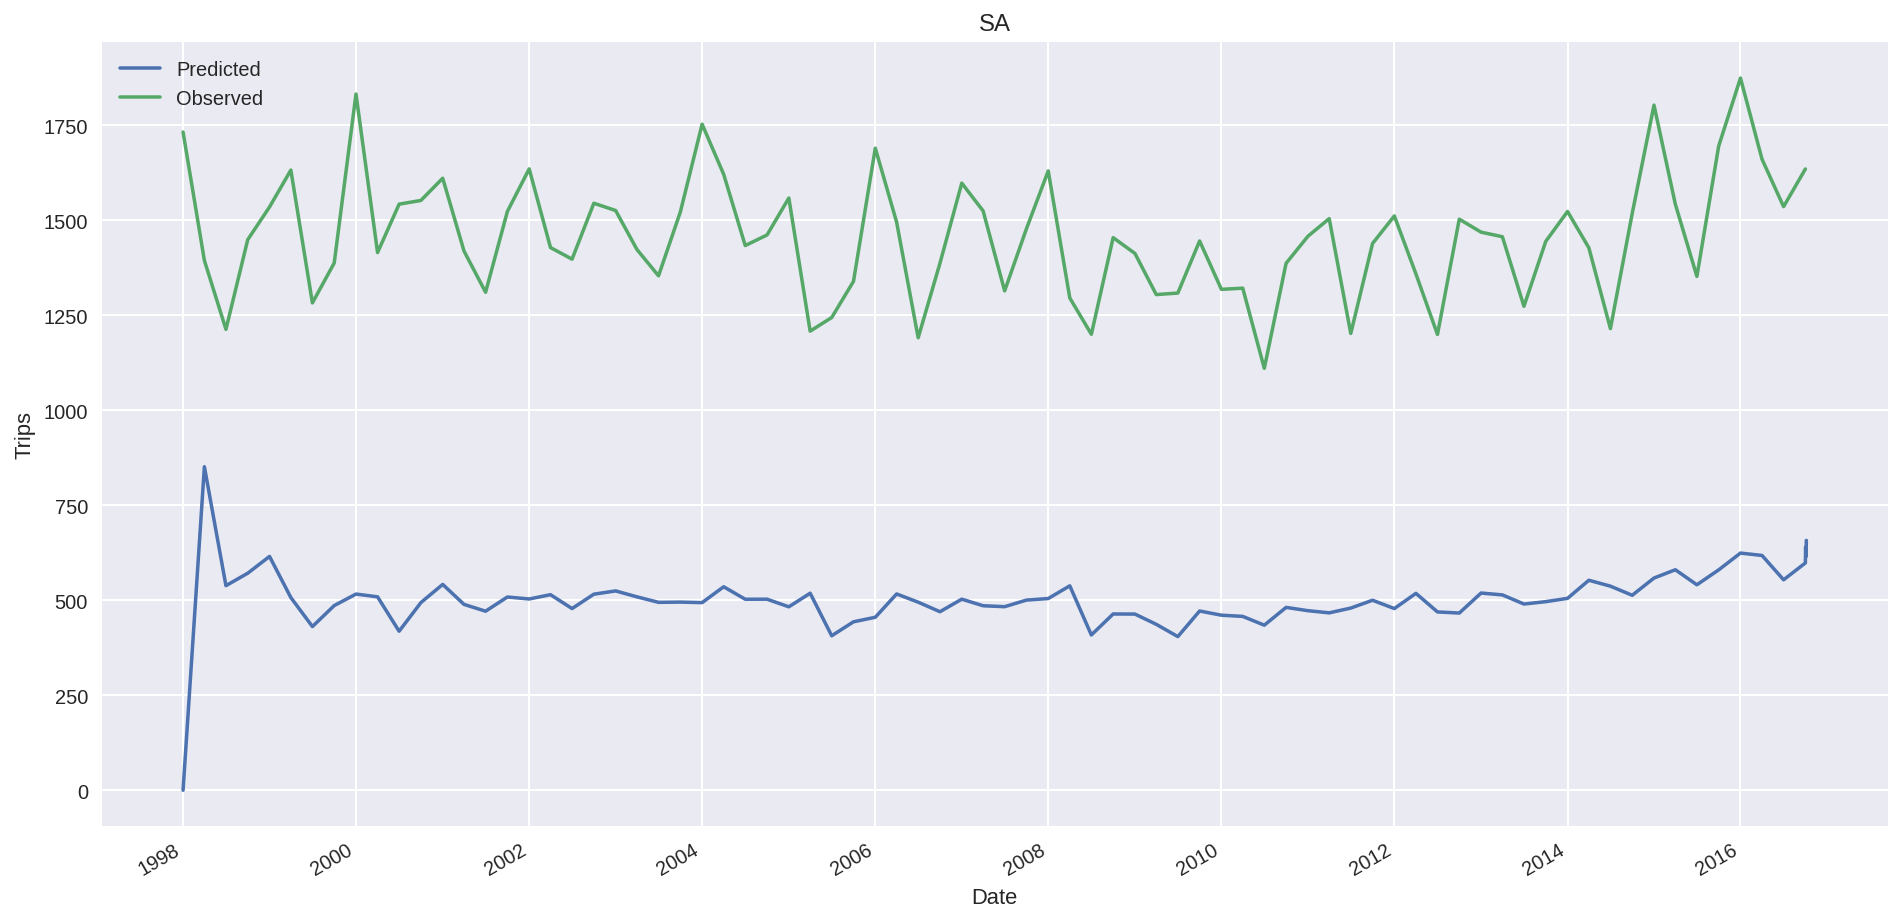

In [70]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['SA'])

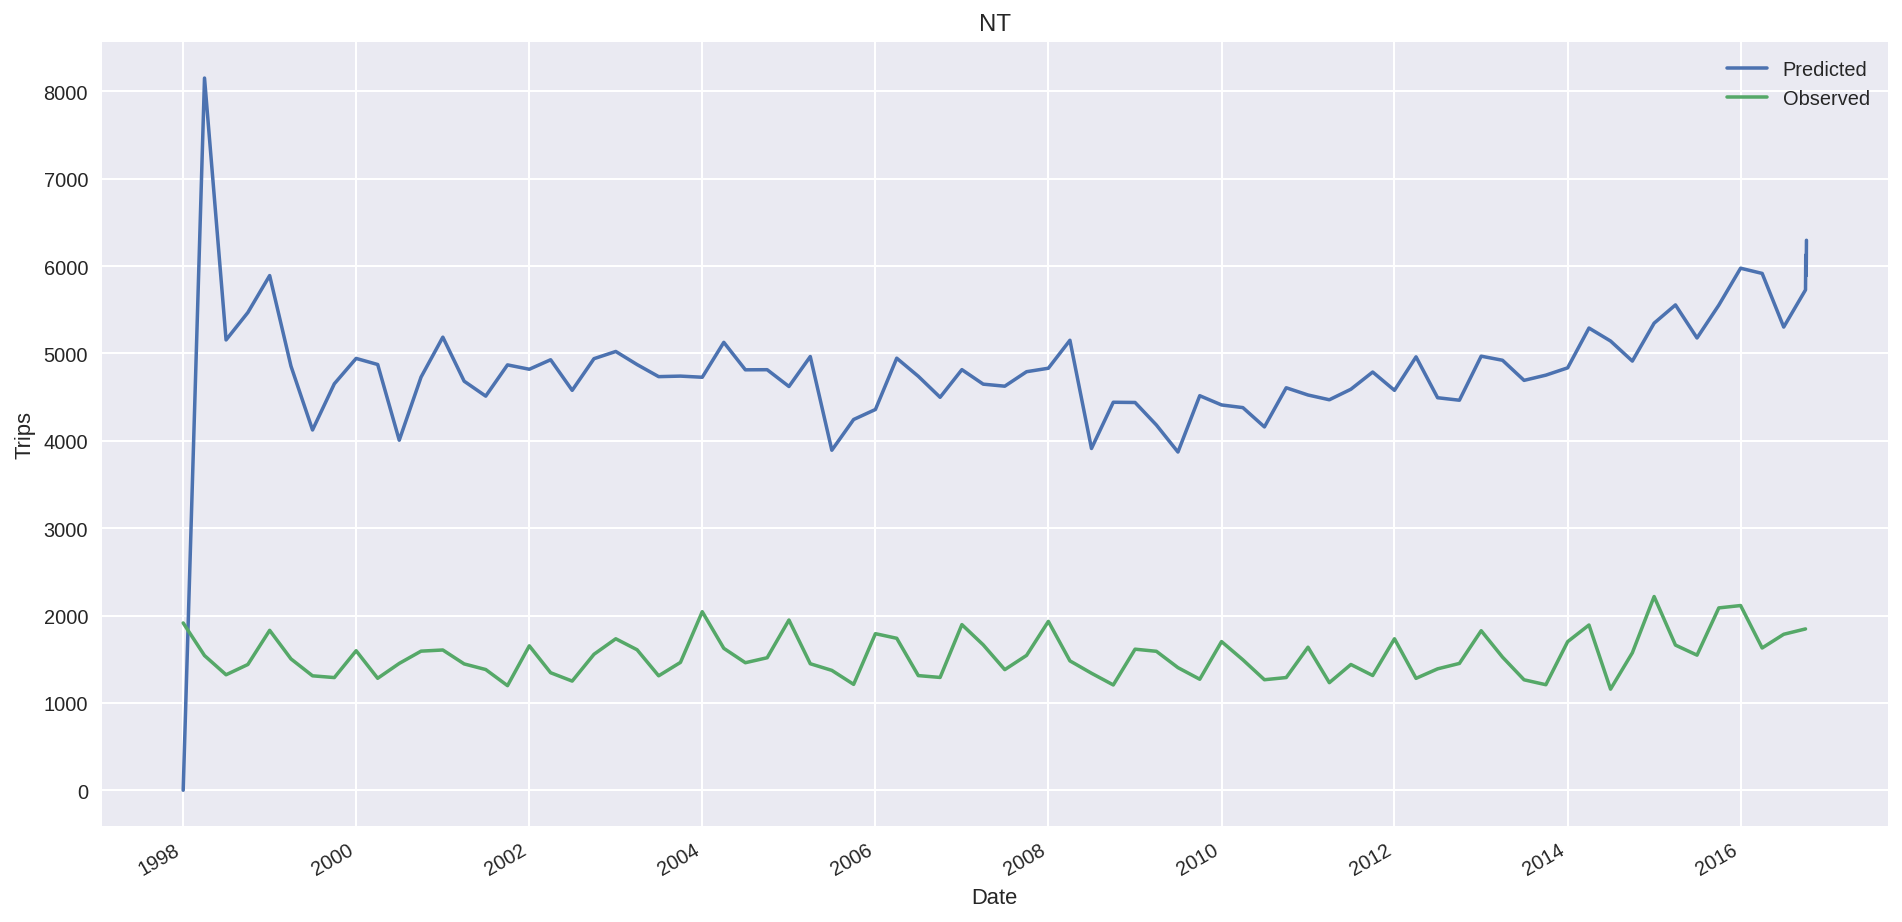

In [71]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['NT'])

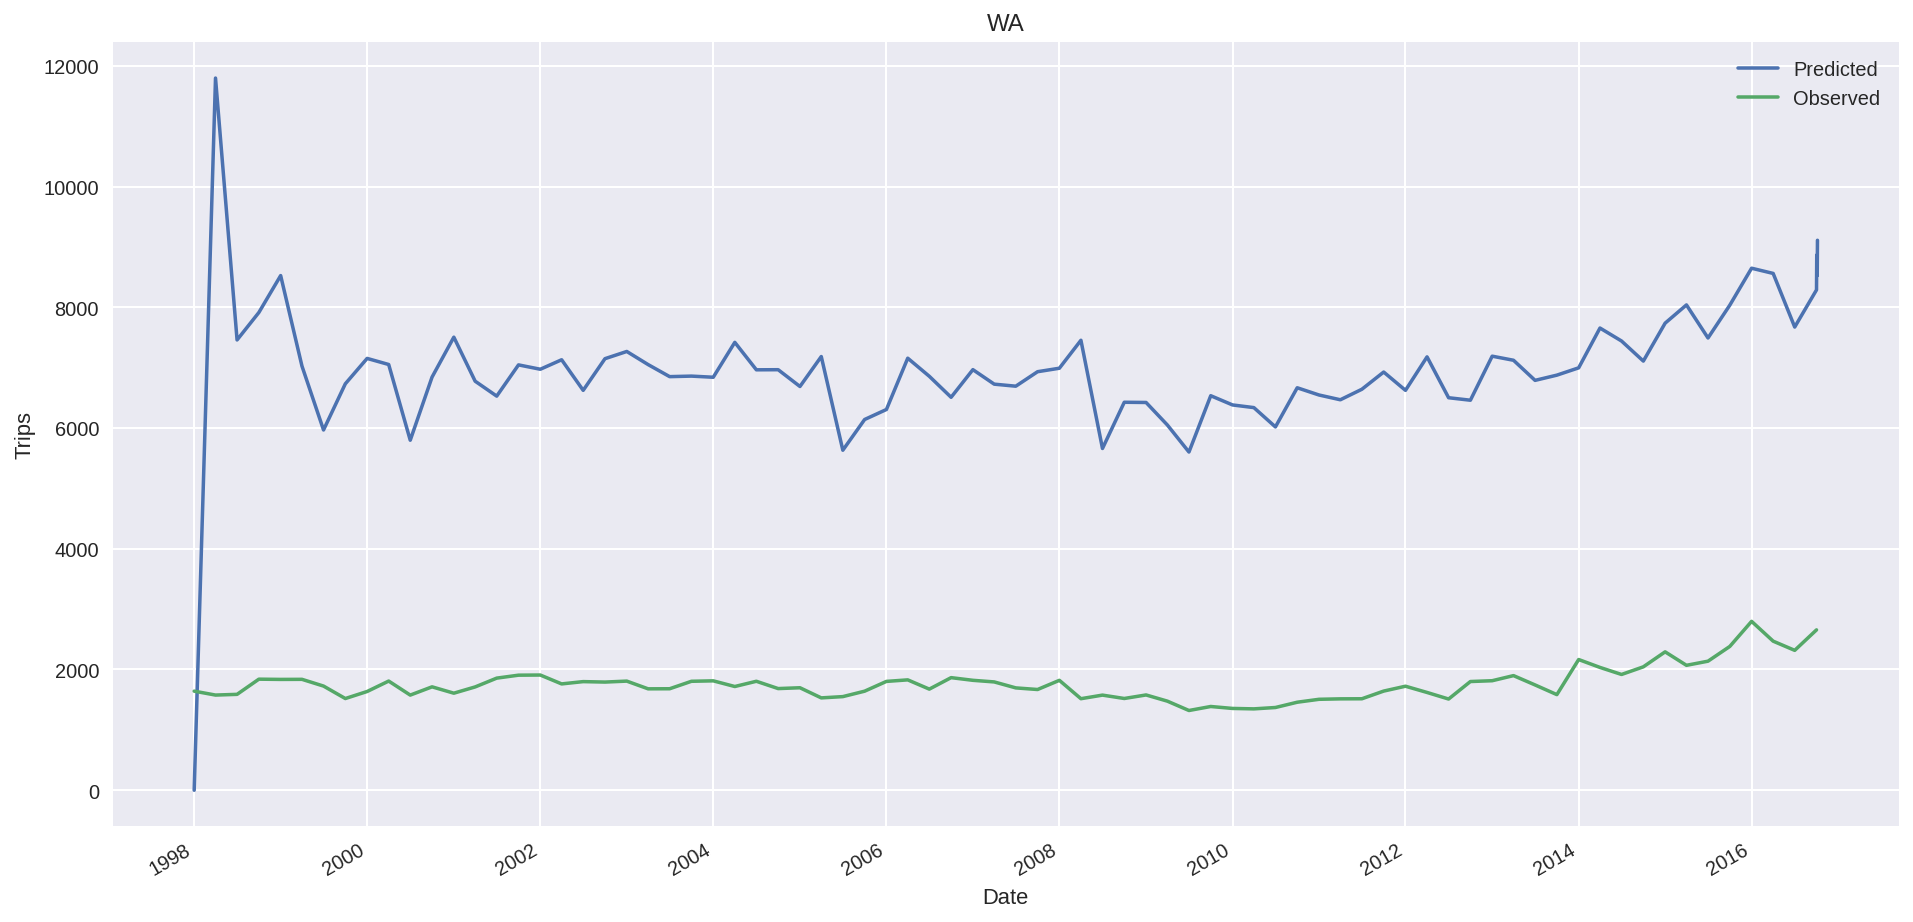

In [72]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['WA'])

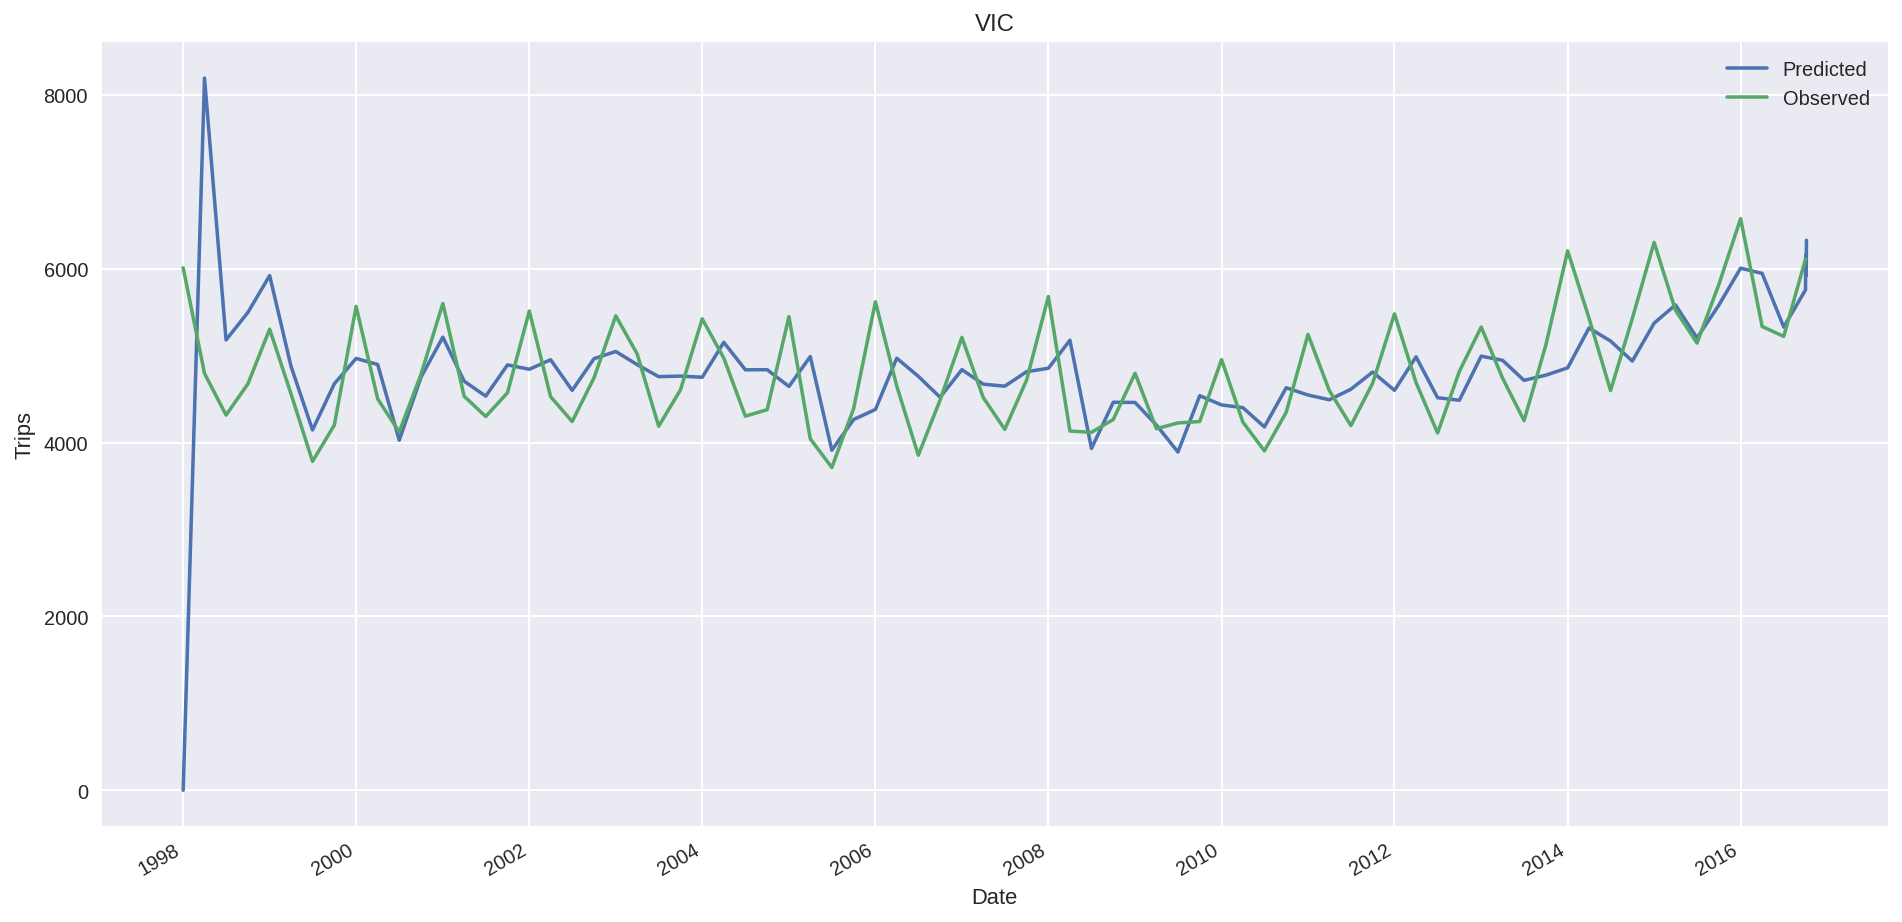

In [73]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['VIC'])

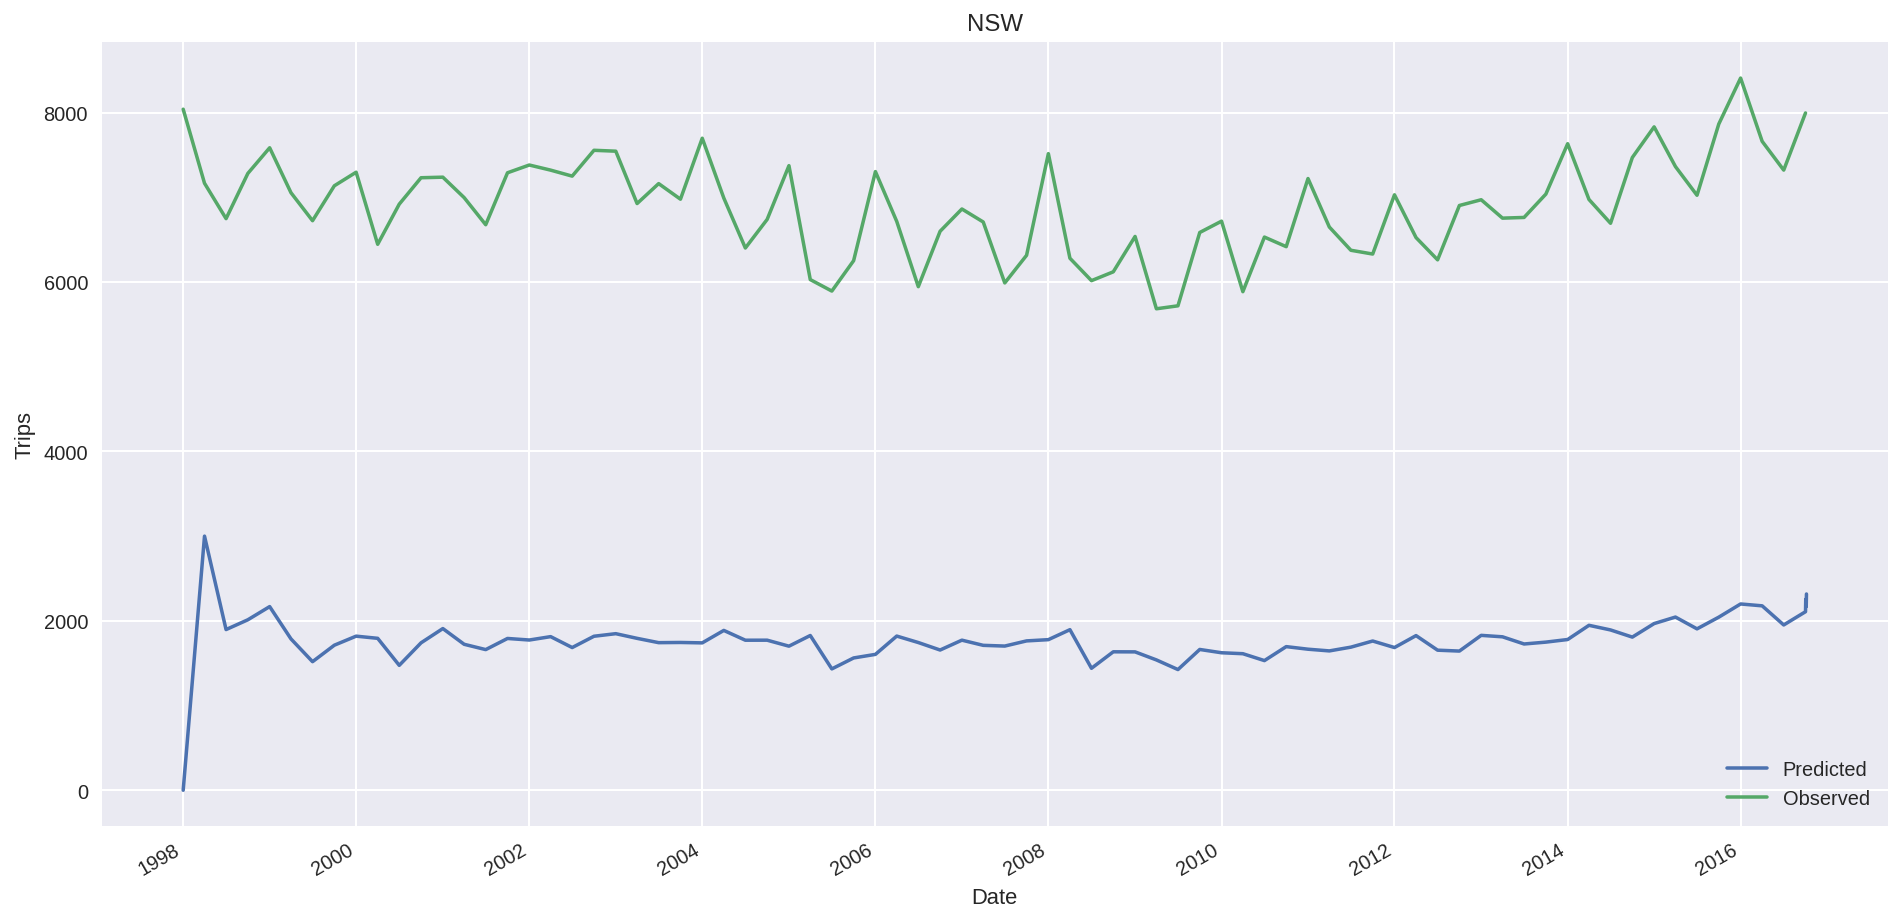

In [74]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['NSW'])

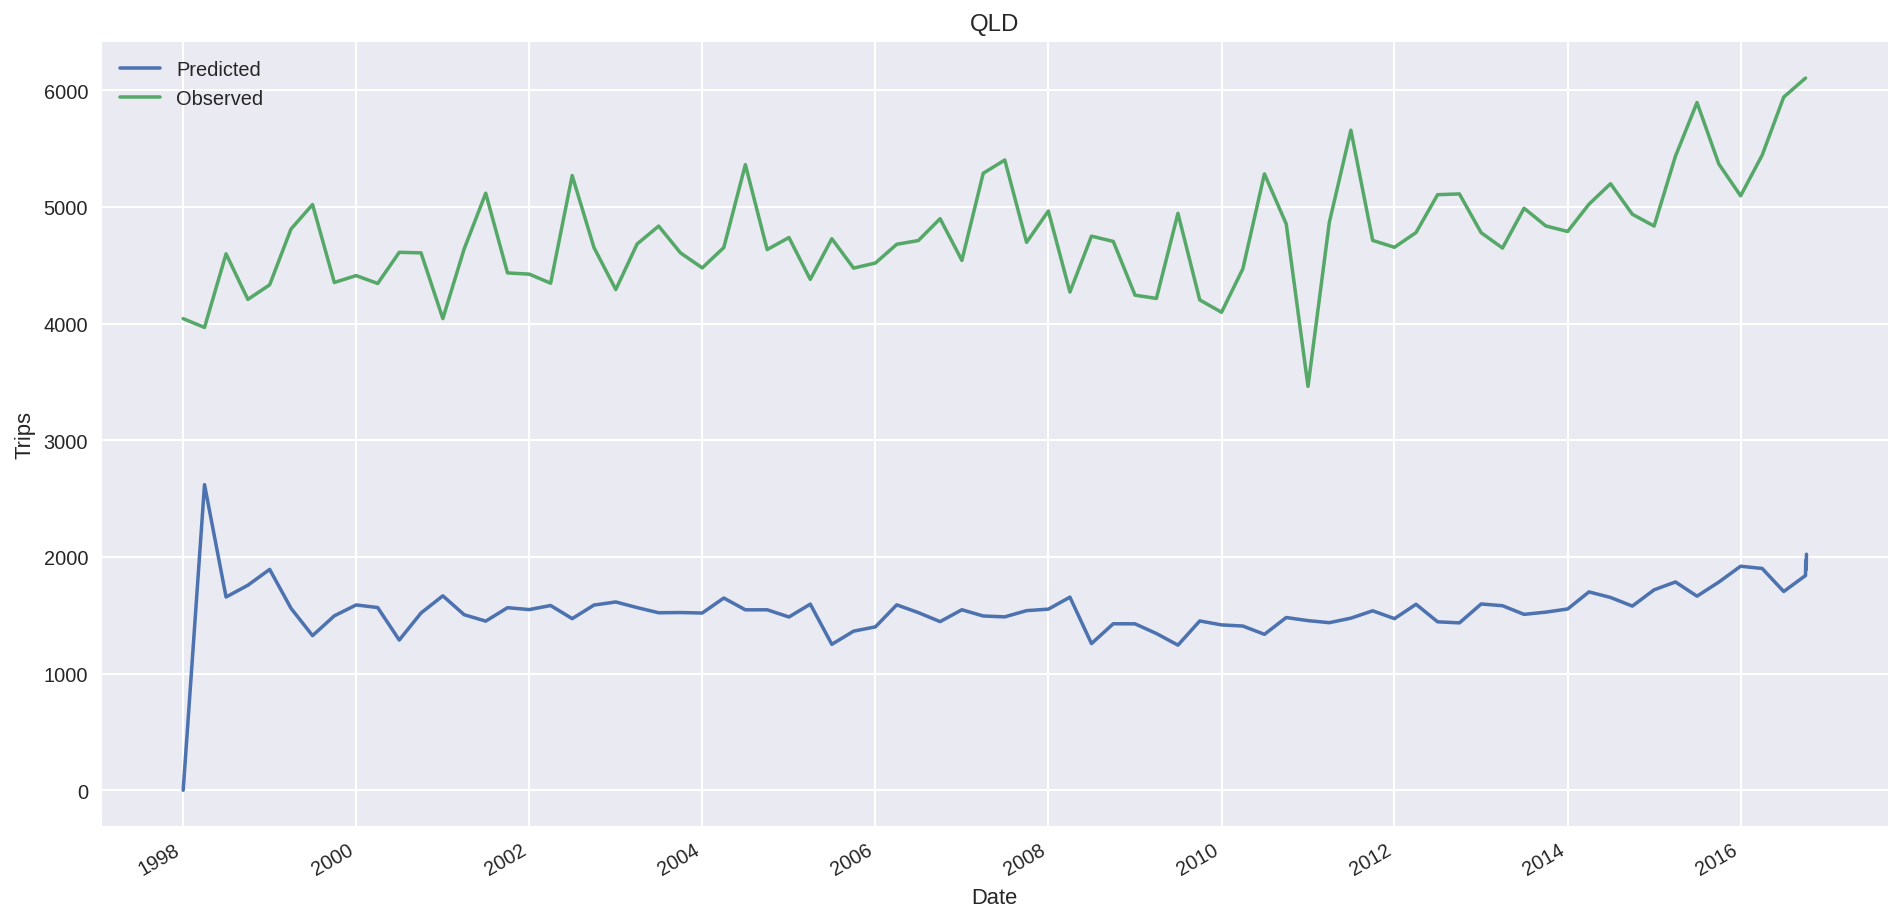

In [75]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['QLD'])

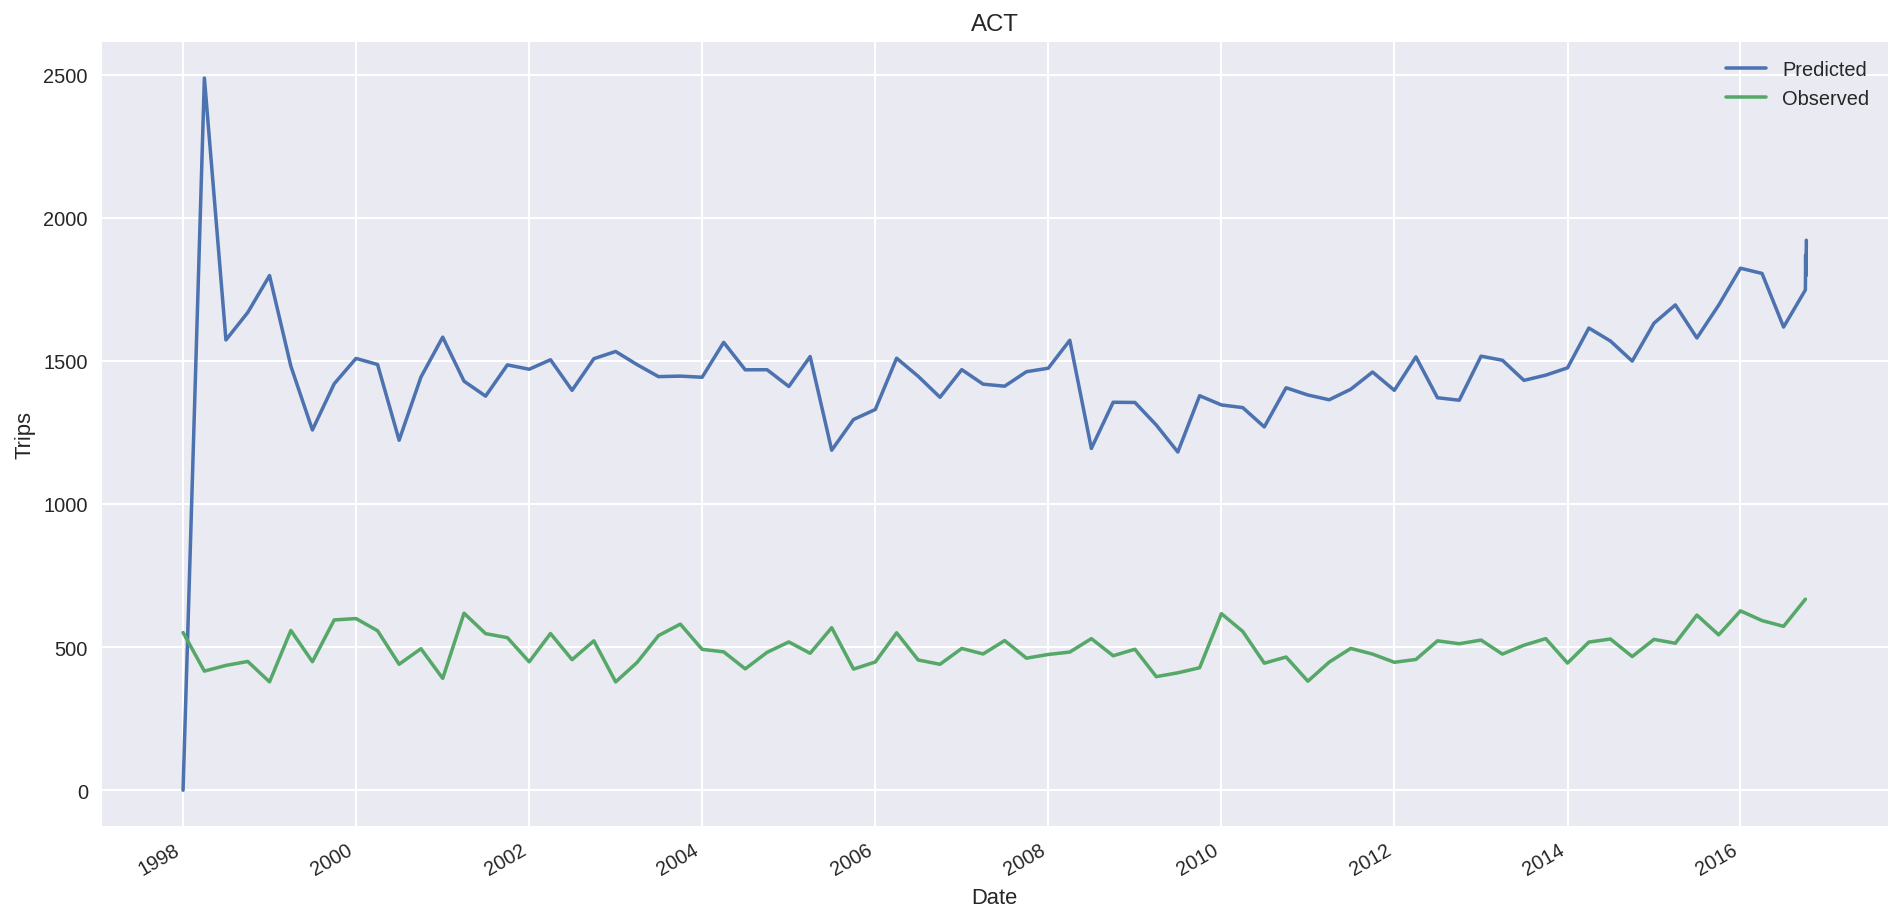

In [76]:
plot_results(pred_td_arima, hierarchy_df, cols_to_plot=['ACT'])

In [77]:
model_td_prophet = hts.HTSRegressor(model='prophet', revision_method='AHP', n_jobs=0)
model_td_prophet = model_td_prophet.fit(hierarchy_df, hierarchy)
pred_td_prophet = model_td_prophet.predict(steps_ahead=4)

Fitting models:   0%|          | 0/85 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/85 [00:01<01:26,  1.03s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/85 [00:01<01:17,  1.07it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   4%|▎         | 3/85 [00:03<01:25,  1.04s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

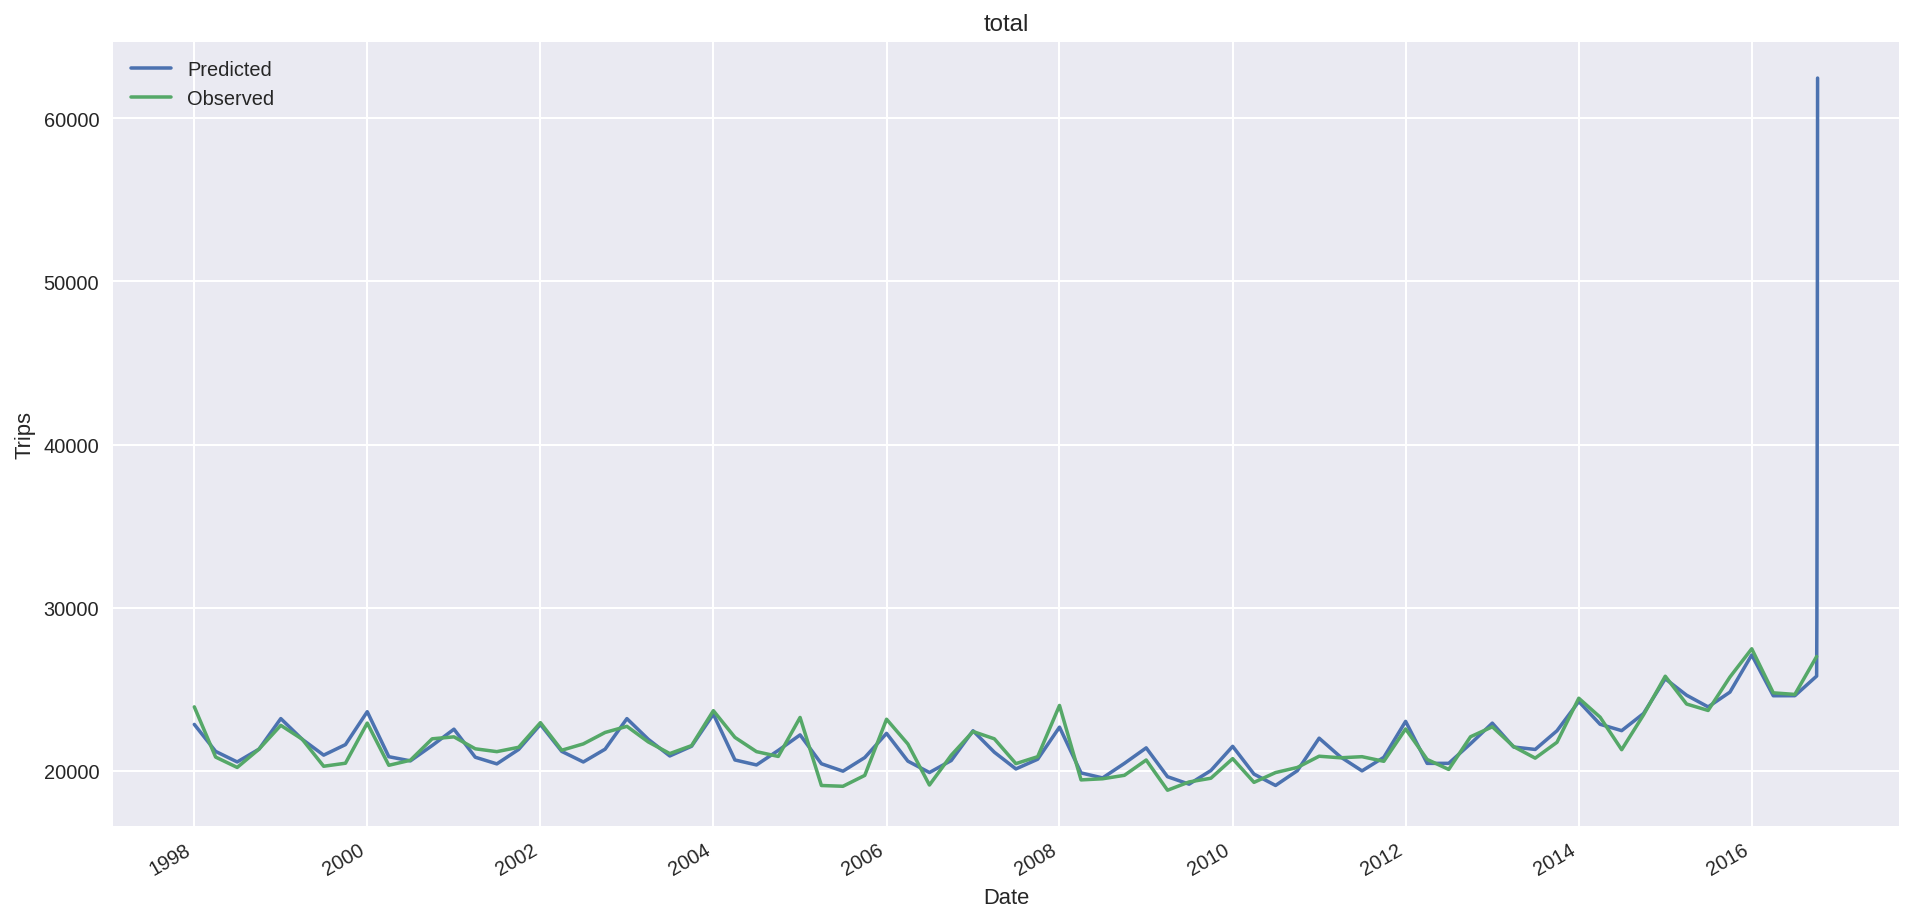

In [78]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['total'])

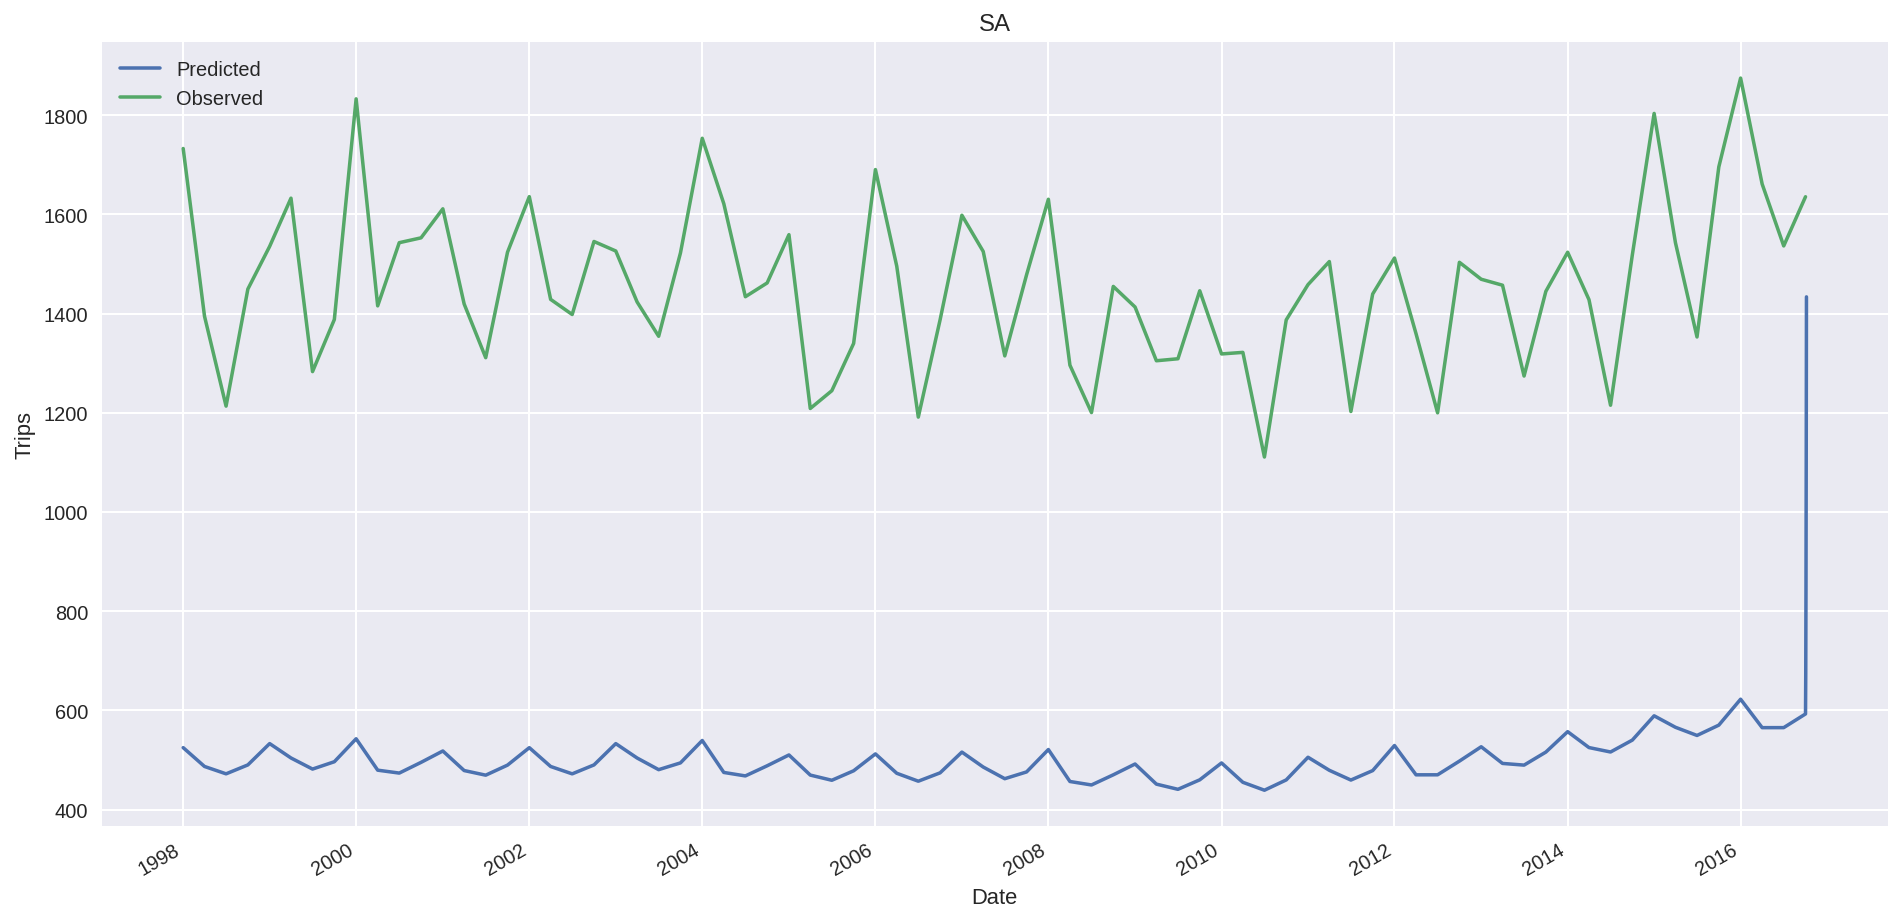

In [79]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['SA'])

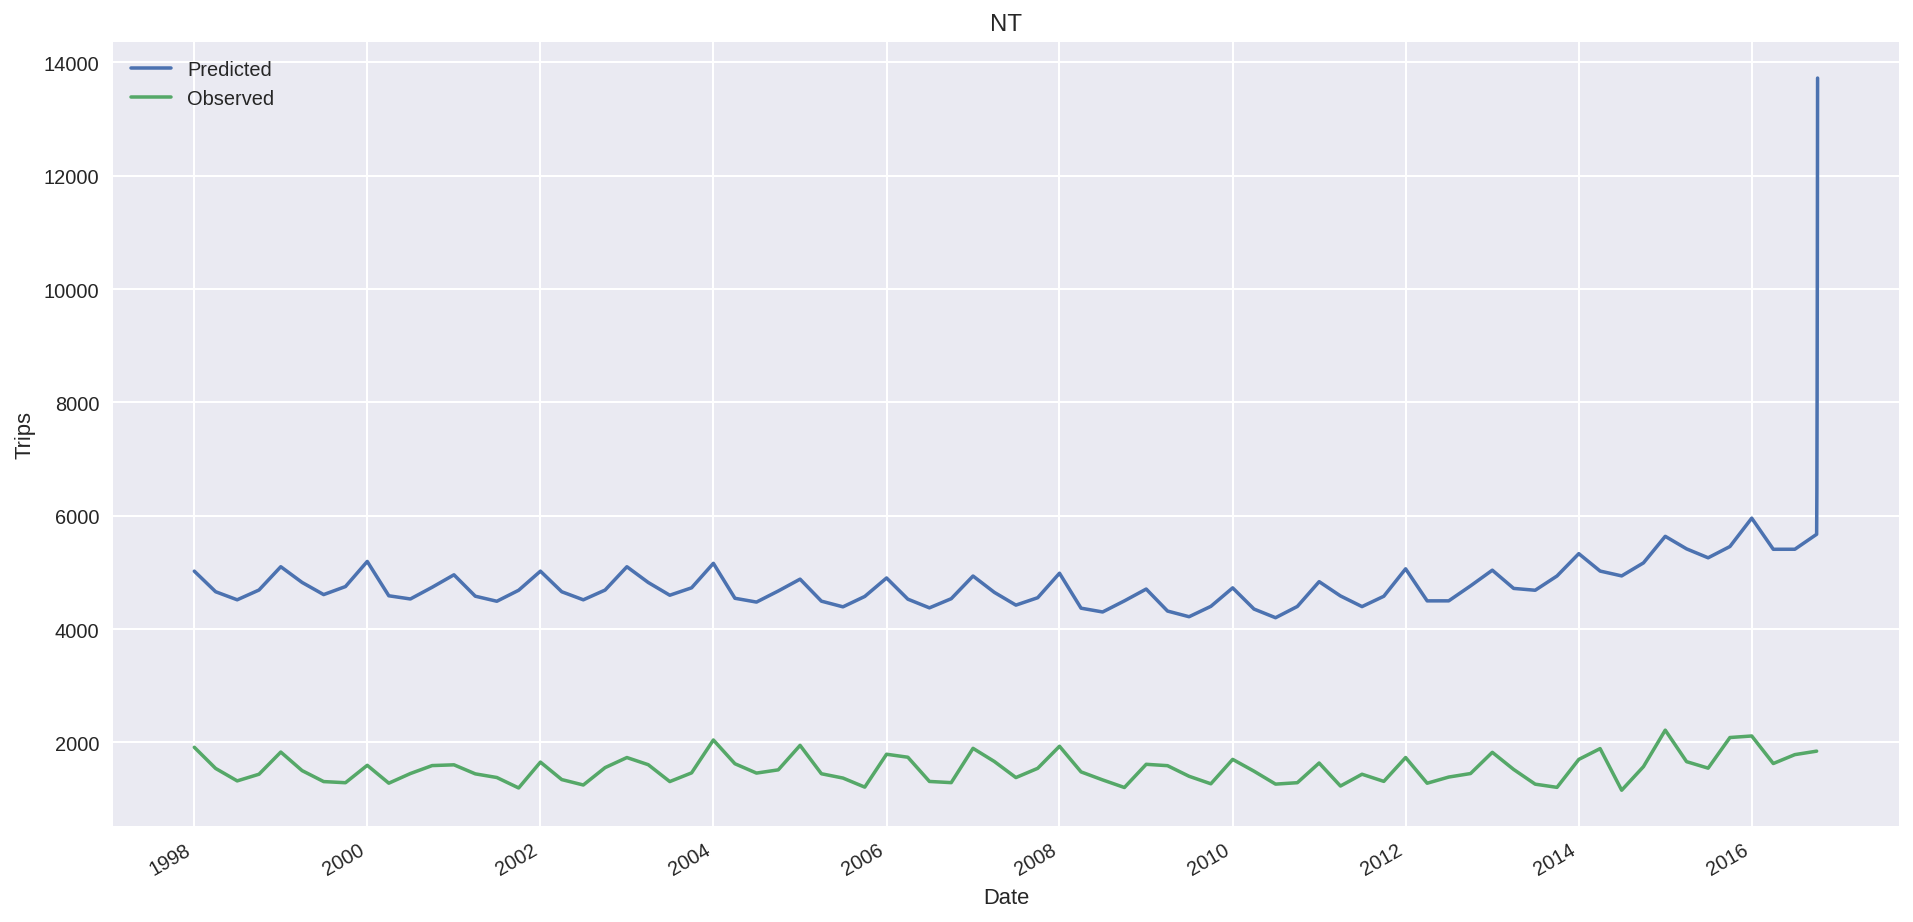

In [80]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['NT'])

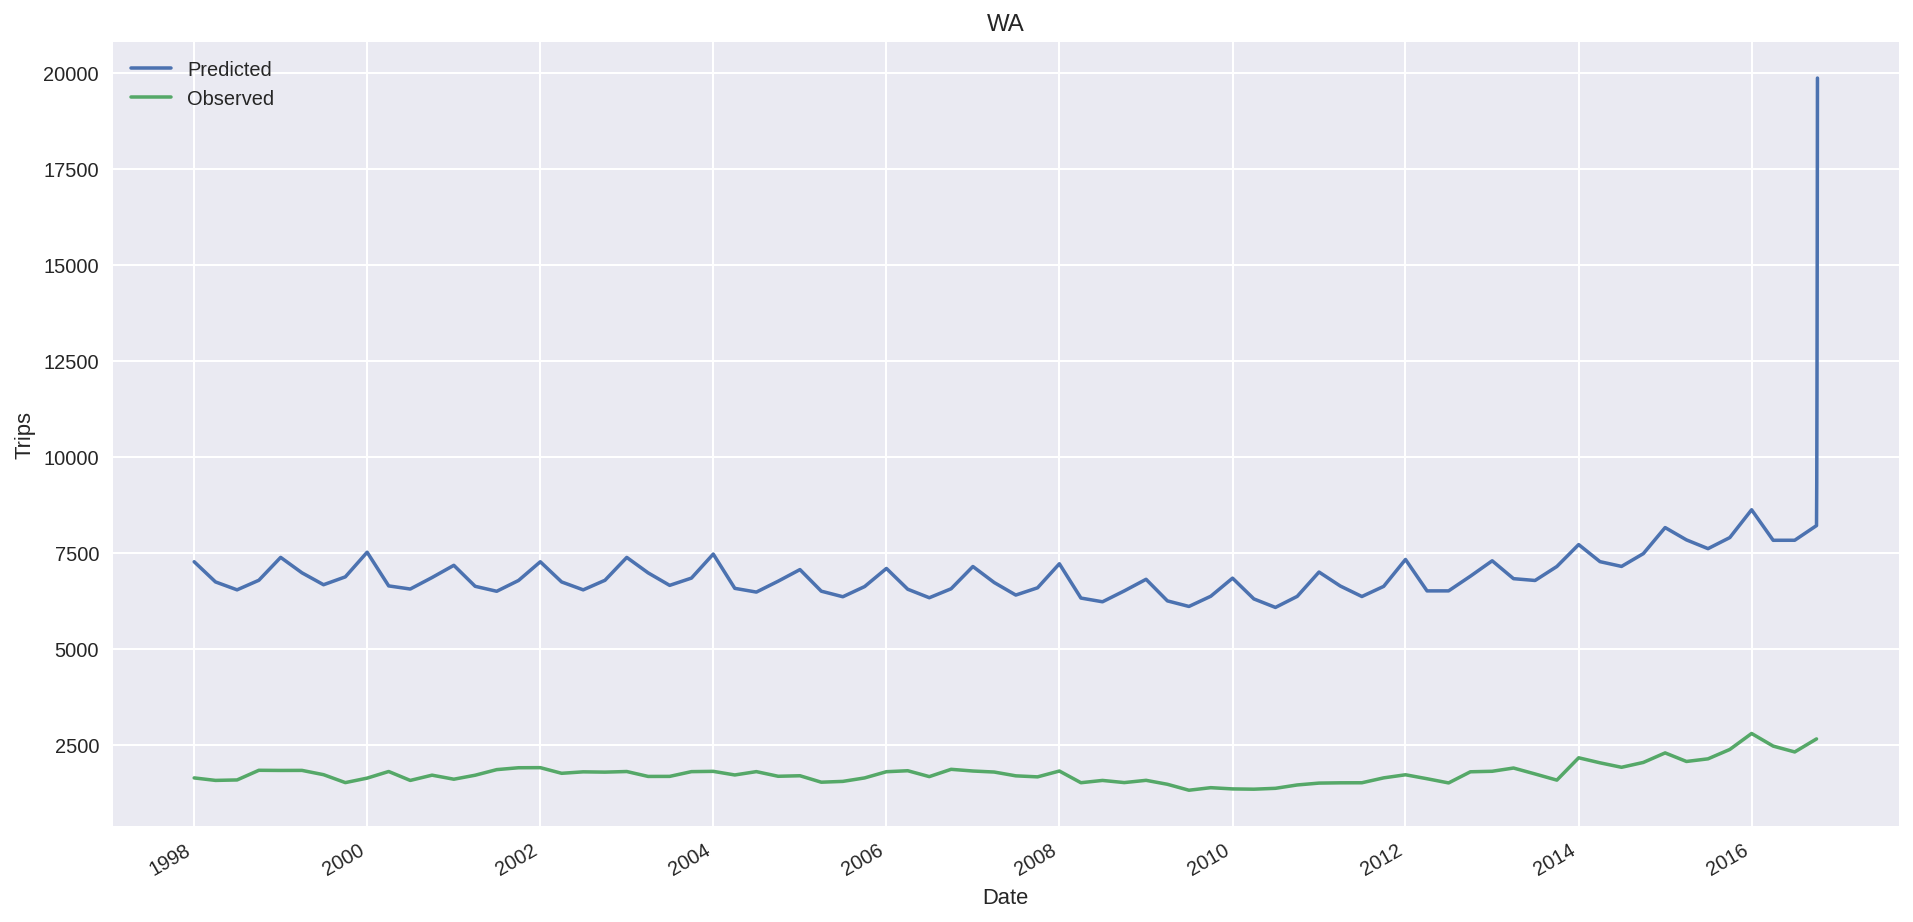

In [81]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['WA'])

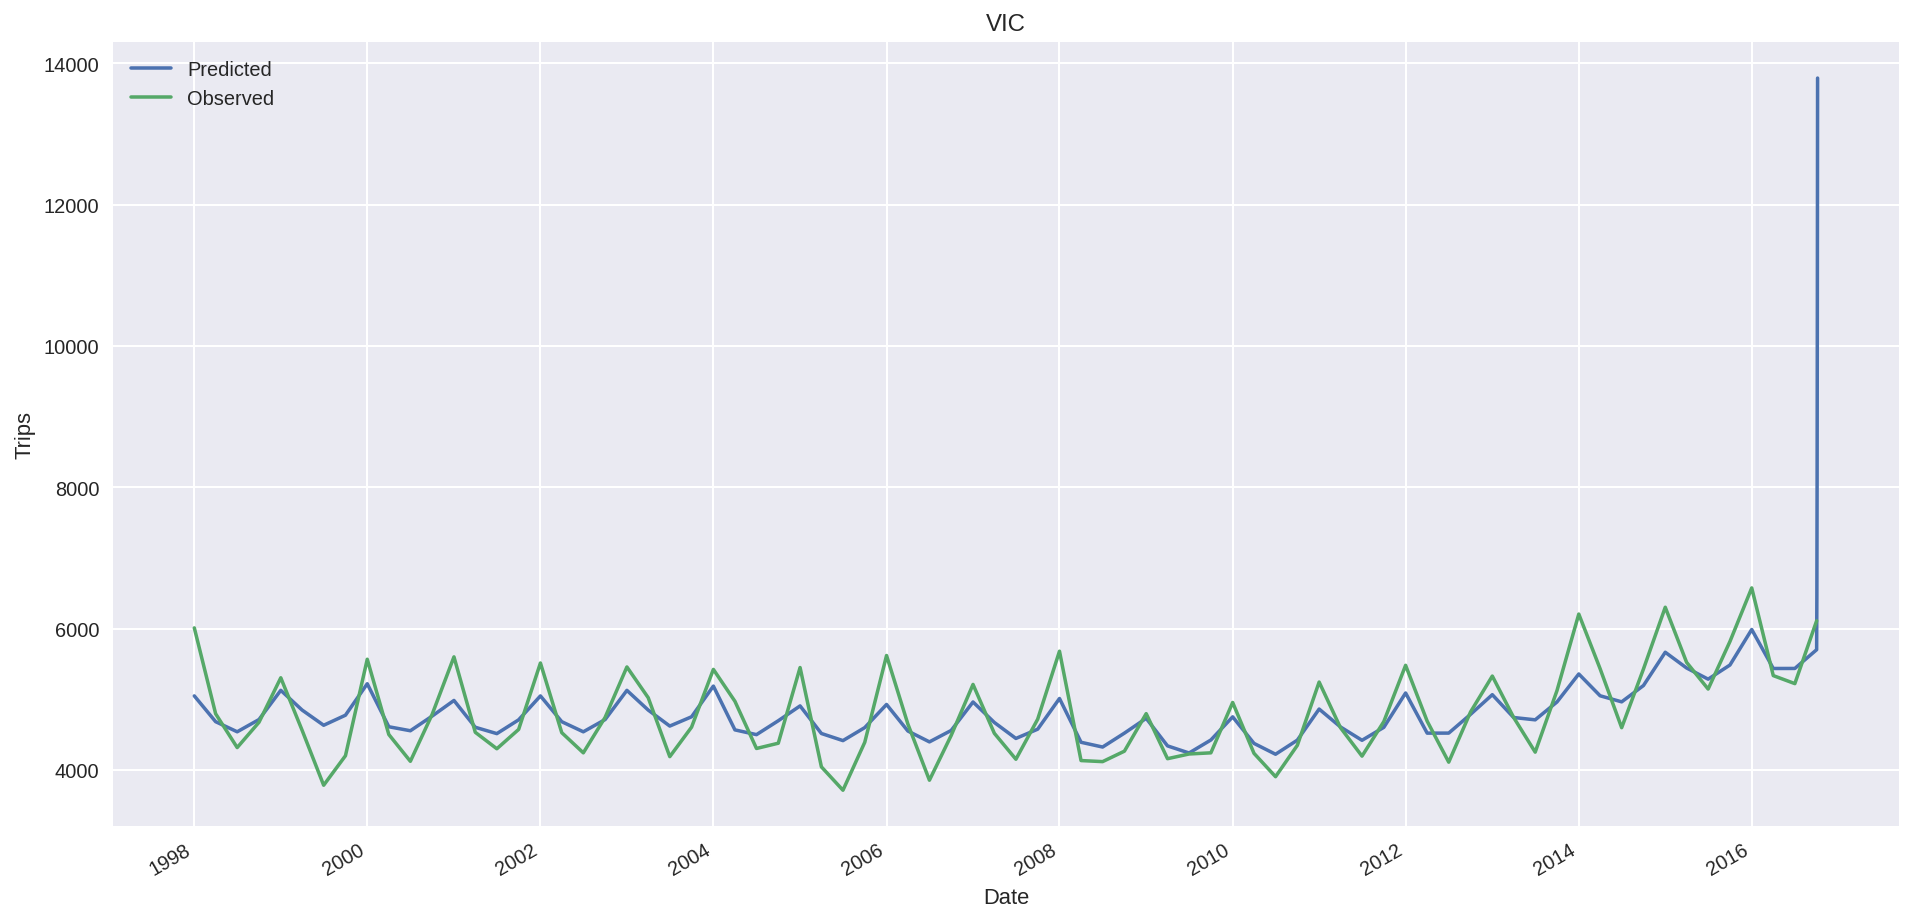

In [82]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['VIC'])

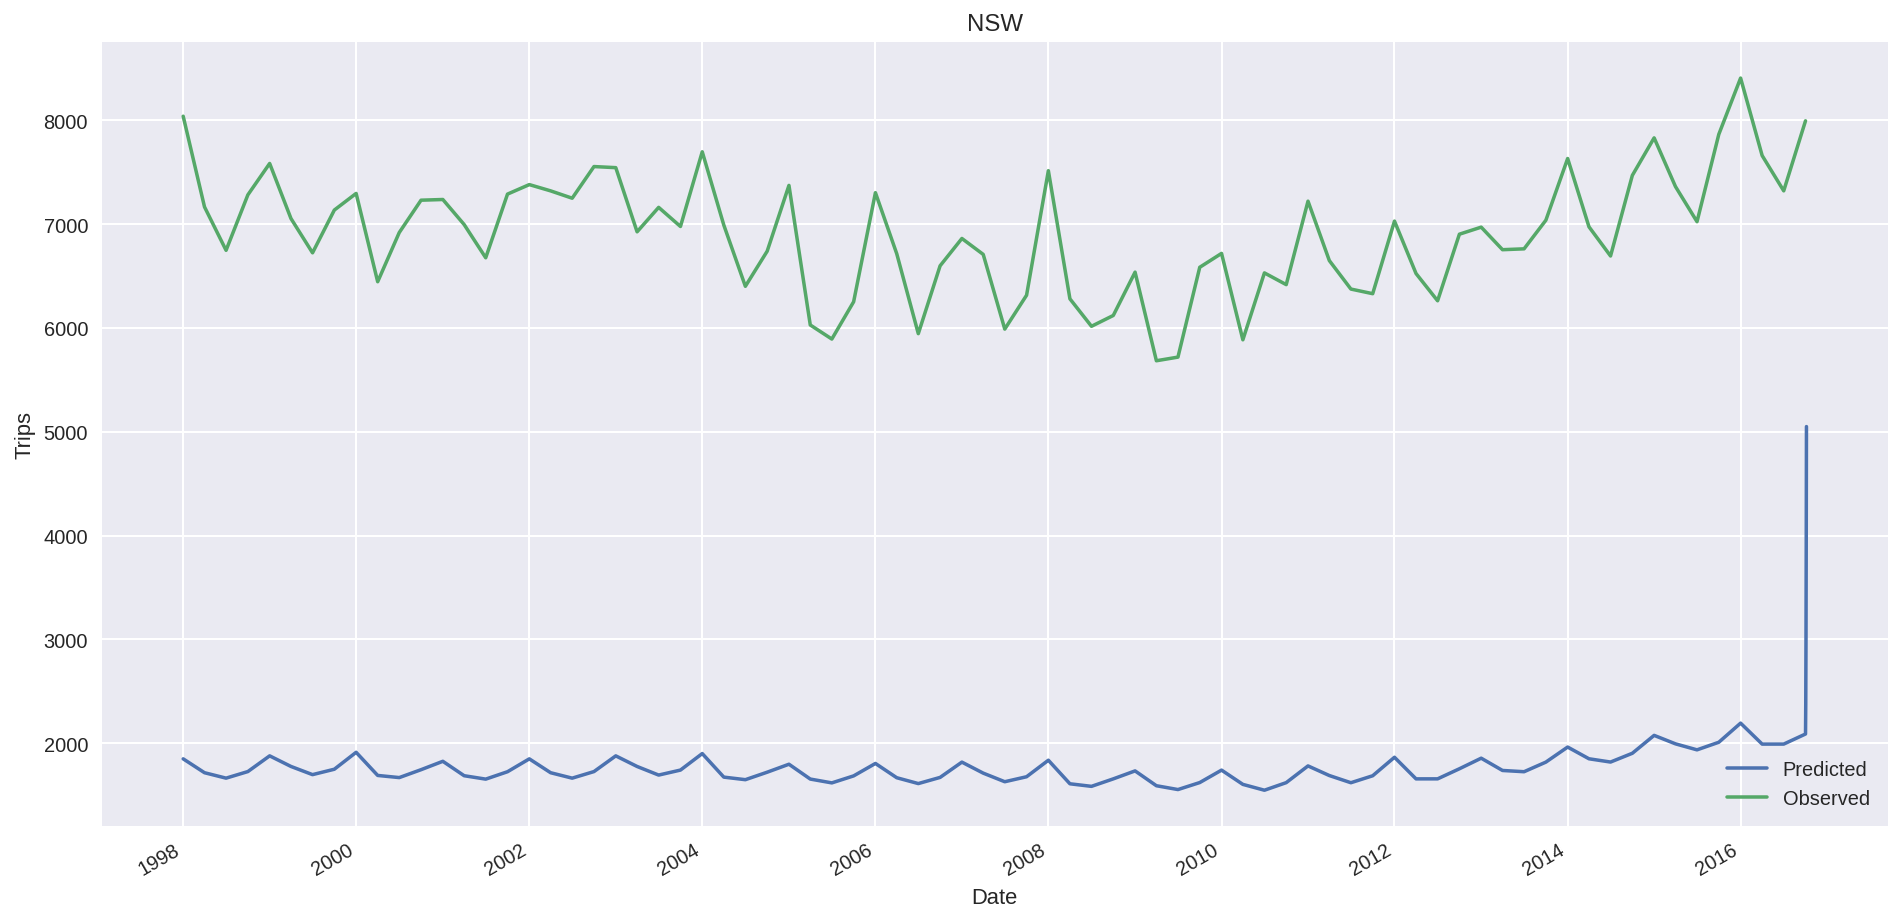

In [83]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['NSW'])

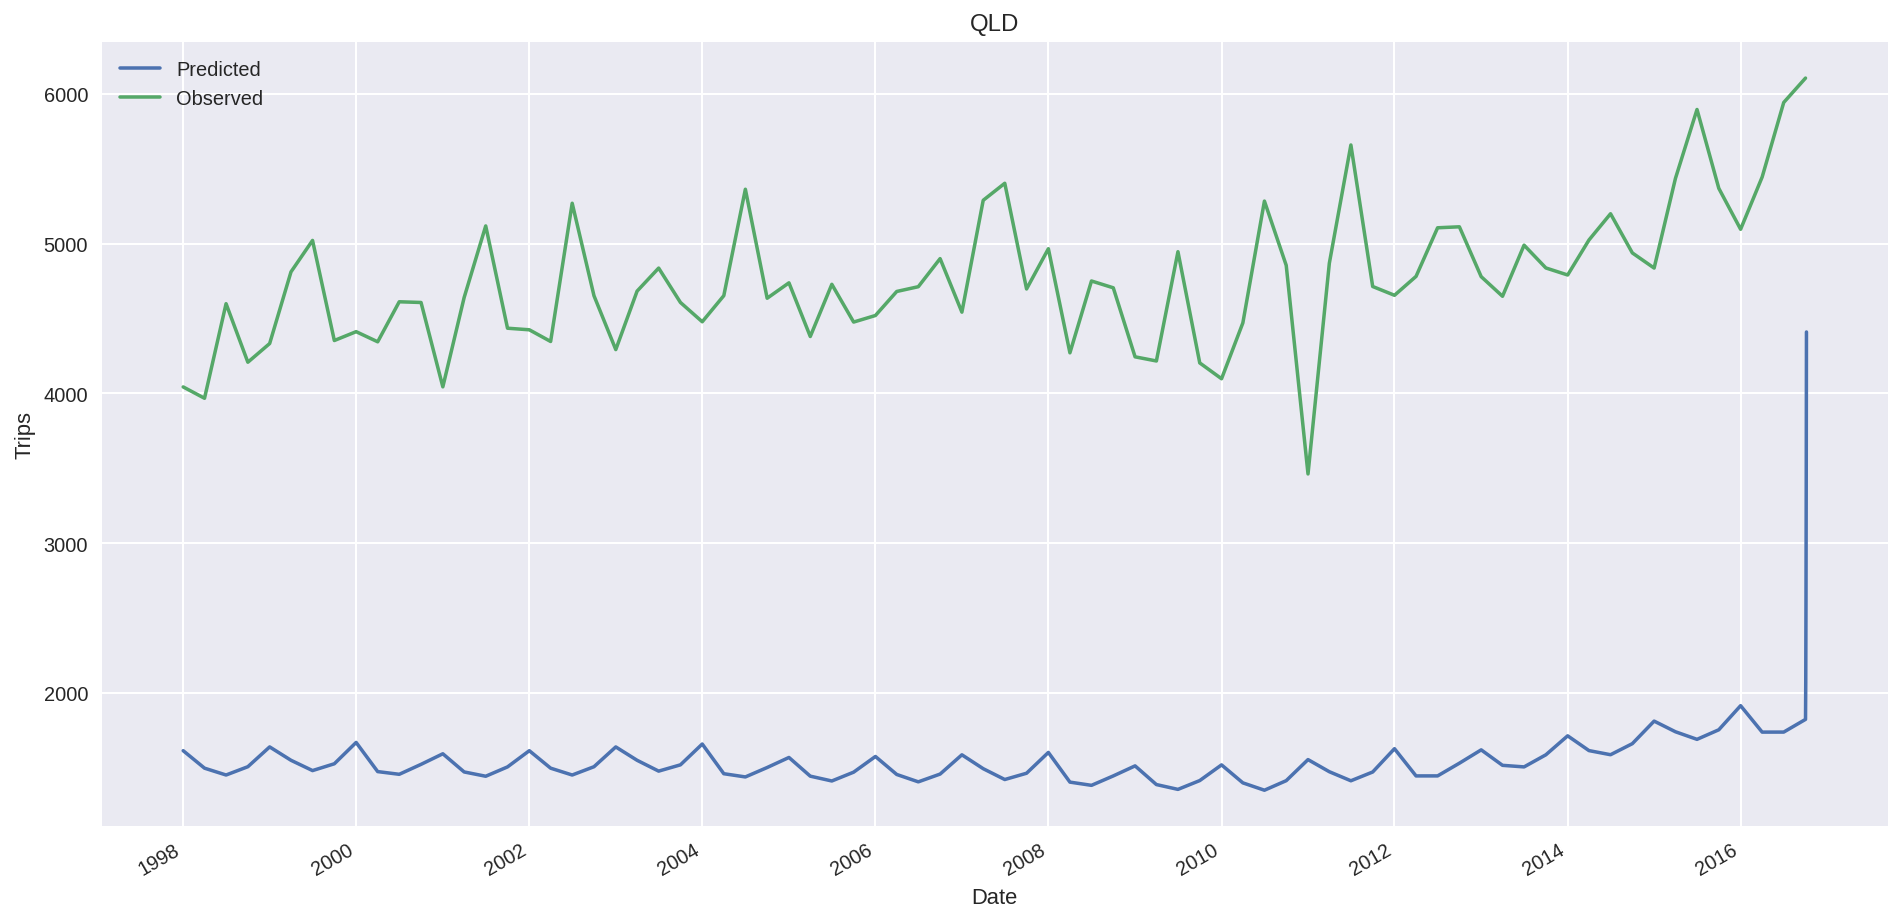

In [84]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['QLD'])

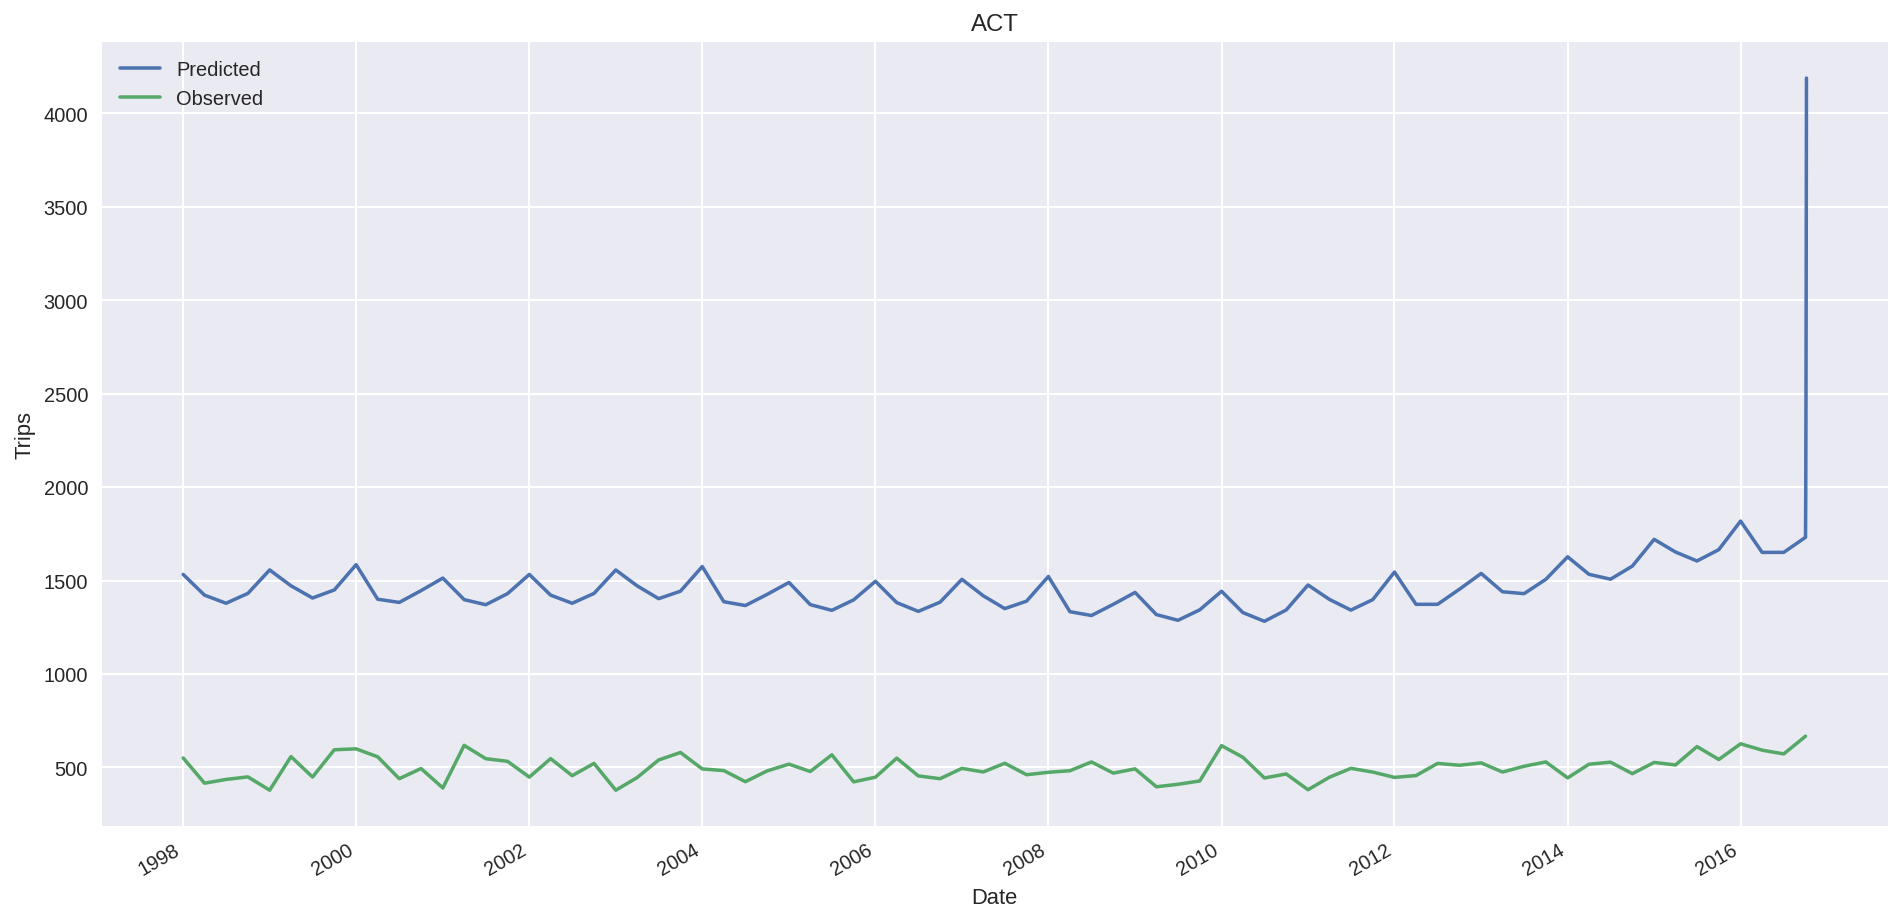

In [85]:
plot_results(pred_td_prophet, hierarchy_df, cols_to_plot=['ACT'])

## Reconciliation - optimal combination using OLS

In [86]:
model_ols_arima = hts.HTSRegressor(model='auto_arima', revision_method='OLS', n_jobs=0)
model_ols_arima = model_ols_arima.fit(hierarchy_df, hierarchy)
pred_ols_arima = model_ols_arima.predict(steps_ahead=4)

Fitting models: 100%|██████████| 85/85 [00:00<00:00, 211.06it/s]


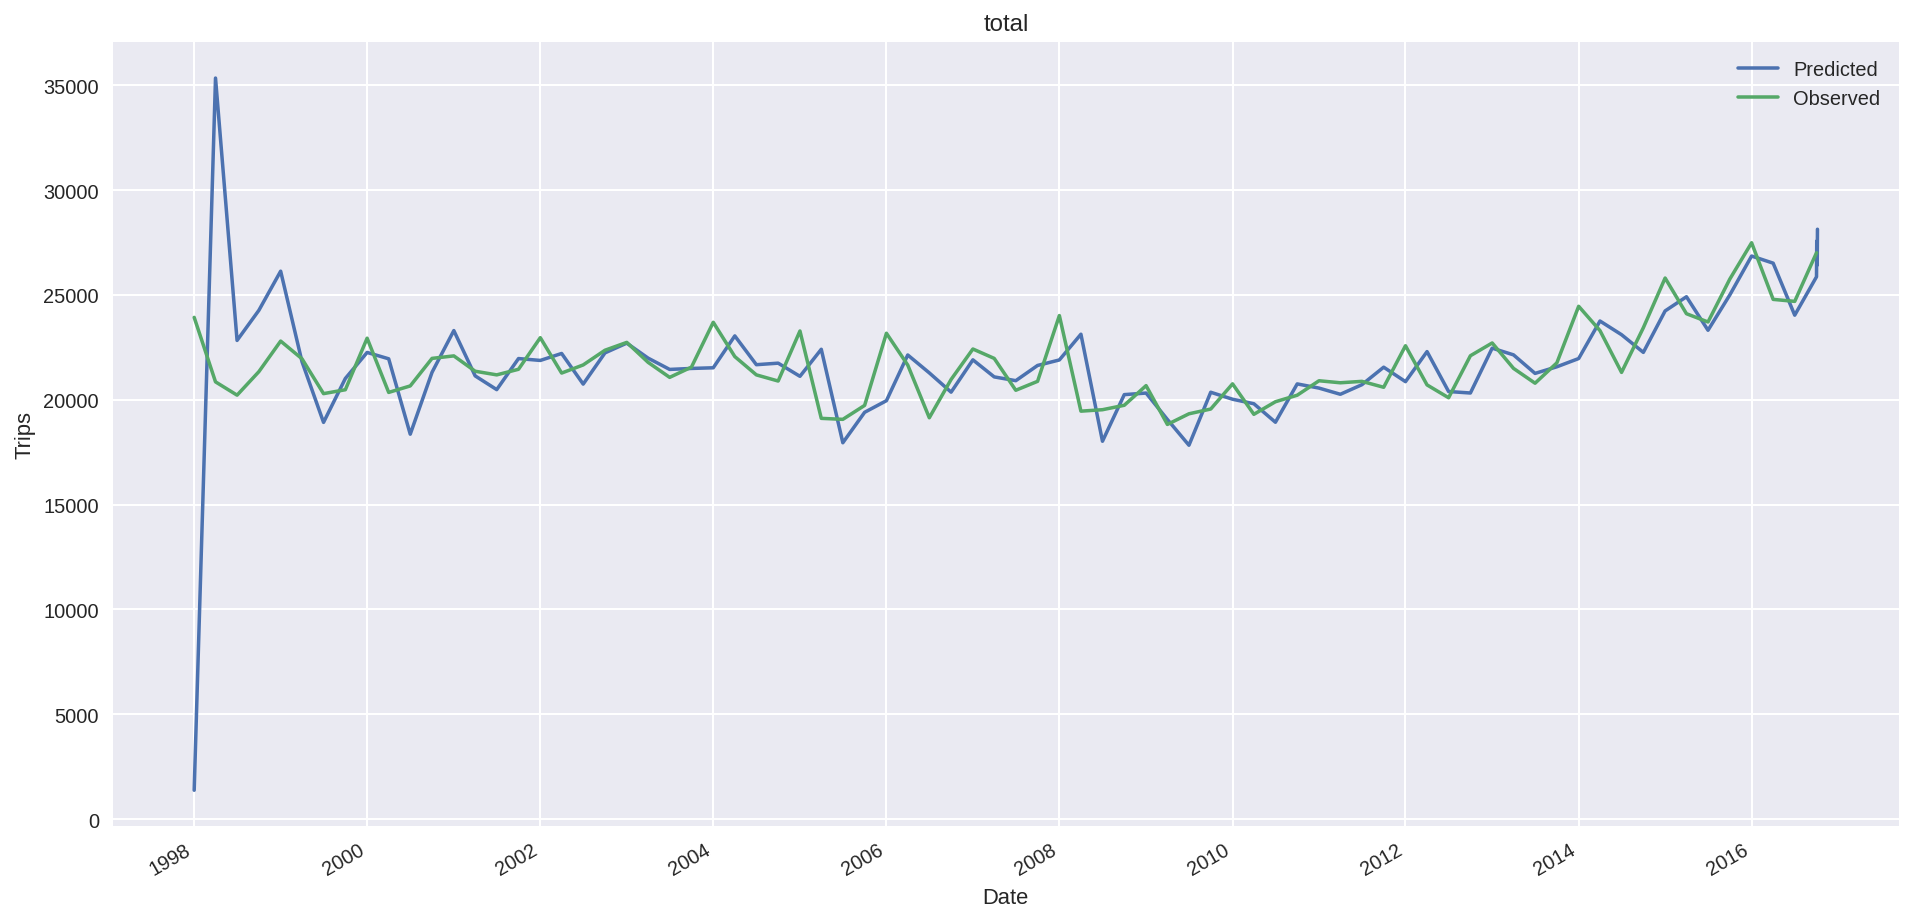

In [87]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['total'])

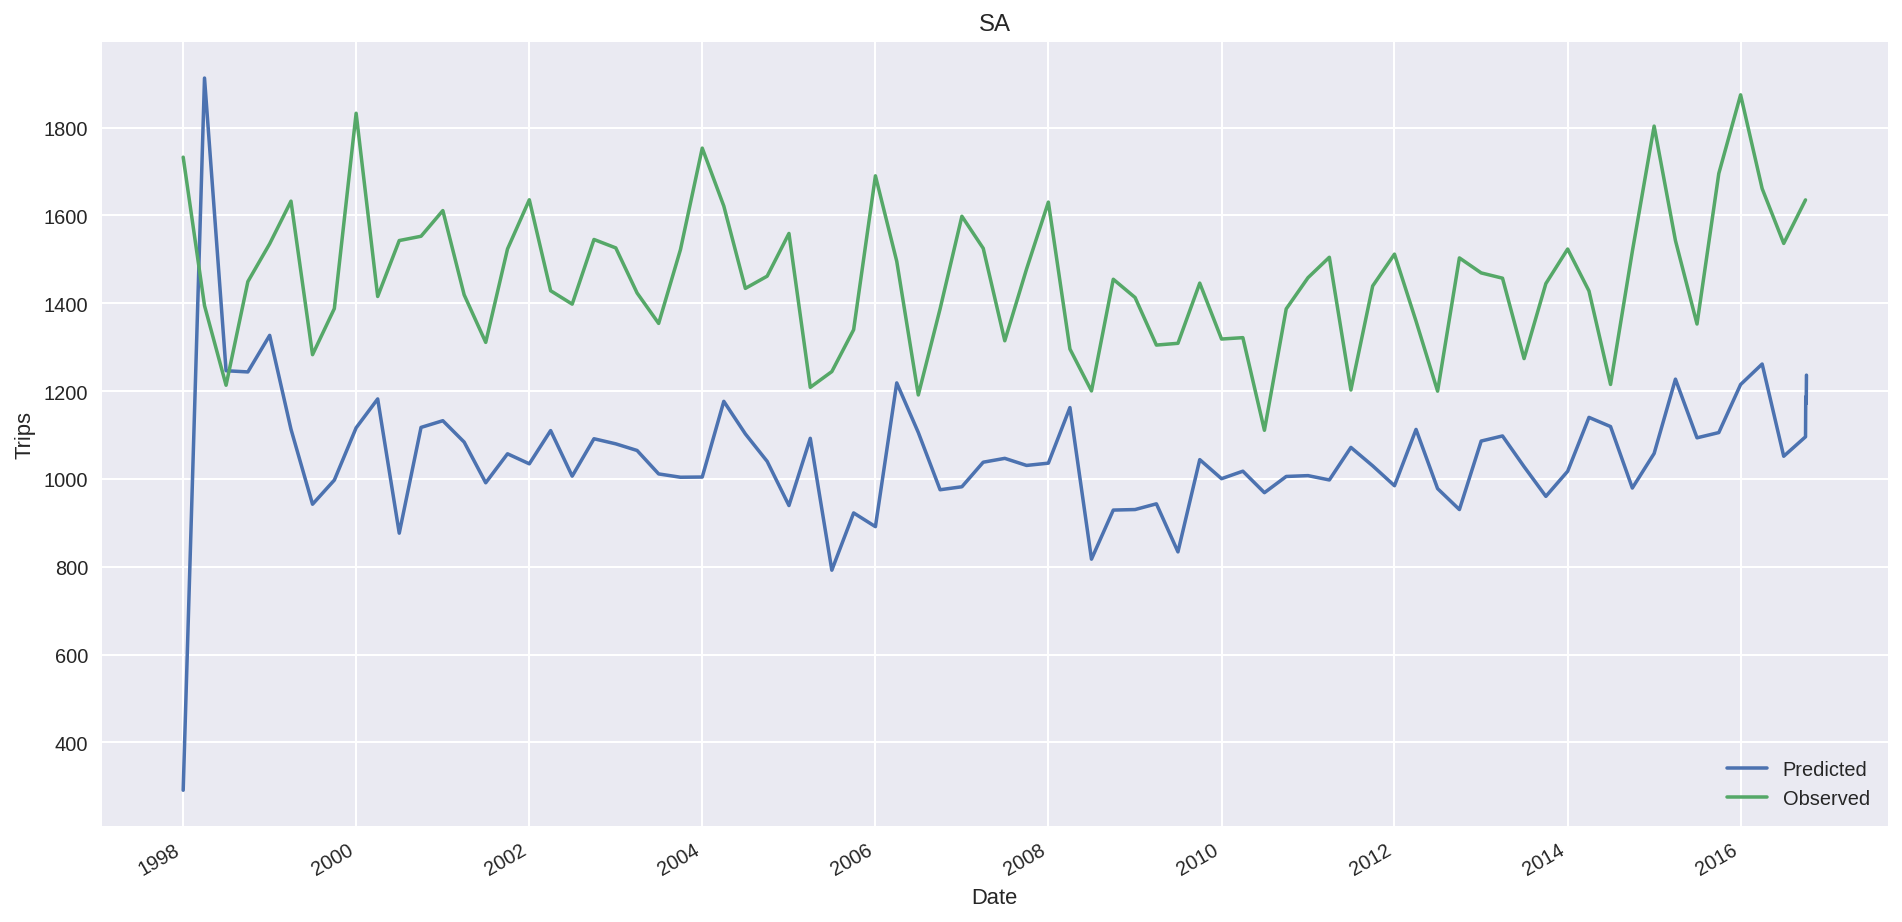

In [88]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['SA'])

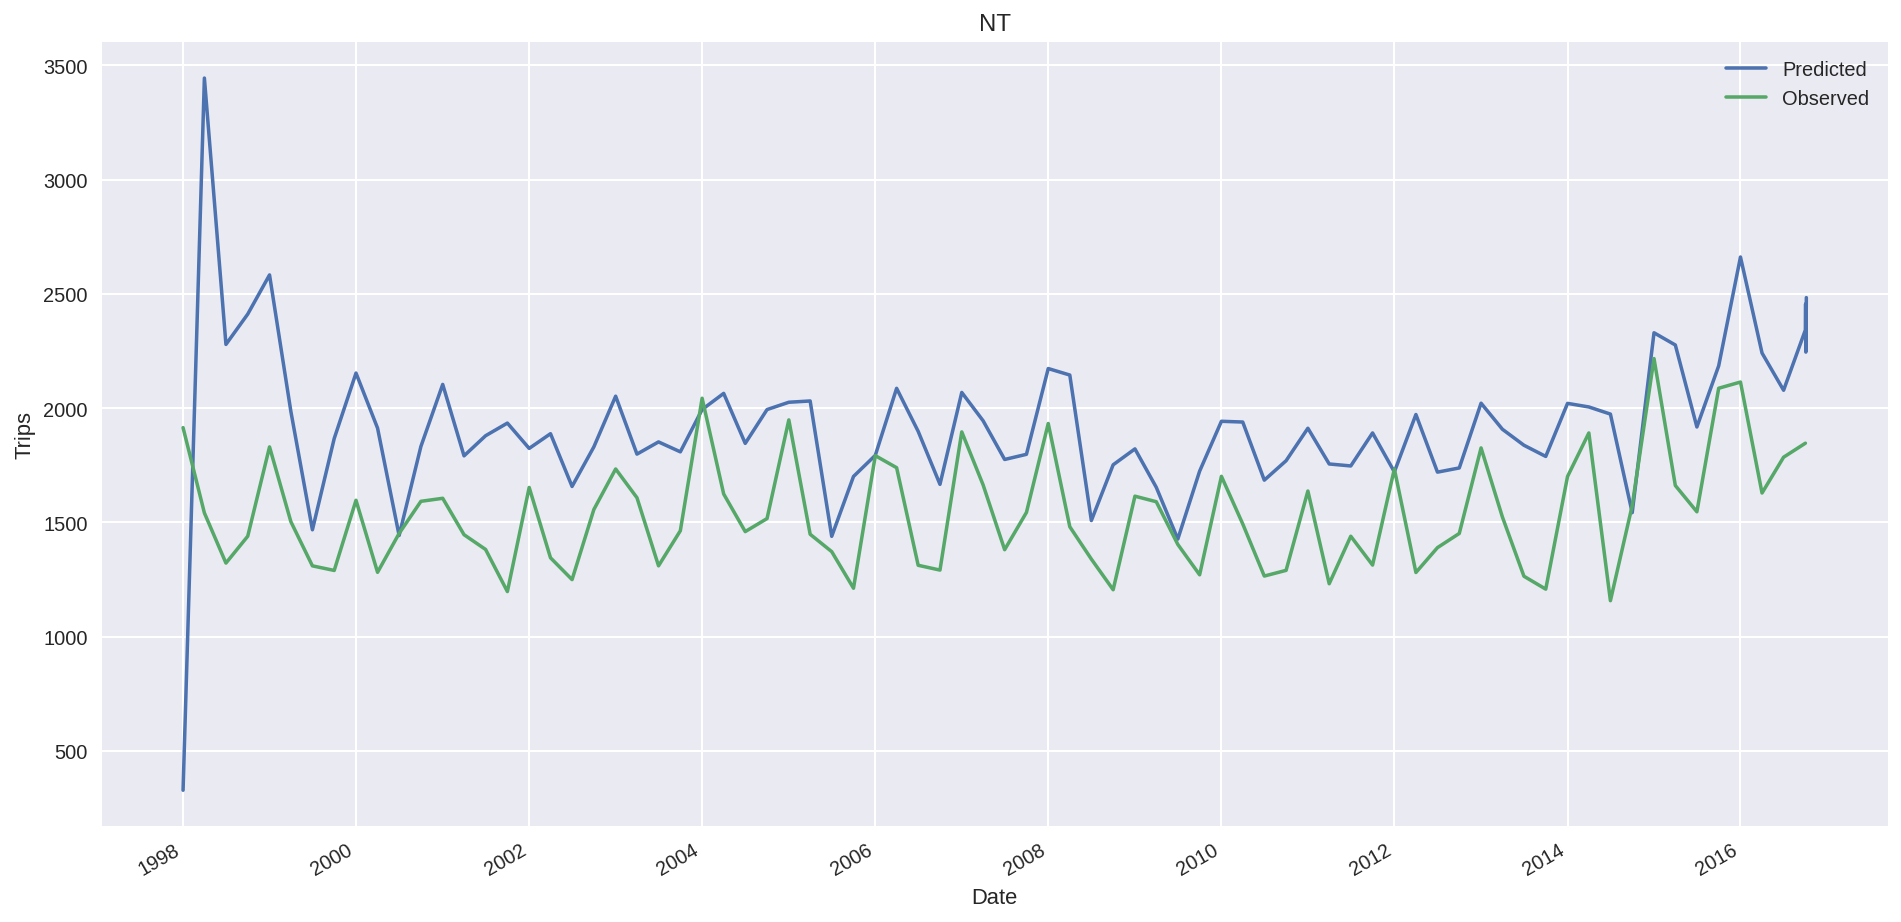

In [89]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['NT'])

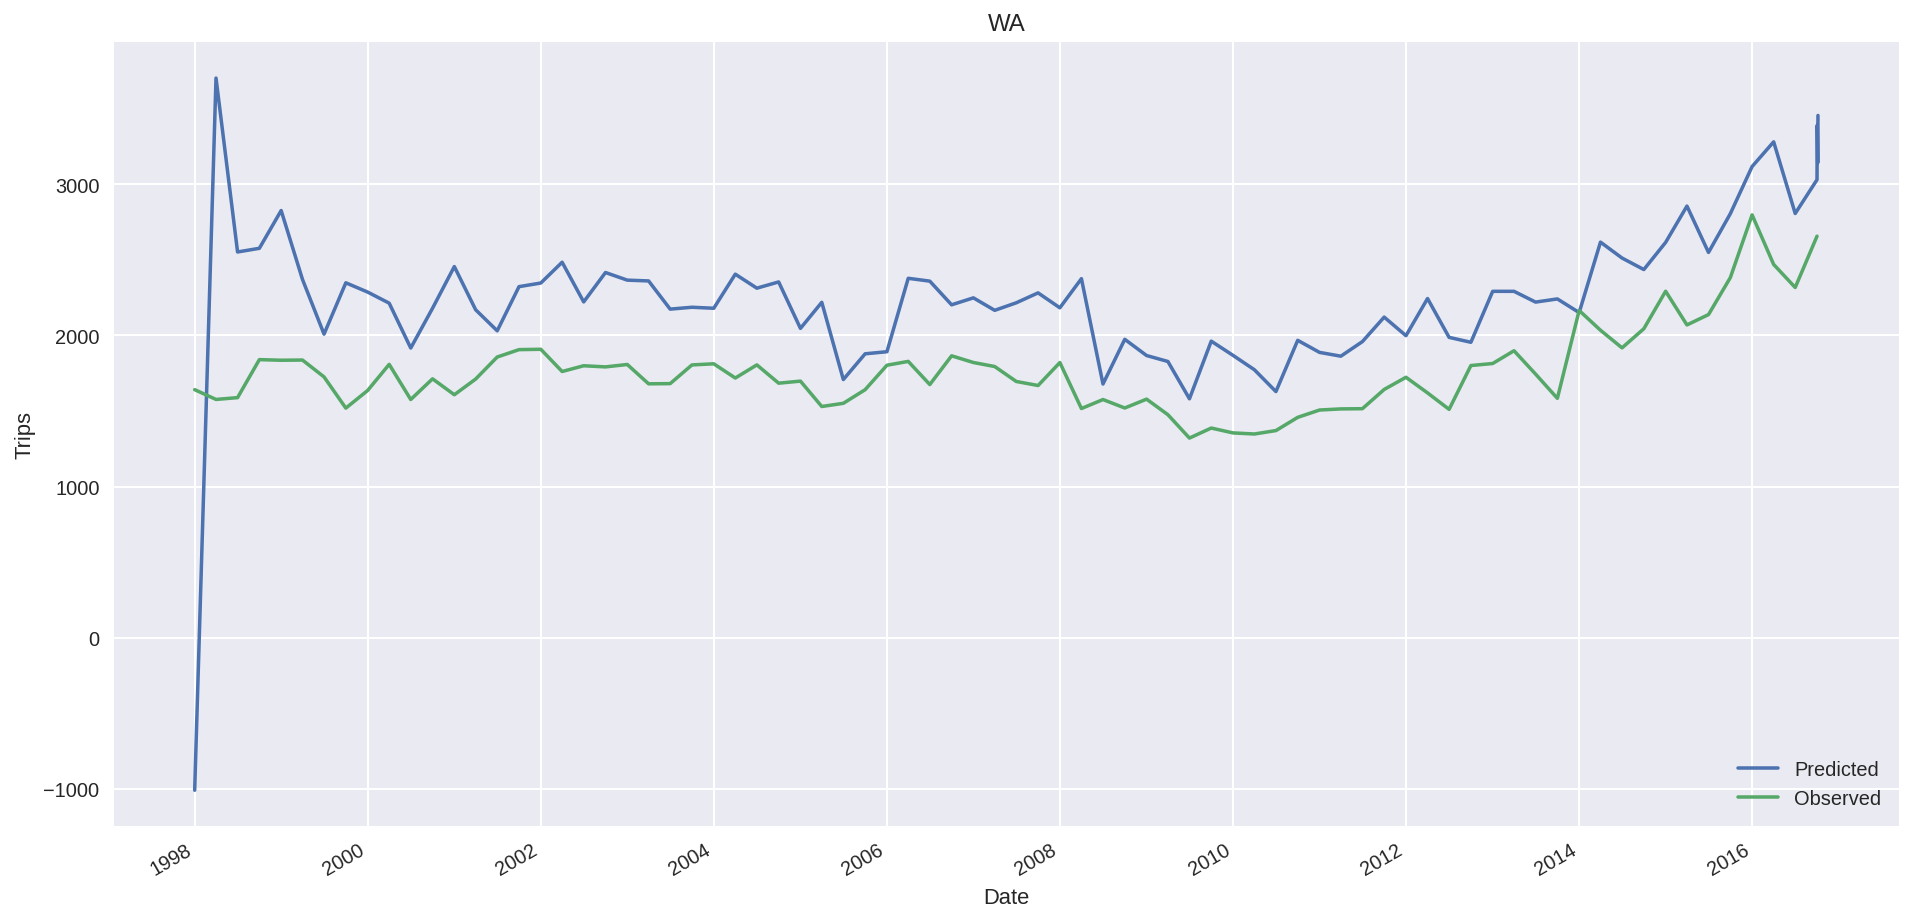

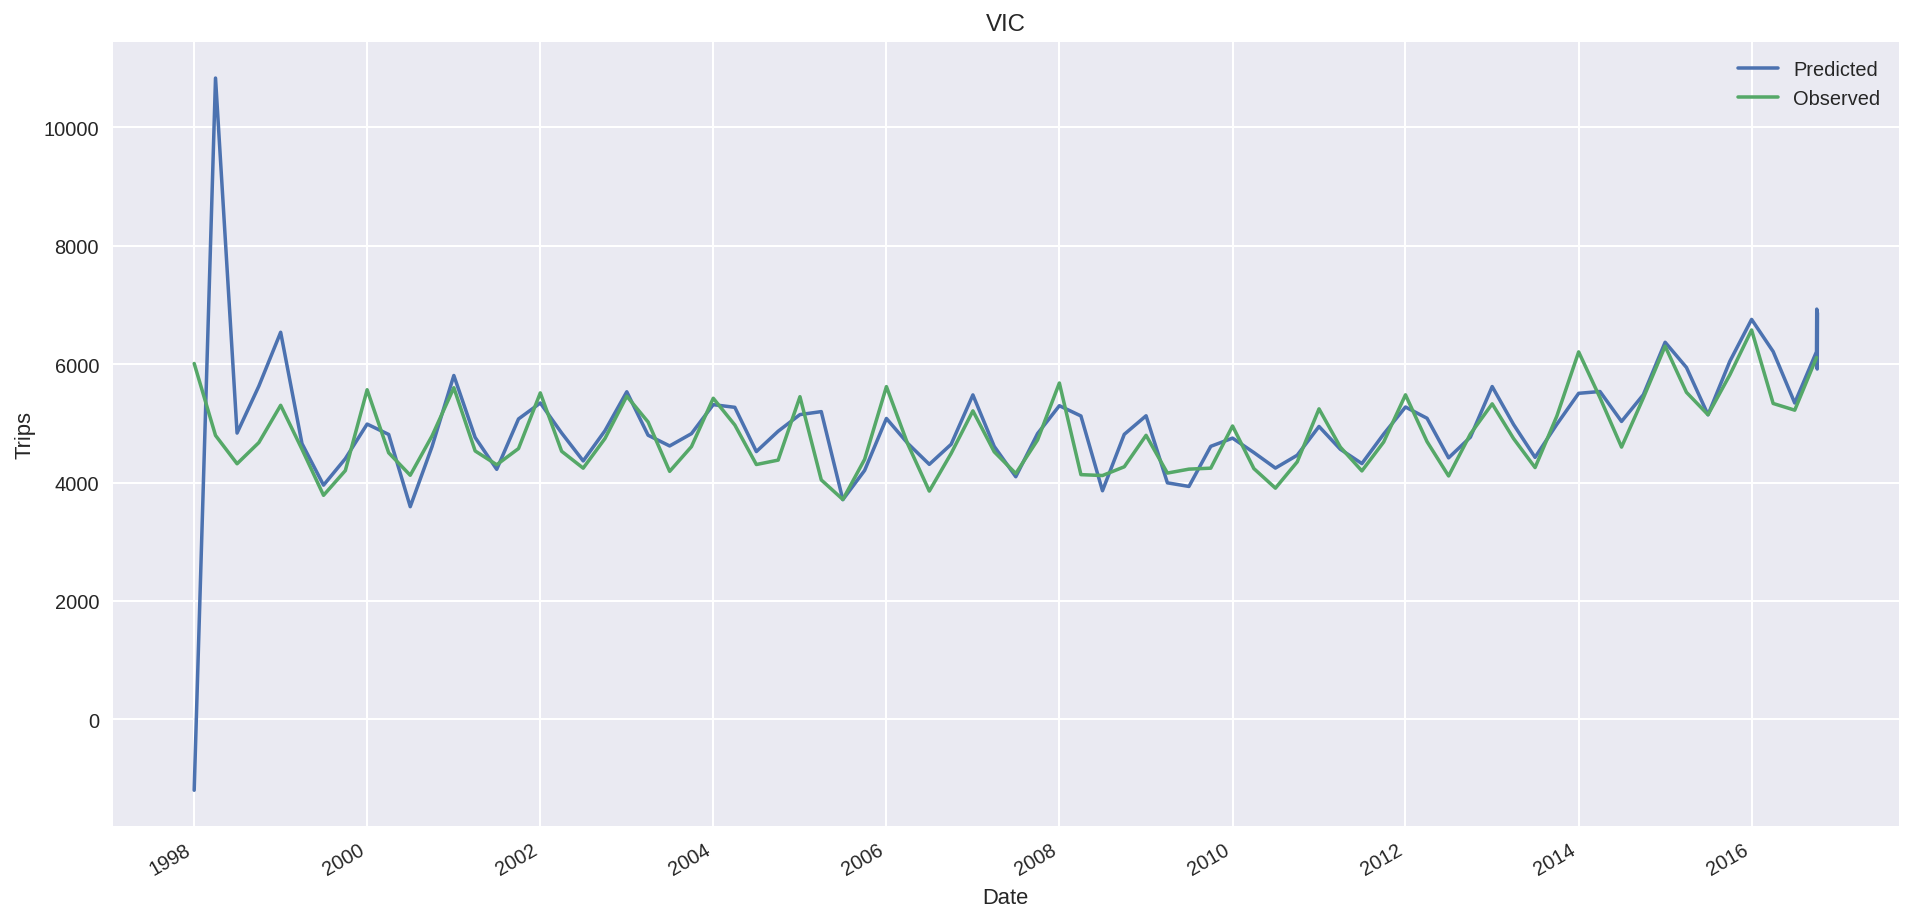

In [91]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['VIC'])

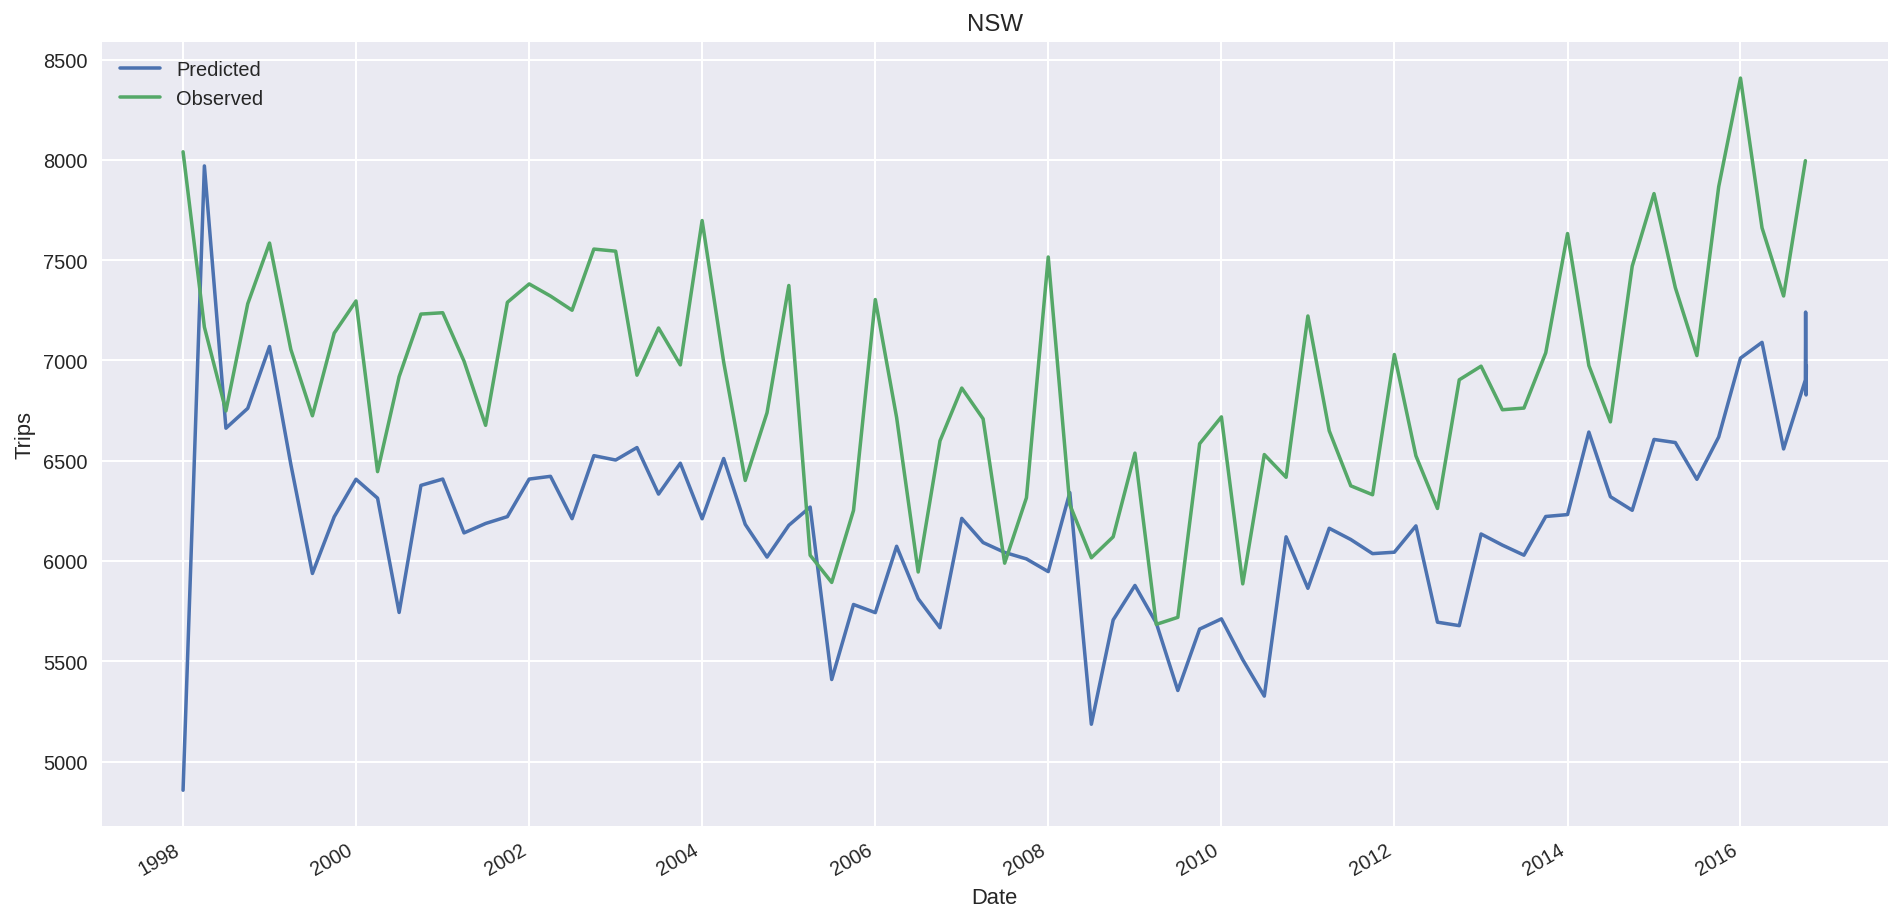

In [92]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['NSW'])

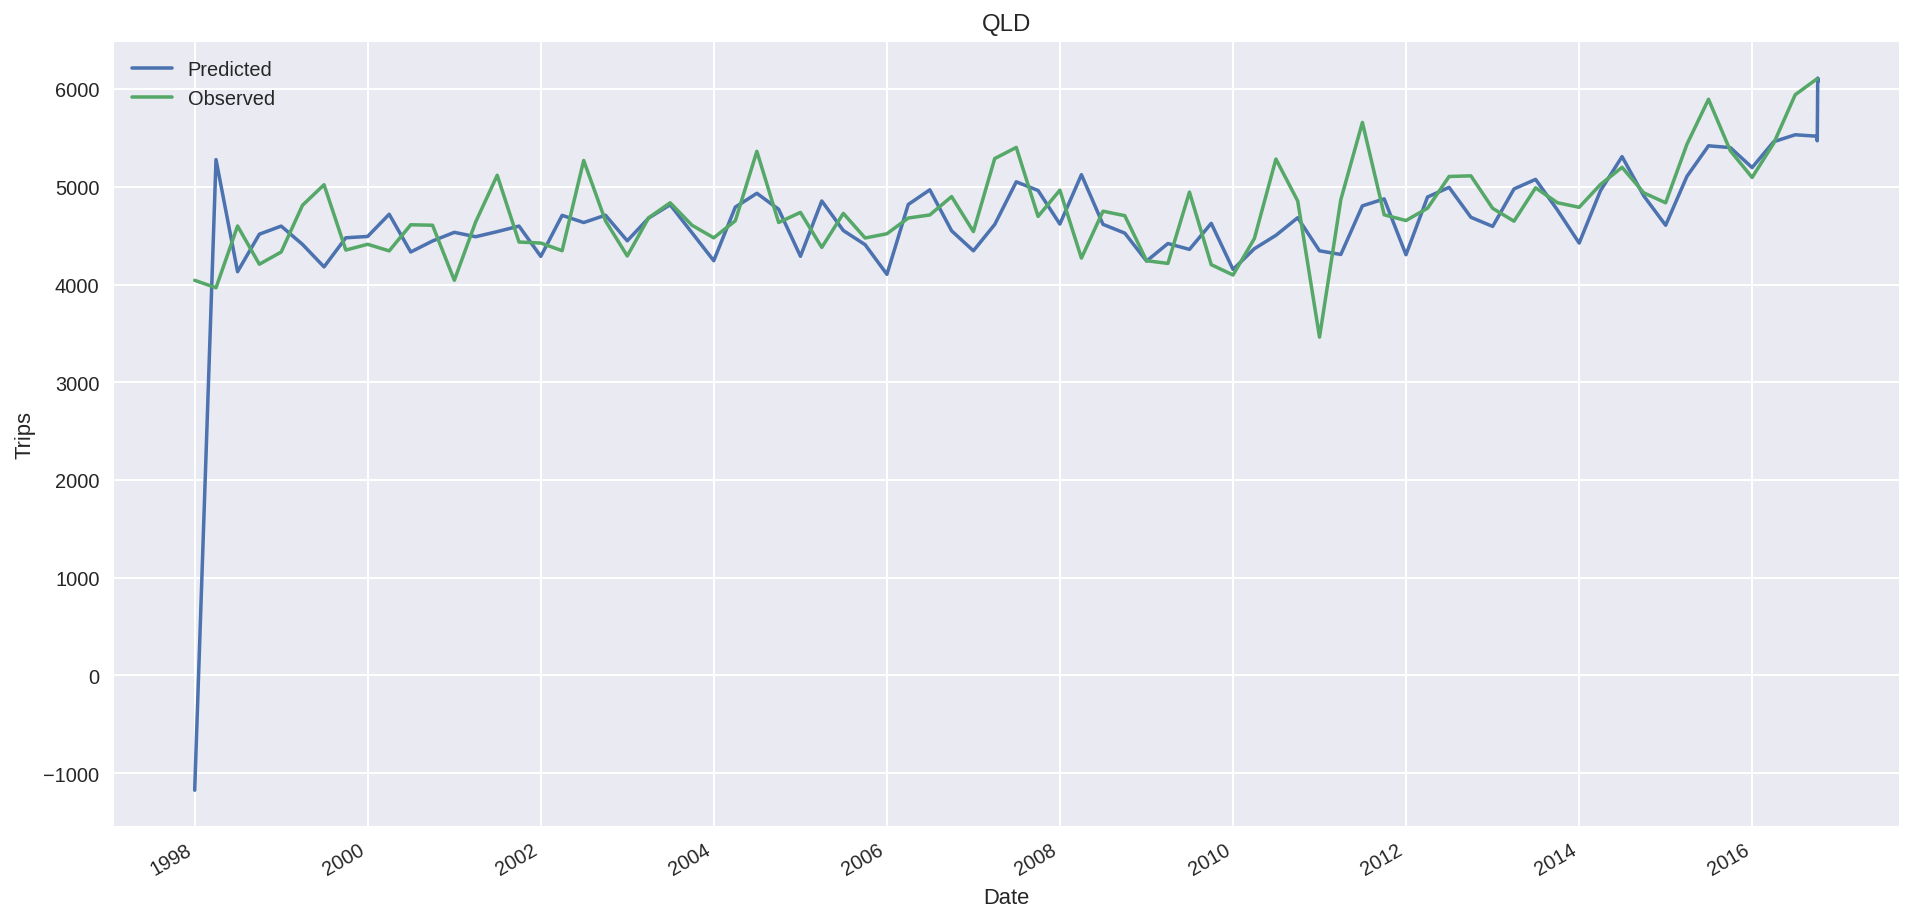

In [93]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['QLD'])

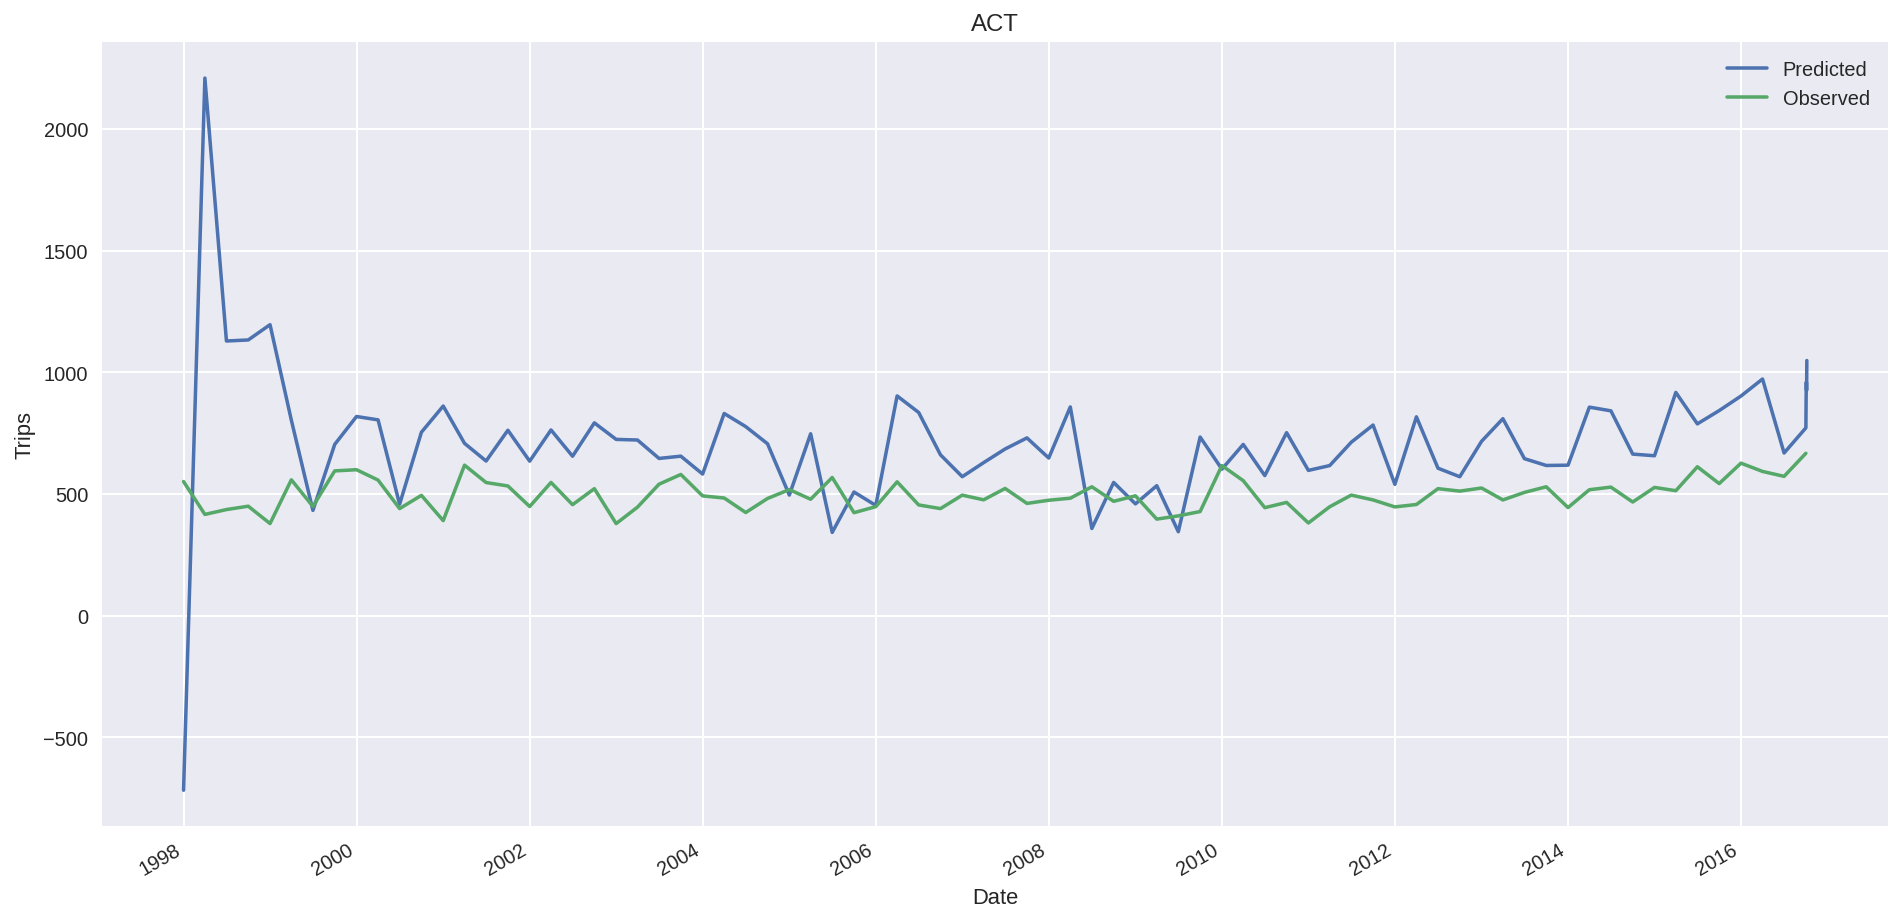

In [94]:
plot_results(pred_ols_arima, hierarchy_df, cols_to_plot=['ACT'])

In [95]:
model_ols_prophet = hts.HTSRegressor(model='prophet', revision_method='OLS', n_jobs=0)
model_ols_prophet = model_ols_prophet.fit(hierarchy_df, hierarchy)
pred_ols_prophet = model_ols_prophet.predict(steps_ahead=4)

Fitting models:   0%|          | 0/85 [00:00<?, ?it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   1%|          | 1/85 [00:01<01:25,  1.01s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   2%|▏         | 2/85 [00:01<01:16,  1.09it/s]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Fitting models:   4%|▎         | 3/85 [00:03<01:23,  1.02s/it]INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasona

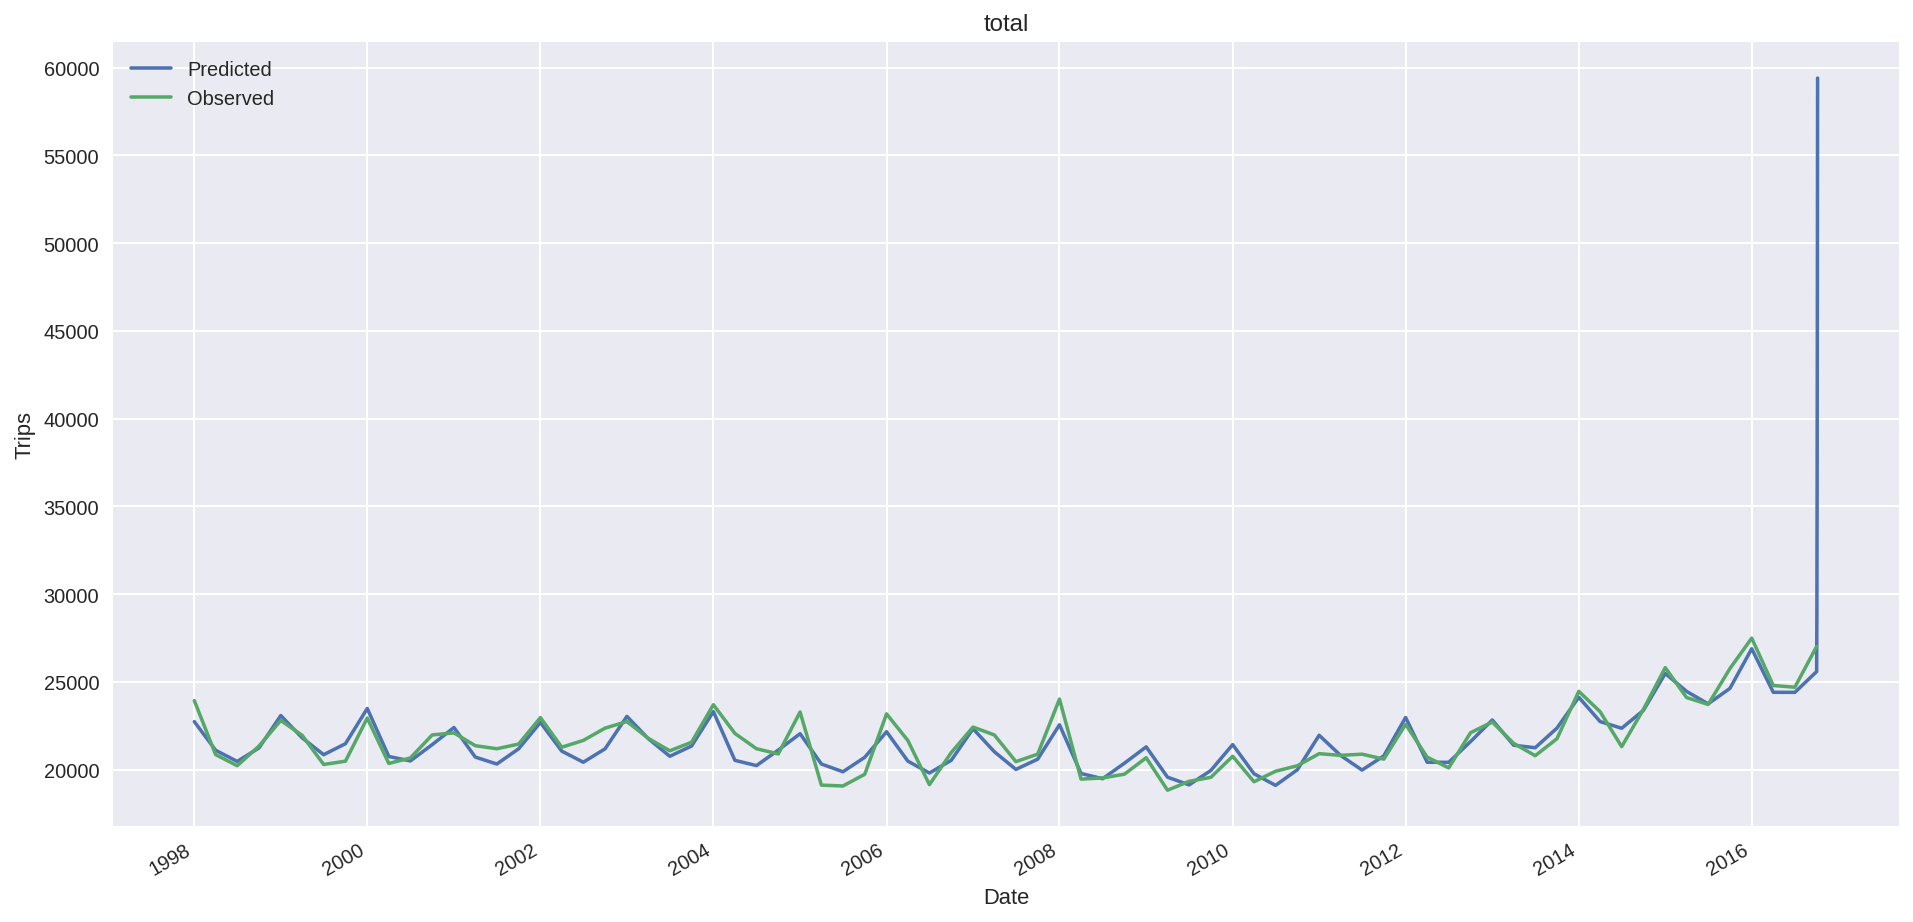

In [96]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['total'])

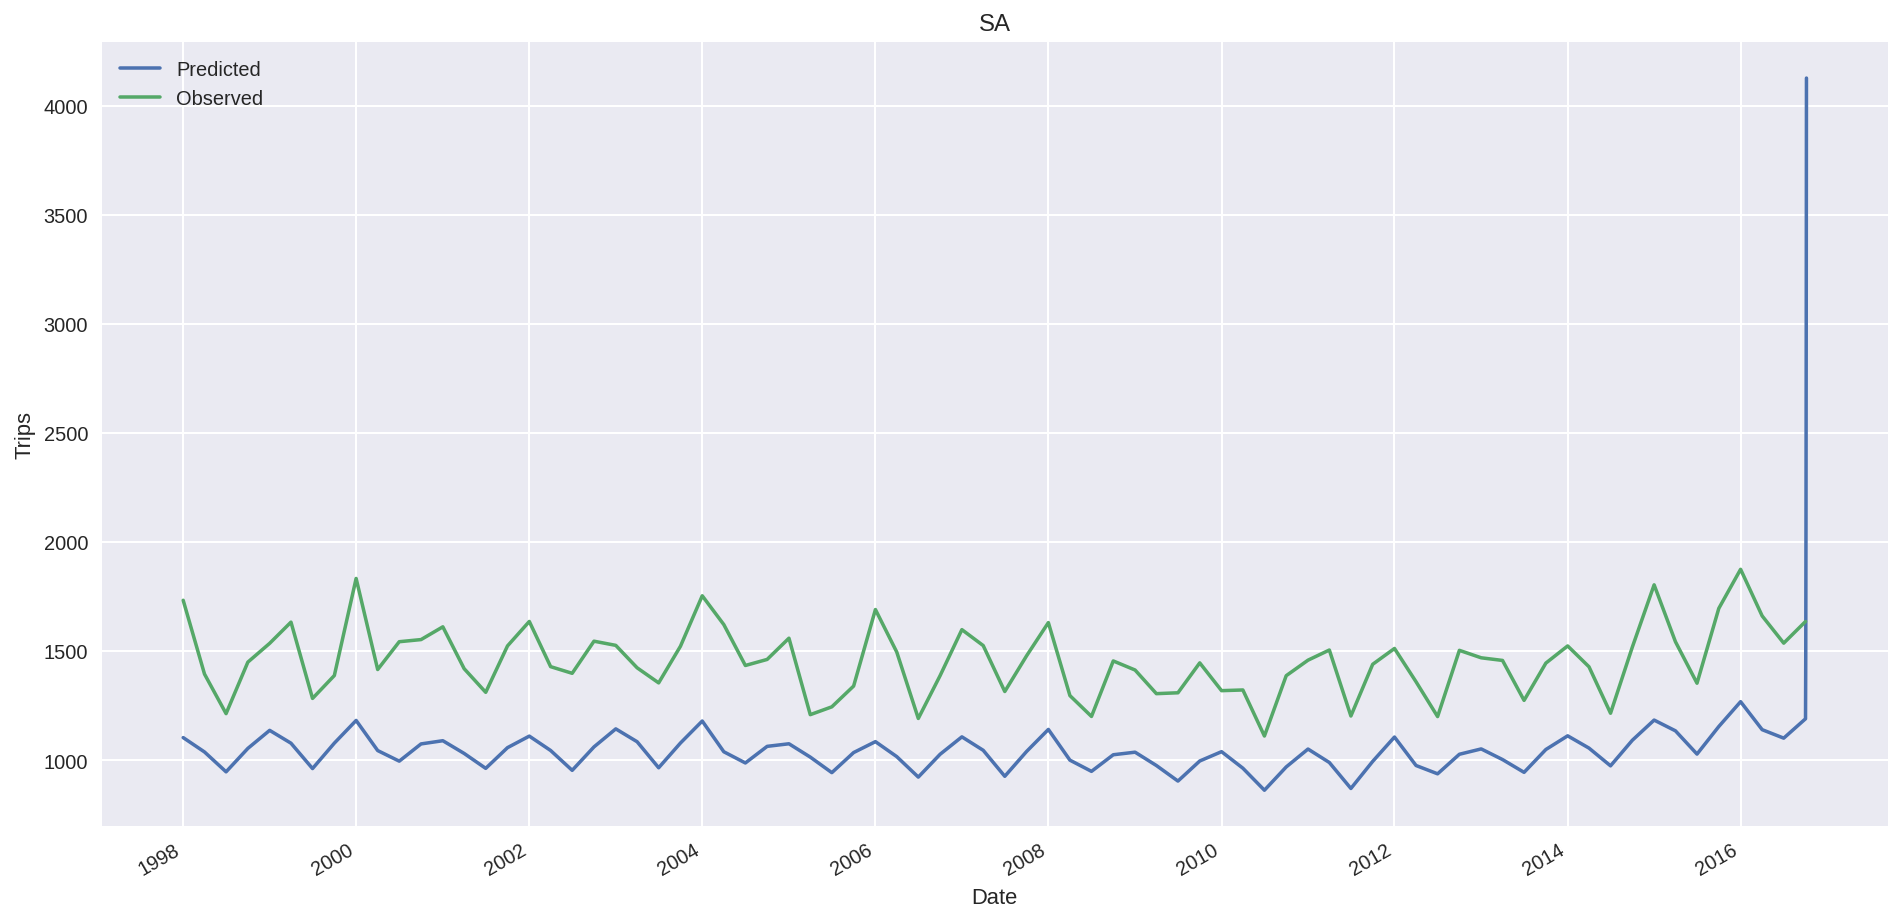

In [97]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['SA'])

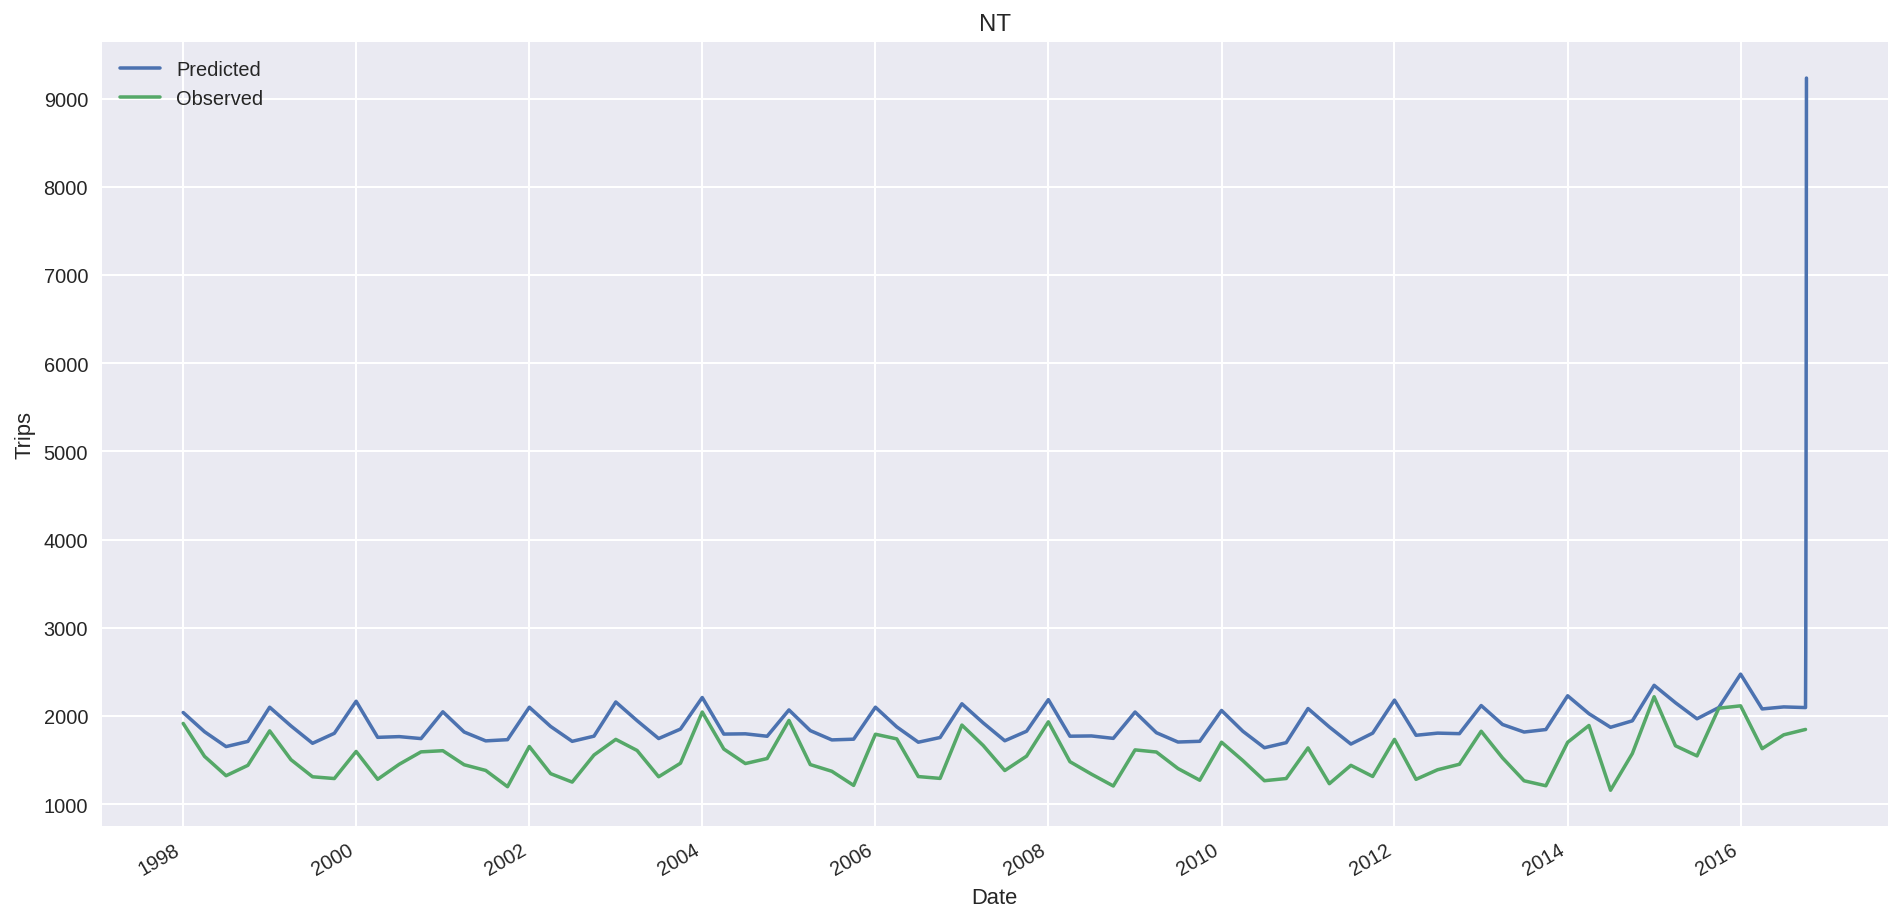

In [98]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['NT'])

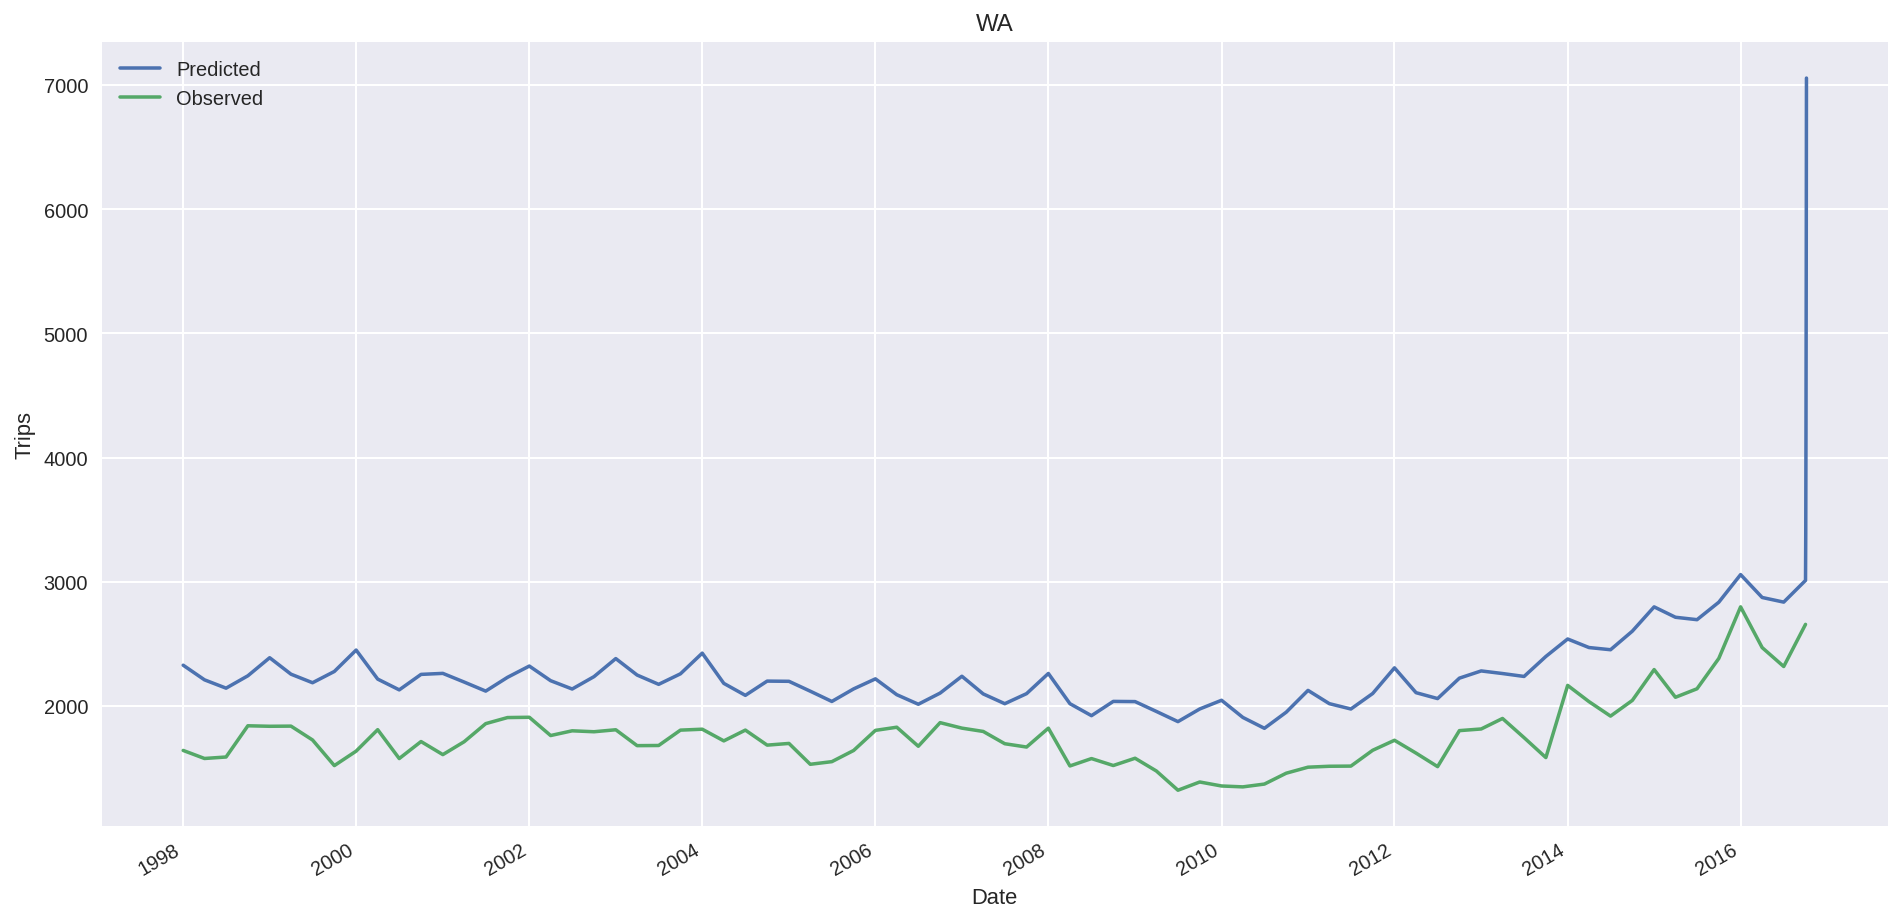

In [99]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['WA'])

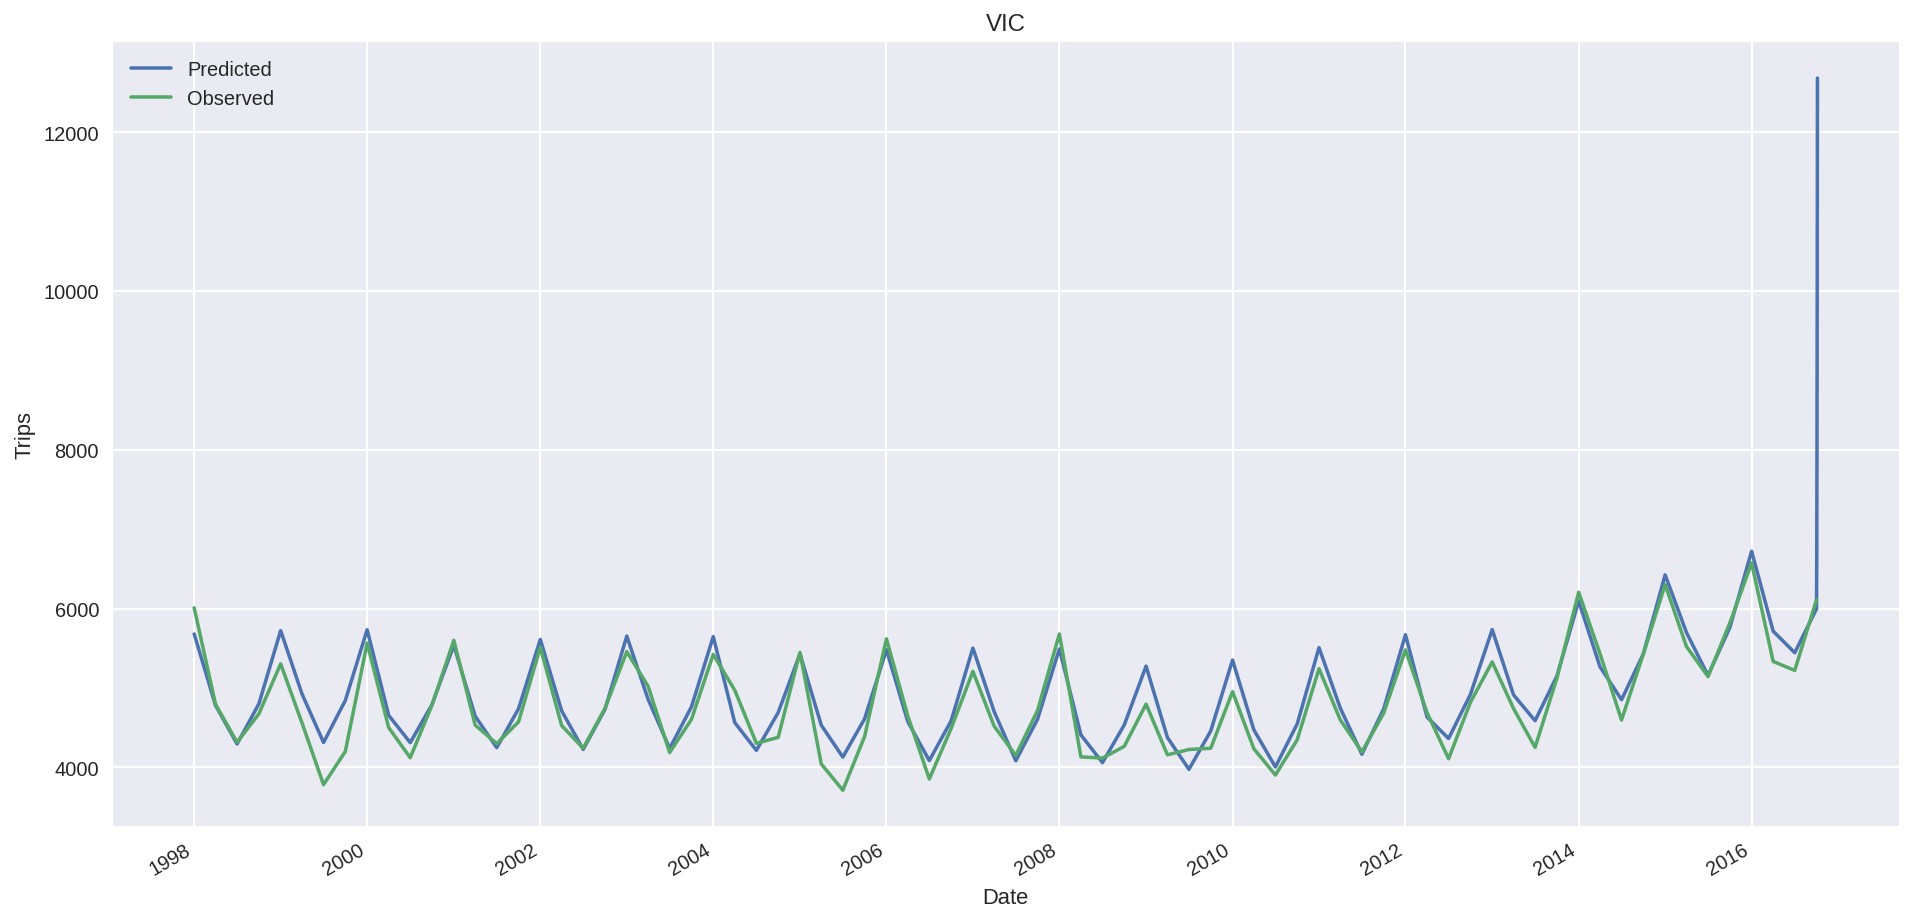

In [100]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['VIC'])

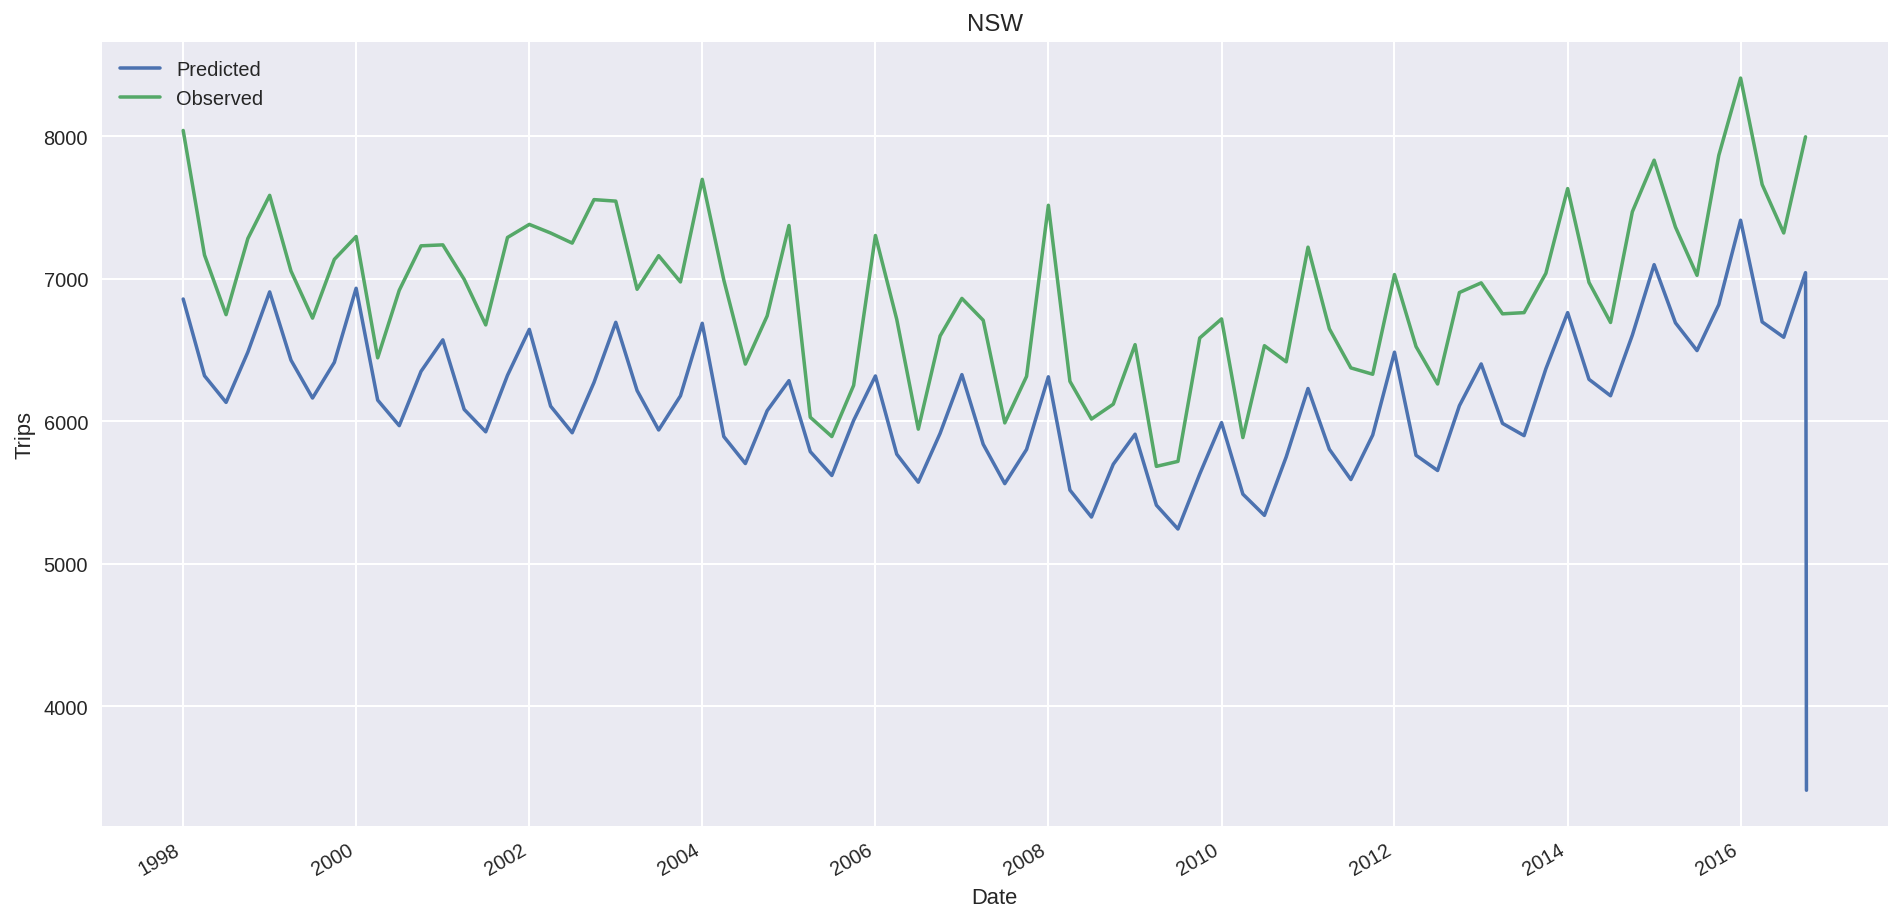

In [101]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['NSW'])

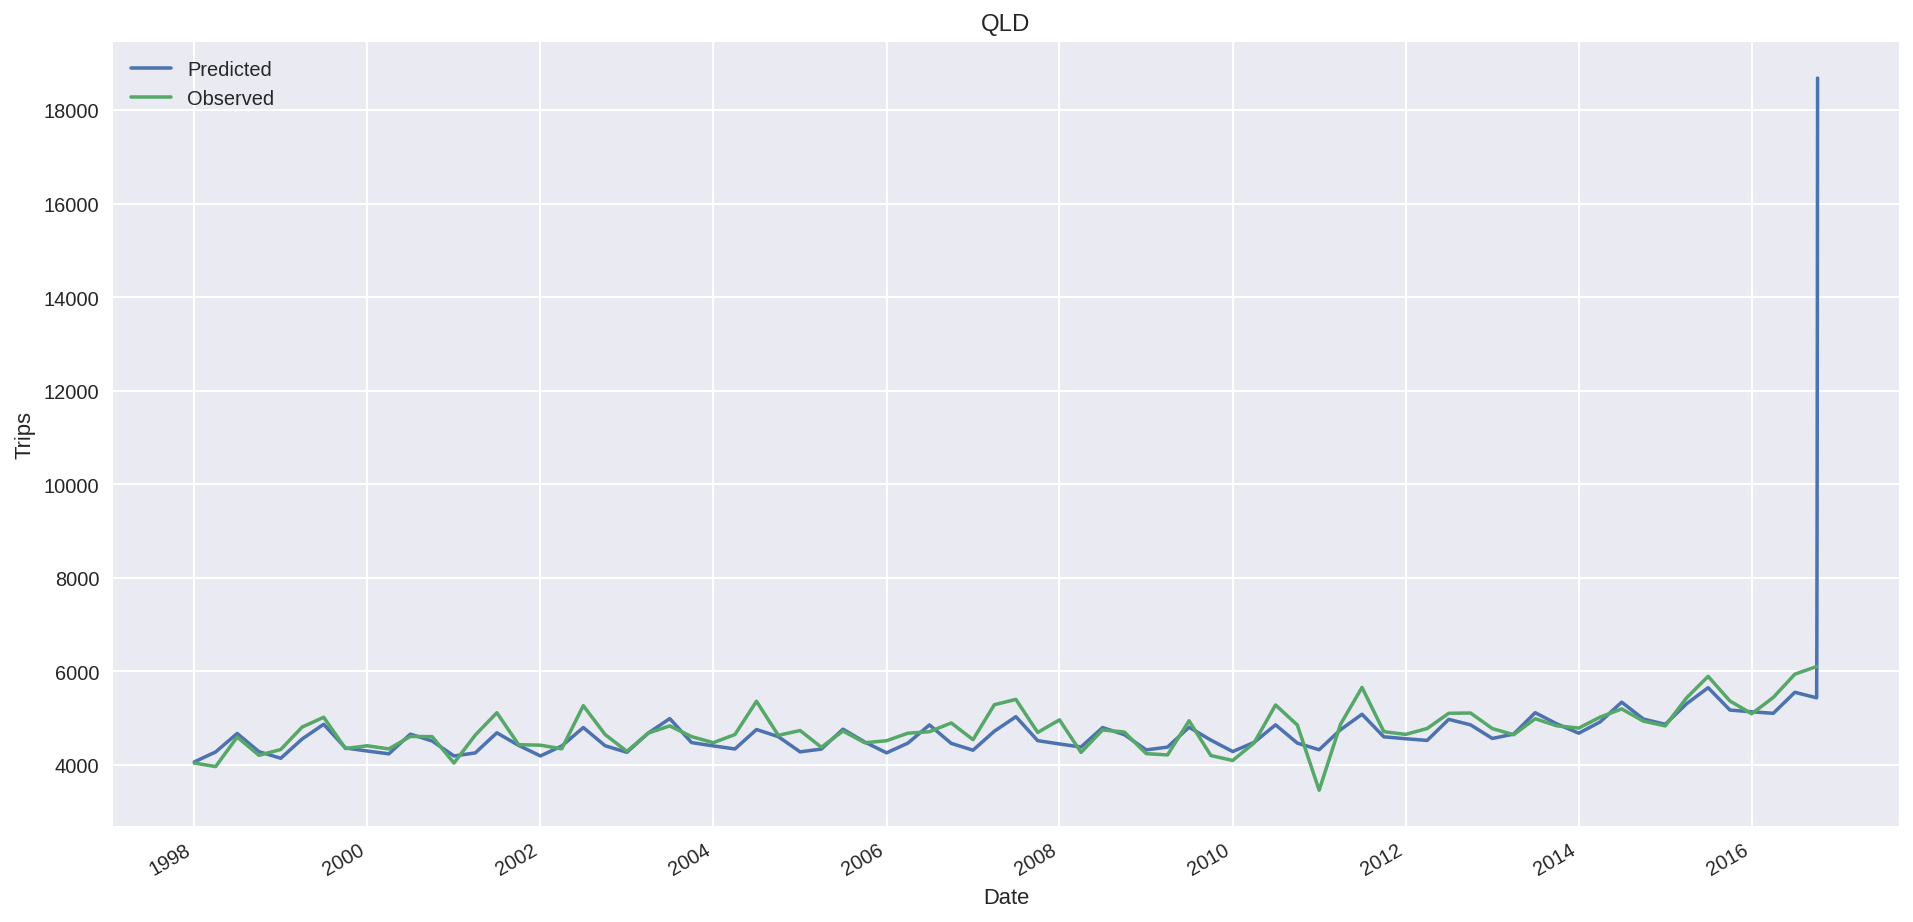

In [102]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['QLD'])

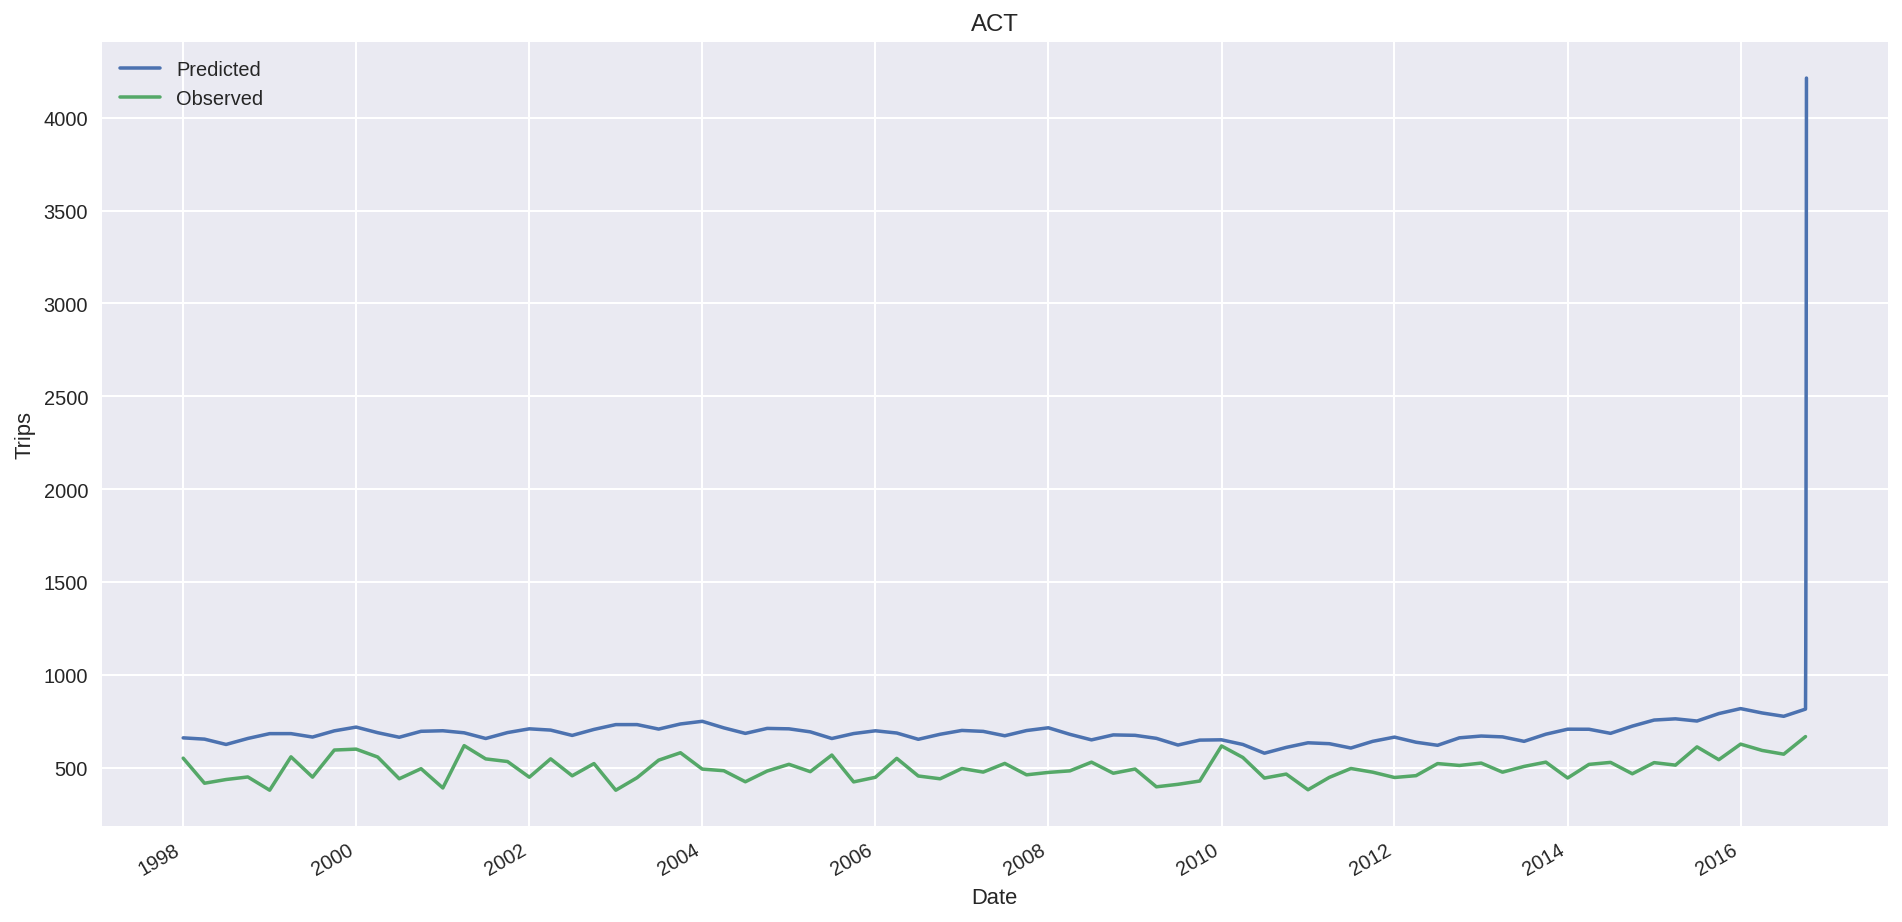

In [103]:
plot_results(pred_ols_prophet, hierarchy_df, cols_to_plot=['ACT'])